In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit,njit
from numba import int32, float32 ,float64,vectorize   # import the types
from numba.experimental import jitclass
from numba.typed import List as NumbaList
from scipy.integrate import solve_ivp
from typing import List
import pickle 
exp=np.exp

@jit 
def heaviside (t):
    return (1+np.sign(t))/2
@jit 
def pulse (t,ti,tf):
    return heaviside(t-ti)-heaviside(t-tf)

sin=np.sin
pi=np.pi
#boltz(V::Float64,A::Float64,B::Float64) = 1/(1 + exp((V+A)/B))
@jit
def boltz(V,A,B):
    return 1/(1 + exp((V+A)/B))
#tauX(V::Float64,A::Float64,B::Float64,D::Float64,E::Float64) = A - B/(1+exp((V+D)/E))
@jit
def tauX(V,A,B,D,E):
    return A - B/(1+exp((V+D)/E))
#mNainf(V::Float64) = boltz(V,25.5,-5.29)
@jit
def mNa_inf(V):
    return boltz(V,25.5,-5.29)
#taumNa(V::Float64) = tauX(V,1.32,1.26,120.,-25.)
@jit 
def tau_mNa(V):
    return tauX(V,1.32,1.26,120.,-25.)
#hNainf(V::Float64) = boltz(V,48.9,5.18)
@jit
def hNa_inf(V):
    return boltz(V,48.9,5.18)
#tauhNa(V::Float64) = (0.67/(1+exp((V+62.9)/-10.0)))*(1.5 + 1/(1+exp((V+34.9)/3.6)))
@jit
def tau_hNa (V):
    return (0.67/(1+exp((V+62.9)/-10.0)))*(1.5 + 1/(1+exp((V+34.9)/3.6)))
#mCaTinf(V::Float64) = boltz(V,27.1,-7.2)
@jit
def mt_inf (V):
    return boltz(V,27.1,-7.2)
#taumCaT(V::Float64,taumCa::Float64) = taumCa*tauX(V,21.7,21.3,68.1,-20.5)
@jit
def tau_mt (V,taumCa):
    return taumCa*tauX(V,21.7,21.3,68.1,-20.5)
#hCaTinf(V::Float64) = boltz(V,32.1,5.5)
@jit
def ht_inf(V):
    return boltz(V,32.1,5.5)
#tauhCaT(V::Float64) = tauX(V,105.,89.8,55.,-16.9)
@jit
def tau_ht(V):
    return tauX(V,105.,89.8,55.,-16.9)
#mCaSinf(V::Float64) = boltz(V,33.,-8.1)
@jit
def mS_inf(V):
    return boltz(V,33.,-8.1)
#taumCaS(V::Float64,taumCa::Float64) = taumCa*(1.4 + (7/((exp((V+27)/10))+(exp((V+70)/-13)))))
@jit
def tau_mS(V,taumCa):
    return taumCa*(1.4 + (7/((exp((V+27)/10))+(exp((V+70)/-13)))))
#hCaSinf(V::Float64) = boltz(V,60.,6.2)
@jit
def OB_tau_mS(V,taumCa):
    return taumCa*(1.6 + (7*0.91/((exp((V+27*0.95)/10*1.05))+(exp((V+70*1.1)/-13*1.08)))))
@jit
def hS_inf(V):
    return boltz(V,60.,6.2)
@jit
def OB_mS_inf(V):
    return boltz(V,36.,-8.6)
#tauhCaS(V::Float64) = 60 + (150/((exp((V+55)/9))+(exp((V+65)/-16))))
@jit
def tau_hS(V):
    return 60 + (150/((exp((V+55)/9))+(exp((V+65)/-16))))
#mAinf(V::Float64) = boltz(V,27.2,-8.7)
@jit
def mA_inf (V):
    return boltz(V,27.2,-8.7)
#taumA(V::Float64) = tauX(V,11.6,10.4,32.9,-15.2)
@jit
def tau_mA (V):
    return tauX(V,11.6,10.4,32.9,-15.2)
#hAinf(V::Float64) = boltz(V,56.9,4.9)
@jit
def hA_inf (V):
    return boltz(V,56.9,4.9)
#tauhA(V::Float64) = tauX(V,38.6,29.2,38.9,-26.5)
@jit
def tau_hA(V): 
    return tauX(V,38.6,29.2,38.9,-26.5)
#mKCainf(V::Float64,Ca::Float64,KdCa::Float64) = (Ca/(Ca+KdCa))*(1/(1+exp((V+28.3)/-12.6)))
@jit 
def mK_inf(V,Ca,KdCa):
    return (Ca/(Ca+KdCa))*(1/(1+exp((V+28.3)/-12.6)))
#taumKCa(V::Float64,tmKCa::Float64) = tmKCa*tauX(V,90.3,75.1,46.,-22.7)
@jit
def tau_mK(V,tmKCa):
    return tmKCa*tauX(V,90.3,75.1,46.,-22.7)
#mKdinf(V::Float64) = boltz(V,12.3,-11.8)
@jit
def mKd_inf (V):
    return boltz(V,12.3,-11.8)
#taumKd(V::Float64) = tauX(V,7.2,6.4,28.3,-19.2)
@jit
def tau_mKd (V):
    return tauX(V,7.2,6.4,28.3,-19.2)
#mHinf(V::Float64) = boltz(V,70.,6.)
@jit
def mH_inf (V):
    return boltz(V,70.,6.)
#taumH(V::Float64) = tauX(V,272.,-1499.,42.2,-8.73)
@jit
def tau_mH(V):
    return tauX(V,272.,-1499.,42.2,-8.73)
# function sinf(V::Float64,Vth::Float64,Vslope::Float64)
#     if V < Vth
#         sinf = 0;
#     else
#         sinf = tanh((V-Vth)/Vslope);
#         end
#     return sinf
# end

@vectorize([float64(float64, float64,float64)])
def sinf(V,Vth,Vslope):
    if V < Vth:
        sinf = 0
    else:
        sinf = np.tanh((V-Vth)/Vslope)
    return sinf
    
#sinf2(V::Float64) = boltz(V,25.,-5.)
@jit
def sinf2(V):
    return boltz(V,25.,-5.)
@jit 
def max_abs(a,b):
    if abs(a)>abs(b):
        return a
    else:
        return b
    
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:])])
class neuron:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    mismatch_dyn:bool
    
    def __init__(self,p:List[float],mismatch_dyn=False):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        self.mismatch_dyn=mismatch_dyn
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=14+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=14+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    
    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
         

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise=u[0:14]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa) 
        PHI1= -mH*(obesV-self.VH)
        PHI2= -mt**3*ht*(obesV-self.VCa)
        PHI3= -mA**3*hA*(obesV-self.VK)
        PHI4= - mKd**4*(obesV-self.VK)
        PHI5= -(obesV-self.Vleak)
        PHI6= -mKCa**4*(obesV-self.VK)
        PHI7= -mS**3*hS*(obesV-self.VCa)
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn)
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn)
                PHI_=[*PHI_,*PHI8]
        
        PHI=np.array(PHI_)
            
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        

        #ODEs
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=temp+temp2 # V
       
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa) +self.gS*mS**3*hS*(obesV-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obesV-V)

        du18=self.mask*(-self.gamma*phi+PHI)

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)
    
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:])])
class neuron_V:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    
    def __init__(self,p:List[float]):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=14+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=14+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    
    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
         

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise=u[0:14]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa) 
        PHI1= -mH*(obesV-self.VH)
        PHI2= -mt**3*ht*(obesV-self.VCa)
        PHI3= -mA**3*hA*(obesV-self.VK)
        PHI4= - mKd**4*(obesV-self.VK)
        PHI5= -(obesV-self.Vleak)
        PHI6= -mKCa**4*(obesV-self.VK)
        PHI7= -mS**3*hS*(obesV-self.VCa)
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn)
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn)
                PHI_=[*PHI_,*PHI8]
        
        PHI=np.array(PHI_)
            
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        

        #ODEs
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=temp+temp2 # V
       
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        du13=-self.kc*(Theta[2]*mt**3*ht*(obesV-self.VCa) +Theta[7]*mS**3*hS*(obesV-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obesV-V)

        du18=self.mask*(-self.gamma*phi+PHI)

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)
    


@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:]),("mis",float64[:])])
class neuron2:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    mis:np.ndarray
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    mismatch_dyn:bool
    mismatch_act:bool
    
    def __init__(self,p:List[float],mismatch=False,mismatch_dyn=False,mismatch_act=False):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        self.mismatch_dyn=mismatch_dyn
        self.mismatch_act=mismatch_act
        if mismatch:
            self.mis=(np.random.rand(6)*0.2-0.1)+1.0
        else:
            self.mis=np.ones(6)
        print(self.mis)
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=15+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=15+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
        

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        Q_Ca=u[14]
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        du15= -self.gKCa*mKCa**4*(V-self.VK) - self.gLeak*(Q_Ca)
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise,Q_Ca=u[0:15]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa*self.mis[0]) 
        PHI1= -mH*(obesV-self.VH*self.mis[1])
        PHI2= -mt**3*ht*(obesV-self.VCa*self.mis[2])
        PHI3= -mA**3*hA*(obesV-self.VK*self.mis[3])
        PHI4= - mKd**4*(obesV-self.VK*self.mis[3])
        PHI5= -(obesV-self.Vleak*self.mis[4])
        PHI6= -mKCa**4*(obesV-self.VK*self.mis[3])
        PHI7= -mS**3*hS*(obesV-self.VCa*self.mis[2])
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        #PHI_I_=[0.,0.,0.,0.,0.,0.,PHI6,0.]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
            #PHI_I_=[*PHI_I_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
                #PHI_I_=[*PHI_I_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
                PHI_=[*PHI_,*PHI8]
                #PHI_I_=[*PHI_I_,*PHI8]
        
        PHI=np.array(PHI_)
        #PHI_I=np.array(PHI_I_)  
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        
        obes_Q_Ca=u_sys[12]
        #ODEs
        # Voltage equation
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=0#temp+temp2
        #####
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        
        if self.mismatch_dyn:
            du11=1/max_abs(OB_tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
            if self.mismatch_act:
                du11=1/max_abs(OB_tau_mS(obesV,self.taumCa),self.min_num)*(OB_mS_inf(obesV) - mS)
        else:
            du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
            if self.mismatch_act:
                du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(OB_mS_inf(obesV) - mS)
        
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa*self.mis[2]) +self.gS*mS**3*hS*(obesV-self.VCa*self.mis[2])) - Ca + 0.05# Variation of intracellular calcium concentration
        
        du14=-noise/self.taunoise
        
        du15=(-self.kc*(Theta[2]*mt**3*ht*(obesV-self.VCa*self.mis[2]) +Theta[7]*mS**3*hS*(obesV-self.VCa*self.mis[2]))- Q_Ca + 
        0.05+self.gamma*(obes_Q_Ca-Q_Ca)+self.gamma*np.dot(np.dot(phi,P),phi)*(obes_Q_Ca-Q_Ca))
        
        
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obes_Q_Ca-Q_Ca)

        du18=self.mask*(-self.gamma*phi+PHI)
        #du14=(np.absolute(du14)>min_num)*du14

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)

@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:]),("mis",float64[:])])
class neuron_Ca:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    mis:np.ndarray
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    mismatch_dyn:bool
    
    def __init__(self,p:List[float],mismatch=False,mismatch_dyn=False):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        self.mismatch_dyn=mismatch_dyn
        
        if mismatch:
            self.mis=(np.random.rand(6)*0.2-0.1)+1.0
        else:
            self.mis=np.ones(6)
        print(self.mis)
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=15+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=15+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
        

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        Q_Ca=u[14]
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        du15= -self.gKCa*mKCa**4*(V-self.VK) - self.gLeak*(Q_Ca)
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise,Q_Ca=u[0:15]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[12] #u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa*self.mis[0]) 
        PHI1= -mH*(obesV-self.VH*self.mis[1])
        PHI2= -mt**3*ht*(obesV-self.VCa*self.mis[2])
        PHI3= -mA**3*hA*(obesV-self.VK*self.mis[3])
        PHI4= - mKd**4*(obesV-self.VK*self.mis[3])
        PHI5= -(obesV-self.Vleak*self.mis[4])
        PHI6= -mKCa**4*(obesV-self.VK*self.mis[3])
        PHI7= -mS**3*hS*(obesV-self.VCa*self.mis[2])
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        #PHI_I_=[0.,0.,0.,0.,0.,0.,PHI6,0.]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
            #PHI_I_=[*PHI_I_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
                #PHI_I_=[*PHI_I_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
                PHI_=[*PHI_,*PHI8]
                #PHI_I_=[*PHI_I_,*PHI8]
        
        PHI=np.array(PHI_)
        #PHI_I=np.array(PHI_I_)  
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        
        obes_Q_Ca=u_sys[12]
        #ODEs
        # Voltage equation
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=0#temp+temp2
        #####
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        
        if self.mismatch_dyn:
            du11=1/max_abs(OB_tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        else:
            du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa*self.mis[2]) +self.gS*mS**3*hS*(obesV-self.VCa*self.mis[2])) - Ca + 0.05# Variation of intracellular calcium concentration
        
        du14=-noise/self.taunoise
        
        du15=(-self.kc*(Theta[2]*mt**3*ht*(obesV-self.VCa*self.mis[2]) +Theta[7]*mS**3*hS*(obesV-self.VCa*self.mis[2]))- Q_Ca + 
        0.05+self.gamma*(obes_Q_Ca-Q_Ca)+self.gamma*np.dot(np.dot(phi,P),phi)*(obes_Q_Ca-Q_Ca))
        
        
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obes_Q_Ca-Q_Ca)

        du18=self.mask*(-self.gamma*phi+PHI)
        #du14=(np.absolute(du14)>min_num)*du14

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)
    
import copy
class network:
    
    def __init__(self,cells,connections,E_connections,learn_topo=False):
        self.mod=False
        self.cells=cells.copy()
        self.connections=connections
        self.E_connections=E_connections
        self.num_cell=len(cells)
        self.links=[[] for i in range(self.num_cell)]
        self.links_E=[[] for i in range(self.num_cell)]
        self.links_ob=[[] for i in range(self.num_cell)]
        self.links_E_ob=[[] for i in range(self.num_cell)]
        
        pos=[0 for i in range(self.num_cell)]
        pos_ob=[0 for i in range(self.num_cell)]
        
        
        if (learn_topo==False):

            for i in range(self.num_cell):   
                strength=[]
                E_strength=[]
                for j in range(self.num_cell):
                    if connections[i][j]!=0:
                        strength.append(connections[i][j])
                    if E_connections[i][j]!=0:
                        E_strength.append(E_connections[i][j])
                        
                self.cells[i].E_connect(np.array(E_strength))     
                self.cells[i].syn_connect(np.array(strength))  
                
            for i in range(self.num_cell-1):
                pos[i+1]=pos[i]+cells[i].pos_dinamics
                pos_ob[i+1]=pos_ob[i]+cells[i].pos_u_sys 
                
            for i in range(self.num_cell):   
                for j in range(self.num_cell):
                    if connections[i][j]!=0:
                        self.links[i].append(pos[j])
                        self.links_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    if E_connections[i][j]!=0:
                        self.links_E[i].append(pos[j])
                        self.links_E_ob[i].append(pos_ob[j]+cells[j].pos_p)
                           
        else:
            cells[0].syn_connect(np.array(connections[0]))
            cells[0].E_connect(np.array(E_connections[0]))
            for i in range(self.num_cell-1):
                pos[i+1]=pos[i]+cells[i].pos_dinamics
                pos_ob[i+1]=pos_ob[i]+cells[i].pos_u_sys
                self.cells[i+1].syn_connect(np.array(connections[i+1]))
                self.cells[i+1].E_connect(np.array(E_connections[i+1]))   
                
            for i in range(self.num_cell):   
                for j in range(self.num_cell):
                    self.links[i].append(pos[j])
                    self.links_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    self.links_E[i].append(pos[j])
                    self.links_E_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    
        self.pos_ob=pos_ob
        self.pos=pos
       
    def set_mod(self,fgS,fgT):
        self.mod=True
        self.fgS=fgS
        self.fgT=fgT
        
    
    def sys_equ(self,t,u):
        equ=[]
        count=0
        for i in range(self.num_cell):
            if self.mod :
                self.cells[i].set_mod(self.fgS(i,t),self.fgT(i,t))
            equ=[*equ,*self.cells[i].sys_equ(t
                                        ,np.array(u[count:count+self.cells[i].pos_dinamics])
                                        ,np.array(u[self.links[i]])
                                        ,np.array(u[self.links_E[i]])
                                       )]
            count+=self.cells[i].pos_dinamics
        return equ
    
    def ob_equ(self,t,u):
        equ=[]
        count=0
        for i in range(self.num_cell):
            if self.mod :
                self.cells[i].set_mod(self.fgS(i,t),self.fgT(i,t))
            equ=[*equ,*self.cells[i].OB_ODE(t
                                        ,np.array(u[count:count+self.cells[i].pos_u_sys])
                                        ,np.array(u[self.links_ob[i]])
                                        ,np.array(u[self.links_E_ob[i]])
                                       )]
            count+=self.cells[i].pos_u_sys
        return equ

ones=np.ones 

In [2]:
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:])])
class neuron_diag:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    
    def __init__(self,p:List[float]):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=15+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta
        num_u_sys=15+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
        

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        Q_Ca=u[14]
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        du15= -self.gKCa*mKCa**4*(V-self.VK) - self.gLeak*(Q_Ca)
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*60
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*1.*(self.mask)+theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.ones(self.num_Theta)
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise,Q_Ca=u[0:15]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p]
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa) 
        PHI1= -mH*(obesV-self.VH)
        PHI2= -mt**3*ht*(obesV-self.VCa)
        PHI3= -mA**3*hA*(obesV-self.VK)
        PHI4= - mKd**4*(obesV-self.VK)
        PHI5= -(obesV-self.Vleak)
        PHI6= -mKCa**4*(obesV-self.VK)
        PHI7= -mS**3*hS*(obesV-self.VCa)
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        #PHI_I_=[0.,0.,0.,0.,0.,0.,PHI6,0.]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn*1.03)
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
            #PHI_I_=[*PHI_I_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
                #PHI_I_=[*PHI_I_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn)
                PHI_=[*PHI_,*PHI8]
                #PHI_I_=[*PHI_I_,*PHI8]
        
        PHI=np.array(PHI_)
        #PHI_I=np.array(PHI_I_)  
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        
        obes_Q_Ca=u_sys[12]
        #ODEs
        # Voltage equation
        #temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        #temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=0#temp+temp2
        #####
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa) +self.gS*mS**3*hS*(obesV-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        
        du14=-noise/self.taunoise
        
        du15=(-self.kc*(Theta[2]*mt**3*ht*(obesV-self.VCa) +Theta[7]*mS**3*hS*(obesV-self.VCa))- Q_Ca + 
        0.05+self.gamma*(obes_Q_Ca-Q_Ca)+self.gamma*np.dot(np.square(phi),P)*(obes_Q_Ca-Q_Ca))
        
        
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]
        

        du17=self.gamma_mask*np.multiply(P,phi)*(obes_Q_Ca-Q_Ca)

        du18=self.mask*(-self.gamma*phi+PHI)
        #du14=(np.absolute(du14)>min_num)*du14

        du19=self.alpha*P-np.multiply(np.square(P),np.square(phi))

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)

In [3]:
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:]),("mis",float64[:])])
class neuron_mis:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    mis:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    
    def __init__(self,p:List[float],mismatch='false'):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        if mismatch:
            self.mis=(np.random.rand(6)*0.2-0.1)+1.0
        else:
            self.mis=np.ones(6)
        print(self.mis)
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=14+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=14+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    
    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
         

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise=u[0:14]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa*self.mis[0]) 
        PHI1= -mH*(obesV-self.VH*self.mis[1])
        PHI2= -mt**3*ht*(obesV-self.VCa*self.mis[2])
        PHI3= -mA**3*hA*(obesV-self.VK*self.mis[3])
        PHI4= - mKd**4*(obesV-self.VK*self.mis[3])
        PHI5= -(obesV-self.Vleak*self.mis[4])
        PHI6= -mKCa**4*(obesV-self.VK*self.mis[3])
        PHI7= -mS**3*hS*(obesV-self.VCa*self.mis[2])
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
                PHI_=[*PHI_,*PHI8]
        
        PHI=np.array(PHI_)
            
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        

        #ODEs
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=temp+temp2 # V
       
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa*self.mis[2]) +self.gS*mS**3*hS*(obesV-self.VCa*self.mis[2])) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obesV-V)

        du18=self.mask*(-self.gamma*phi+PHI)

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)

In [5]:
# Model parameters (global)
VNa = 50
VK = -80
VCa = 80
VH = -20
Vleak = -50
VSyn = -75
taus = 10.
C = 1.
taumean=30.

# Model parameters (mean)
Iappvec = 0.*ones(5)

Iappvec = 0.*ones(5) + 0/2*(np.random.rand(5)-0.5)
kcvec = 0.94*ones(5)
KdCavec = 3.*ones(5)

gleakvec = 0.01*ones(5)

gNavec = [652.814,503.58,634.723,459.807,616.433]
gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574]
gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102]
gAvec = [51.5008,58.3269,40.3572,58.5102,51.8502]
gKdvec = [109.659,84.1655,74.7833,91.1938,111.87]
gKCavec = [63.0373,54.1351,65.7822,55.9324,70.2168]
gHvec = [0.107445,0.0929811,0.078182,0.083414,0.0887343]
tmKCavec = [3.93883,3.24514,5.55055,12.6351,16.6223]

gsyn12 = 0.07635083670743605
gsyn13 = 0.07988922275521991
gsyn21 = 0.07716951193265496
gsyn45 = 0.07762158408977728
gsyn53 = .08835472319081544
gsyn54 = 0.11712333284581126
gEl23 = 0.021083916923133217
gEl43 = 0.022874860313218278

@jit
def sigmoid(x,tau):
    return 1/(1+exp(-tau*x))

@jit
def fgS(i,t):
    gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
    gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102] 
    step_time=[14000,7000]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaSvec[i]*(1-choice)+gCaSvec_MOD[i]*choice
                    -gCaSvec[i]*(1-last_choice)-gCaSvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaSvec[i]*(1-last_choice)+gCaSvec_MOD[i]*last_choice
    return gCaSvec[i]*(1-mod[-1][i])+gCaSvec_MOD[i]*mod[-1][i]

@jit
def fgT(i,t):
    gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
    gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574] 
    step_time=[14000,7000]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaTvec[i]*(1-choice)+gCaTvec_MOD[i]*choice
                    -gCaTvec[i]*(1-last_choice)-gCaTvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaTvec[i]*(1-last_choice)+gCaTvec_MOD[i]*last_choice  
    return gCaTvec[i]*(1-mod[-1][i])+gCaTvec_MOD[i]*mod[-1][i]


@jit
def fgS2(i,t):
    gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
    gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102] 
    step_time=[12000]
    mod=[
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaSvec[i]*(1-choice)+gCaSvec_MOD[i]*choice
                    -gCaSvec[i]*(1-last_choice)-gCaSvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaSvec[i]*(1-last_choice)+gCaSvec_MOD[i]*last_choice
    return gCaSvec[i]*(1-mod[-1][i])+gCaSvec_MOD[i]*mod[-1][i]

@jit
def fgT2(i,t):
    gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
    gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574] 
    step_time=[12000]
    mod=[
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaTvec[i]*(1-choice)+gCaTvec_MOD[i]*choice
                    -gCaTvec[i]*(1-last_choice)-gCaTvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaTvec[i]*(1-last_choice)+gCaTvec_MOD[i]*last_choice  
    return gCaTvec[i]*(1-mod[-1][i])+gCaTvec_MOD[i]*mod[-1][i]

@jit
def fgS3(i,t):
    gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
    gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102] 
    step_time=[15000,8500]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaSvec[i]*(1-choice)+gCaSvec_MOD[i]*choice
                    -gCaSvec[i]*(1-last_choice)-gCaSvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaSvec[i]*(1-last_choice)+gCaSvec_MOD[i]*last_choice
    return gCaSvec[i]*(1-mod[-1][i])+gCaSvec_MOD[i]*mod[-1][i]

@jit
def fgT3(i,t):
    gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
    gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574] 
    step_time=[15000,8500]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaTvec[i]*(1-choice)+gCaTvec_MOD[i]*choice
                    -gCaTvec[i]*(1-last_choice)-gCaTvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaTvec[i]*(1-last_choice)+gCaTvec_MOD[i]*last_choice  
    return gCaTvec[i]*(1-mod[-1][i])+gCaTvec_MOD[i]*mod[-1][i]



import copy
def random_MOD(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_V(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron_V(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1


def random_MOD2(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron2(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_Ca(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron_Ca(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1


def random_MOD_diag(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron_diag(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_mis(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron_mis(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
            True
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_mis2(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron2(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
            True,False
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_mis3(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron2(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
            False,True
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1


def random_MOD_mis4(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron2(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
            False,False,True
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def plot_fun(net1,sol5,origin=0):
    T_plot=10000
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[0][T_plot:], label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys][T_plot:] ,label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.show()
    
def plot_fun1(net1,sol5,origin=0):
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    plt.plot(sol5.t-origin, sol5.y[12], label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+12] ,label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.show()
    
def plot_fun2(net1,sol5,fgS_=fgS,fgT_=fgT,origin=0):
    fgS_array=[[fgS_(j,i) for i in sol5.t]for j in range(5)]
    fgT_array=[[fgT_(j,i) for i in sol5.t]for j in range(5)]
    
    fig=plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    T_plot=30000
    plt.rc('xtick', labelsize=16)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[0][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[0][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_dinamics+2][T_plot:], label='observer output1')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_dinamics+7][T_plot:], label='observer output2')
    plt.legend(prop={"size":25})
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[1][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[1][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+2][T_plot:] ,label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+7][T_plot:] ,label='observer output')
    plt.legend(prop={"size":25})
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[2][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[2][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+2][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+7][T_plot:],label='observer output')
    plt.legend(prop={"size":25})
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[3][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[3][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+2][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+7][T_plot:],label='observer output')
    plt.legend(prop={"size":25})
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t[T_plot:]-origin,fgS_array[4][T_plot:],label='gS',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin,fgT_array[4][T_plot:],label='gT',linewidth=6)
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+2][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:]-origin, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+7][T_plot:],label='observer output')
    plt.legend(prop={"size":25})
    plt.show()
    print(sol5.y[net1.cells[0].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+2][-1])
    return fig

def plot_fun3(net1,sol5,origin=0):
#     PHI0= -mNa**3*hNa*(obesV-self.VNa*self.mis[0]) 
#         PHI1= -mH*(obesV-self.VH*self.mis[1])
#         PHI2= -mt**3*ht*(obesV-self.VCa*self.mis[2])
#         PHI3= -mA**3*hA*(obesV-self.VK*self.mis[3])
#         PHI4= - mKd**4*(obesV-self.VK*self.mis[3])
#         PHI5= -(obesV-self.Vleak*self.mis[4])
#         PHI6= -mKCa**4*(obesV-self.VK*self.mis[3])
#         PHI7= -mS**3*hS*(obesV-self.VCa*self.mis[2])

    labels=[ 'Na','H','T','A','Kd','leak','KCa','S','syn1','syn2','syn3','syn4']
    
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    T_plot=30000
    
    for i in range(net1.cells[0].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.subplot(5, 1, 2)
    for i in range(net1.cells[1].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.subplot(5, 1, 3)
    for i in range(net1.cells[2].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.subplot(5, 1, 4)
    for i in range(net1.cells[3].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.subplot(5, 1, 5)
    for i in range(net1.cells[4].num_Theta):
        plt.plot(sol5.t[T_plot:]-origin,sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+i][T_plot:],label=labels[i])
    plt.legend()
    
    plt.show()    

In [46]:
net7=random_MOD_V([0.,1.,1.,1.,0.])
net7.set_mod(fgS,fgT)
gamma=10.
alpha=0.001
variable_mask1=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask2=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask3=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
net7.cells[0].set_hyp(gamma,alpha,variable_mask1)
net7.cells[1].set_hyp(gamma,alpha,variable_mask2)
net7.cells[2].set_hyp(gamma,alpha,variable_mask3)
net7.cells[3].set_hyp(gamma,alpha,variable_mask2)
net7.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=[*net7.cells[0].init_cond_OB(-60+5),*net7.cells[1].init_cond_OB(-60-5),*net7.cells[2].init_cond_OB(-61),*net7.cells[3].init_cond_OB(-60-2),*net7.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.


num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[14.89264086 90.480536   89.63267882 39.16313631 46.72830016 87.87786438
 87.35374213 30.58584526 95.53647439]
[-37.60616175]
[29.06458848 13.28944124 47.23359477 78.98044024 29.15458473  3.80835369
 95.99618347 56.2301801  88.10215463 25.62067507]
[-25.57862329]
[15.86898615 71.17290743 33.01246775 41.63058691 91.38031297 68.11951259
 31.11736917 57.35060367 59.41307382  8.540213   96.62107696 34.26329804]
[-42.53538781]
[52.33022496 63.45272781  8.17210381 26.91774868 11.81518829 40.97595447
  9.13196817 65.39082881  9.54051094 72.57361015]
[-0.83993086]
[18.82654955 18.10566609 13.06608188 49.2835737  27.08460291 79.02129607
 25.97615848 15.79082024 83.30716816]
[-26.83527462]


In [47]:
Tfinal=28000.0
tspan=[-3000,Tfinal]
start = time.time()
sol9=solve_ivp(net7.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 513.8480932712555


In [48]:
file_sol9= open('sol9.data','wb') 
pickle.dump(sol9, file_sol9)
file_sol9.close()

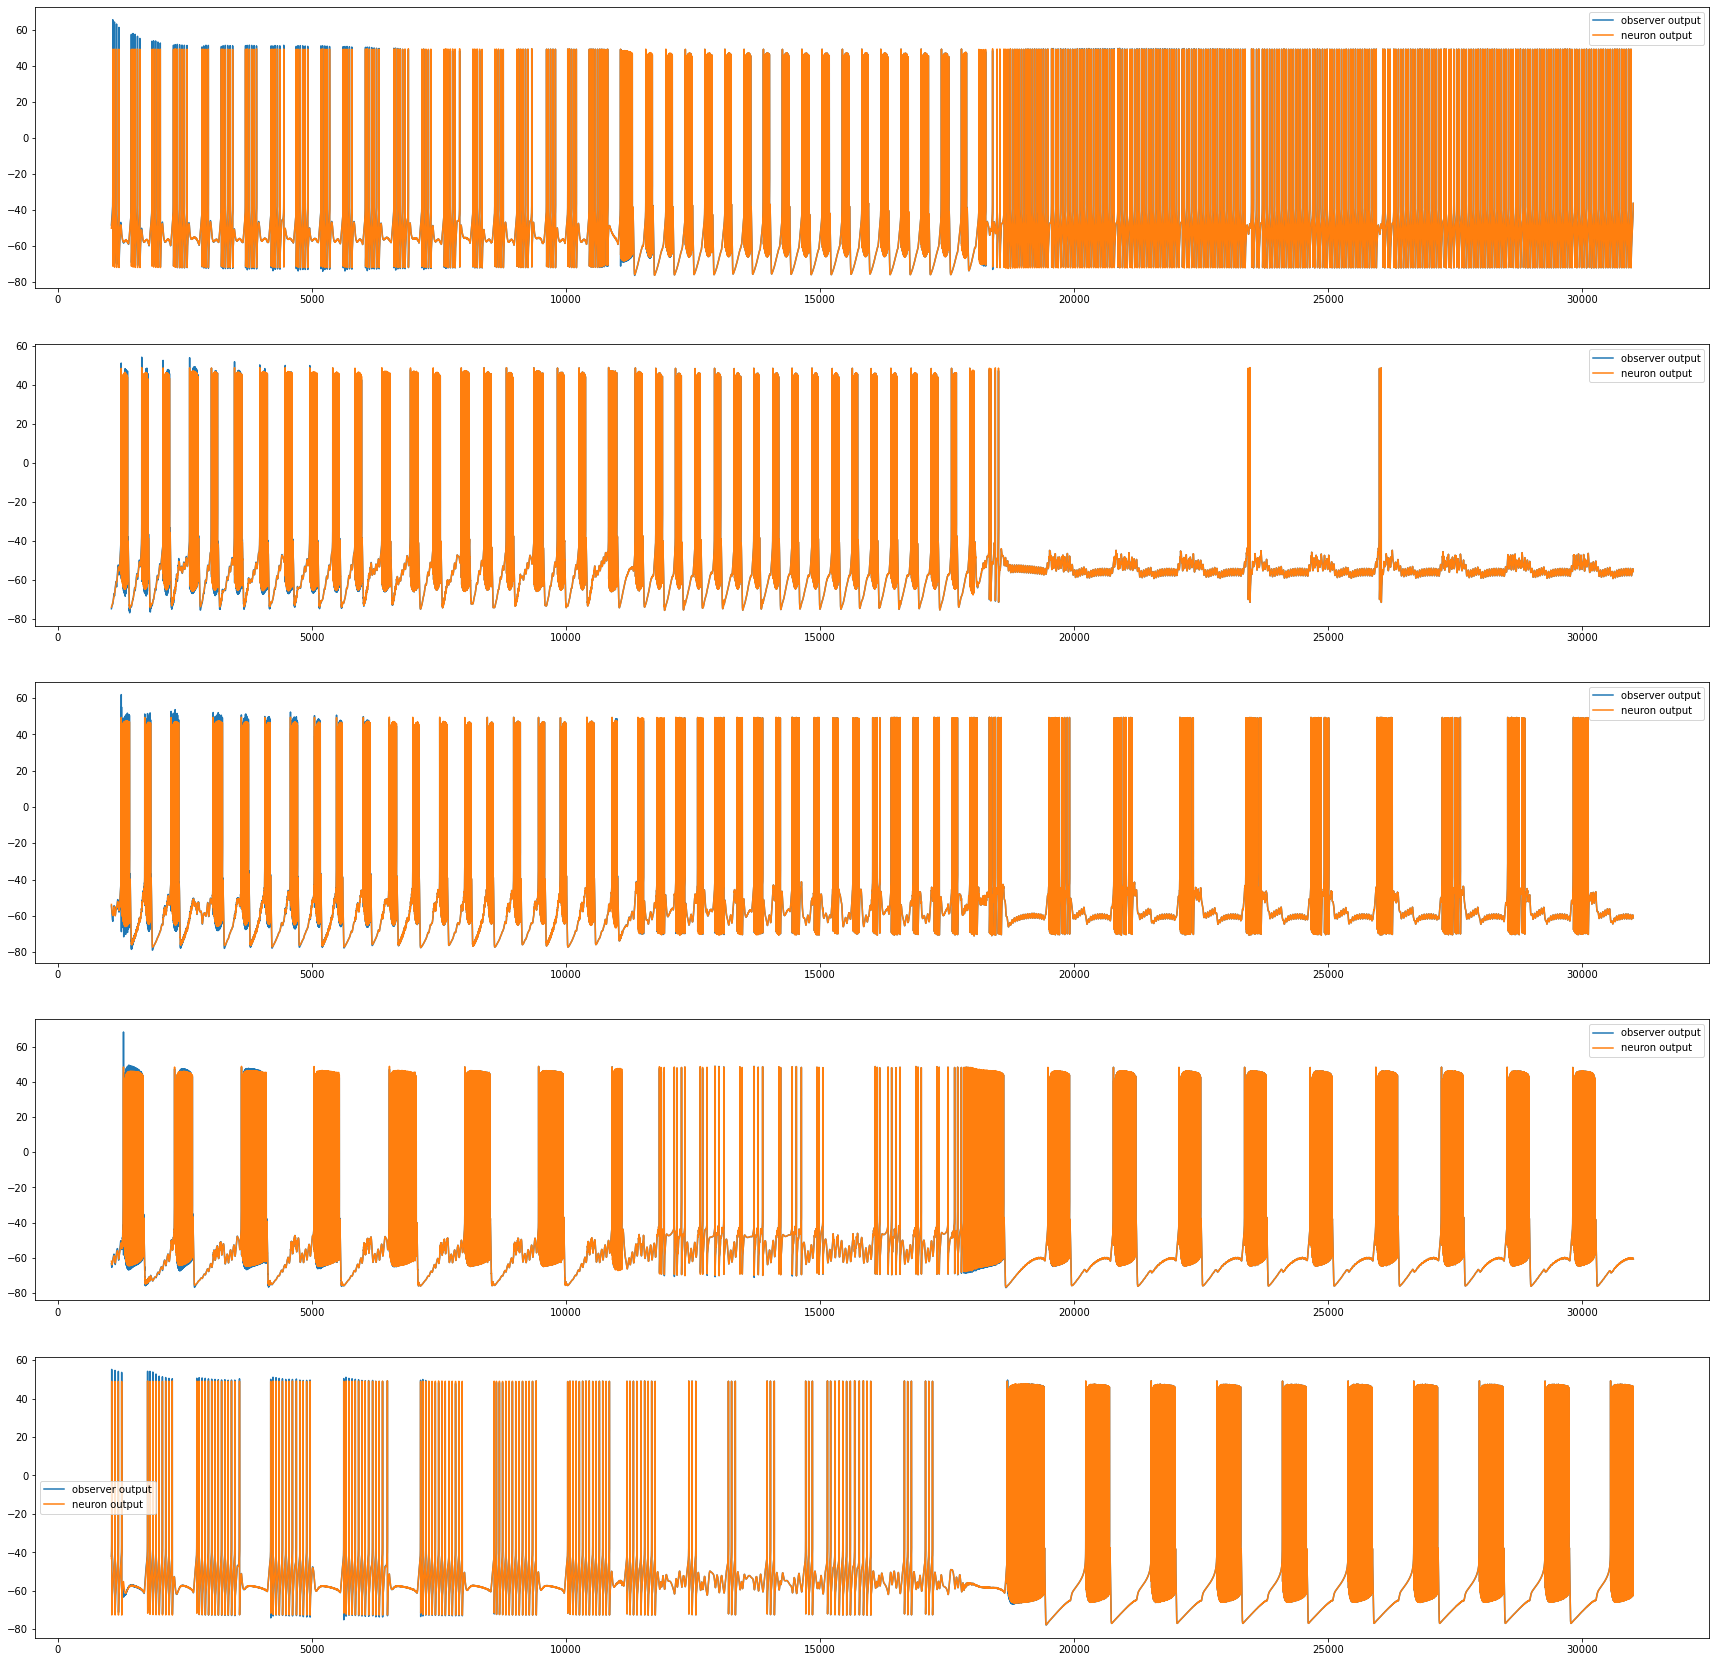

In [49]:
plot_fun(net7,sol9,origin=-3000)

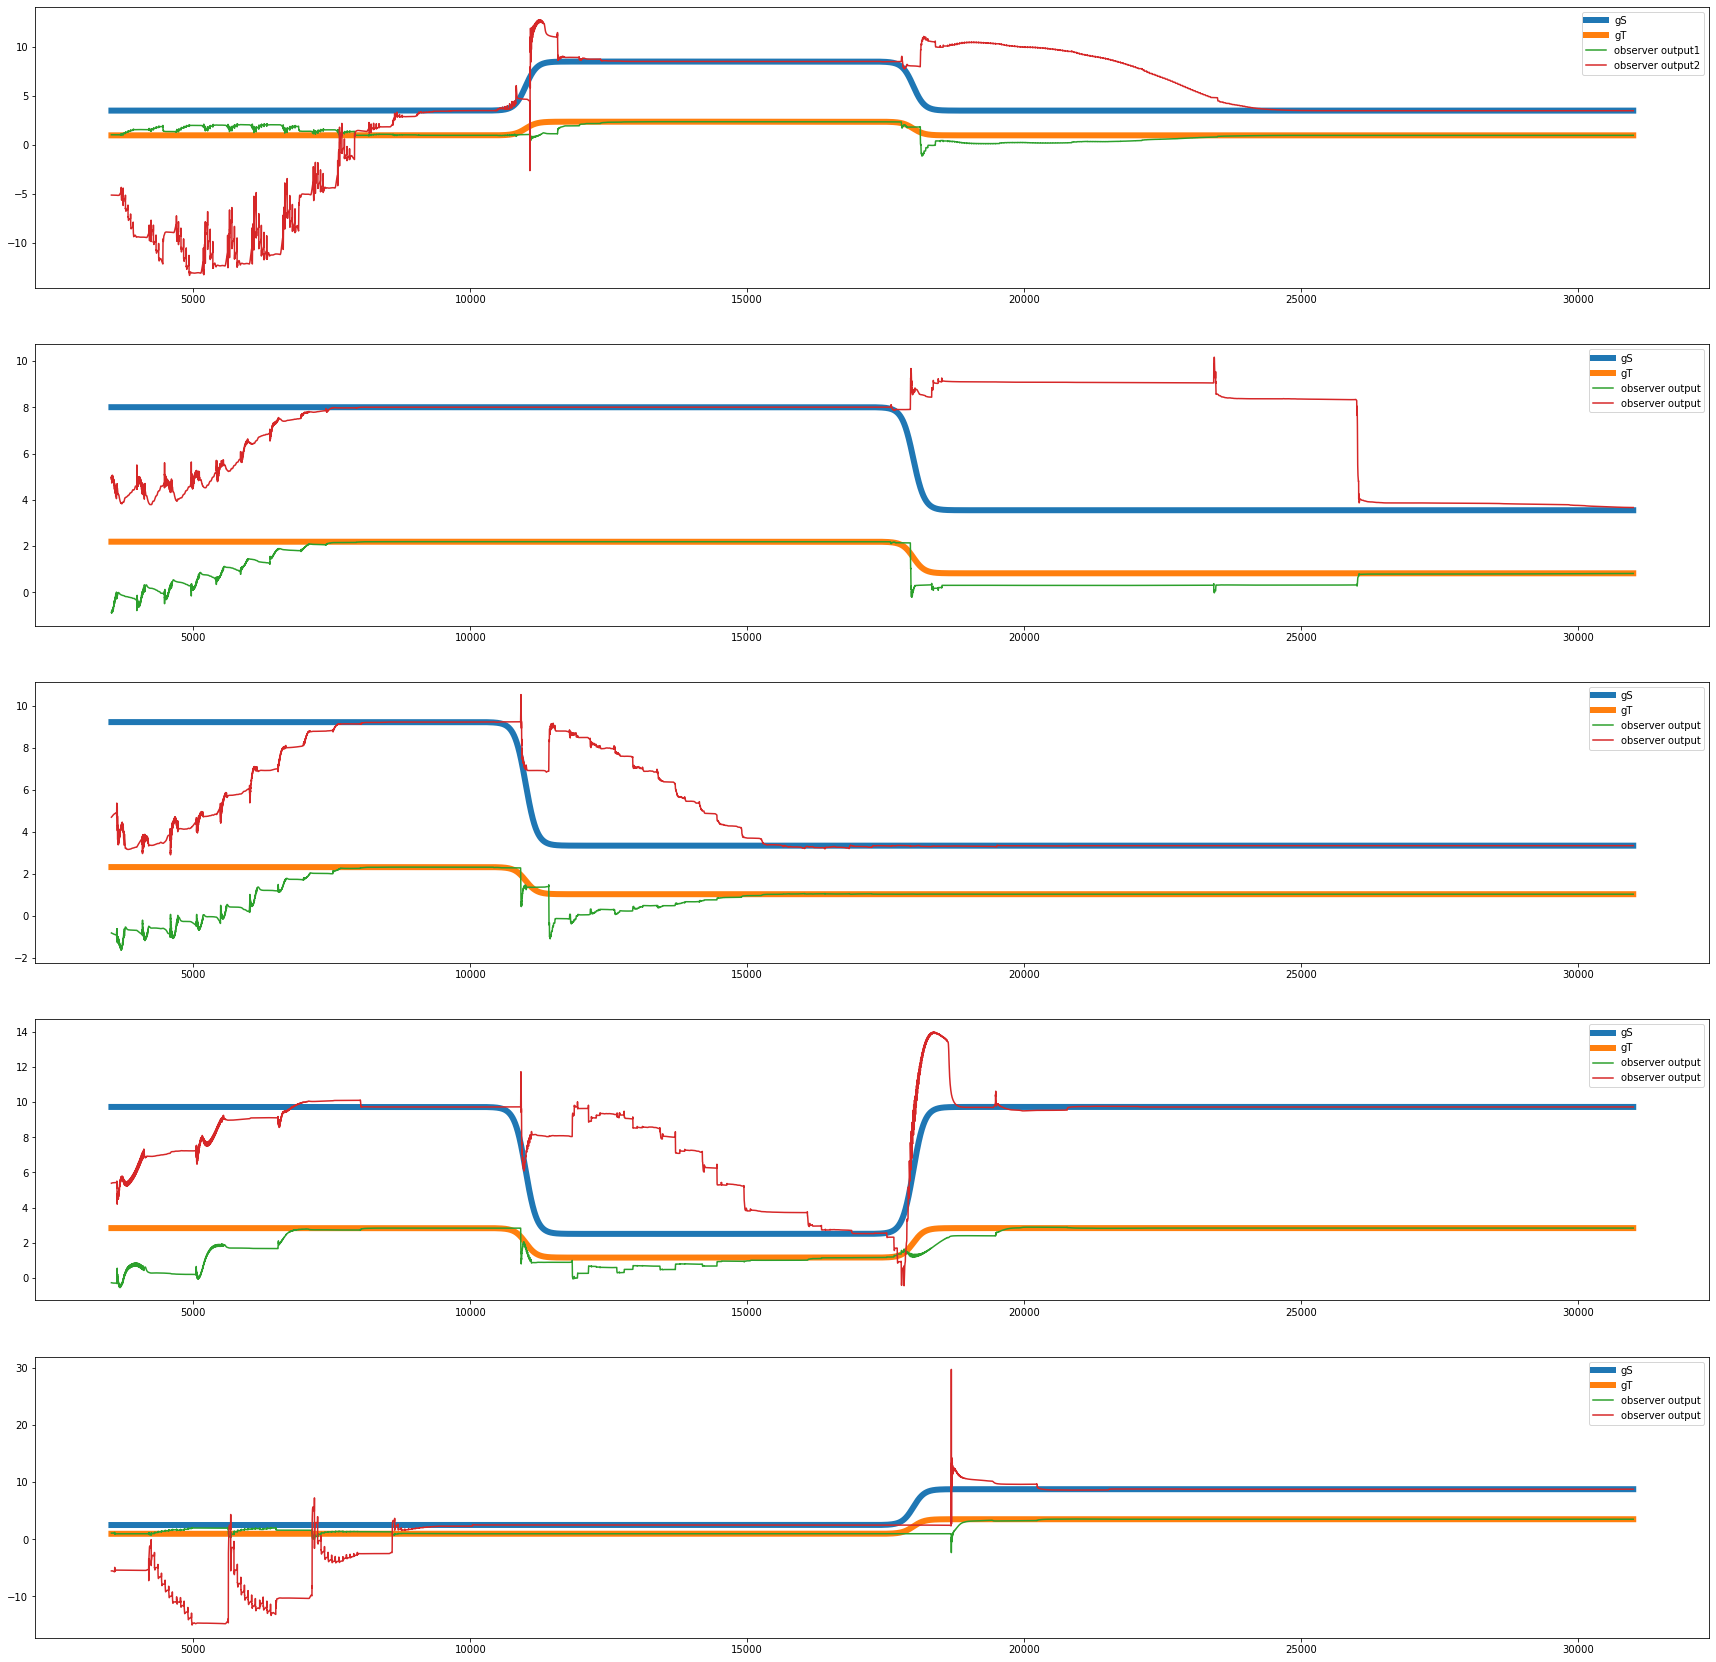

0.9947100368893157
0.8168252846299227
1.0495799999523425
2.829569959774487
3.525740016710866


In [50]:
plot_fun2(net7,sol9,fgS,fgT,origin=-3000)

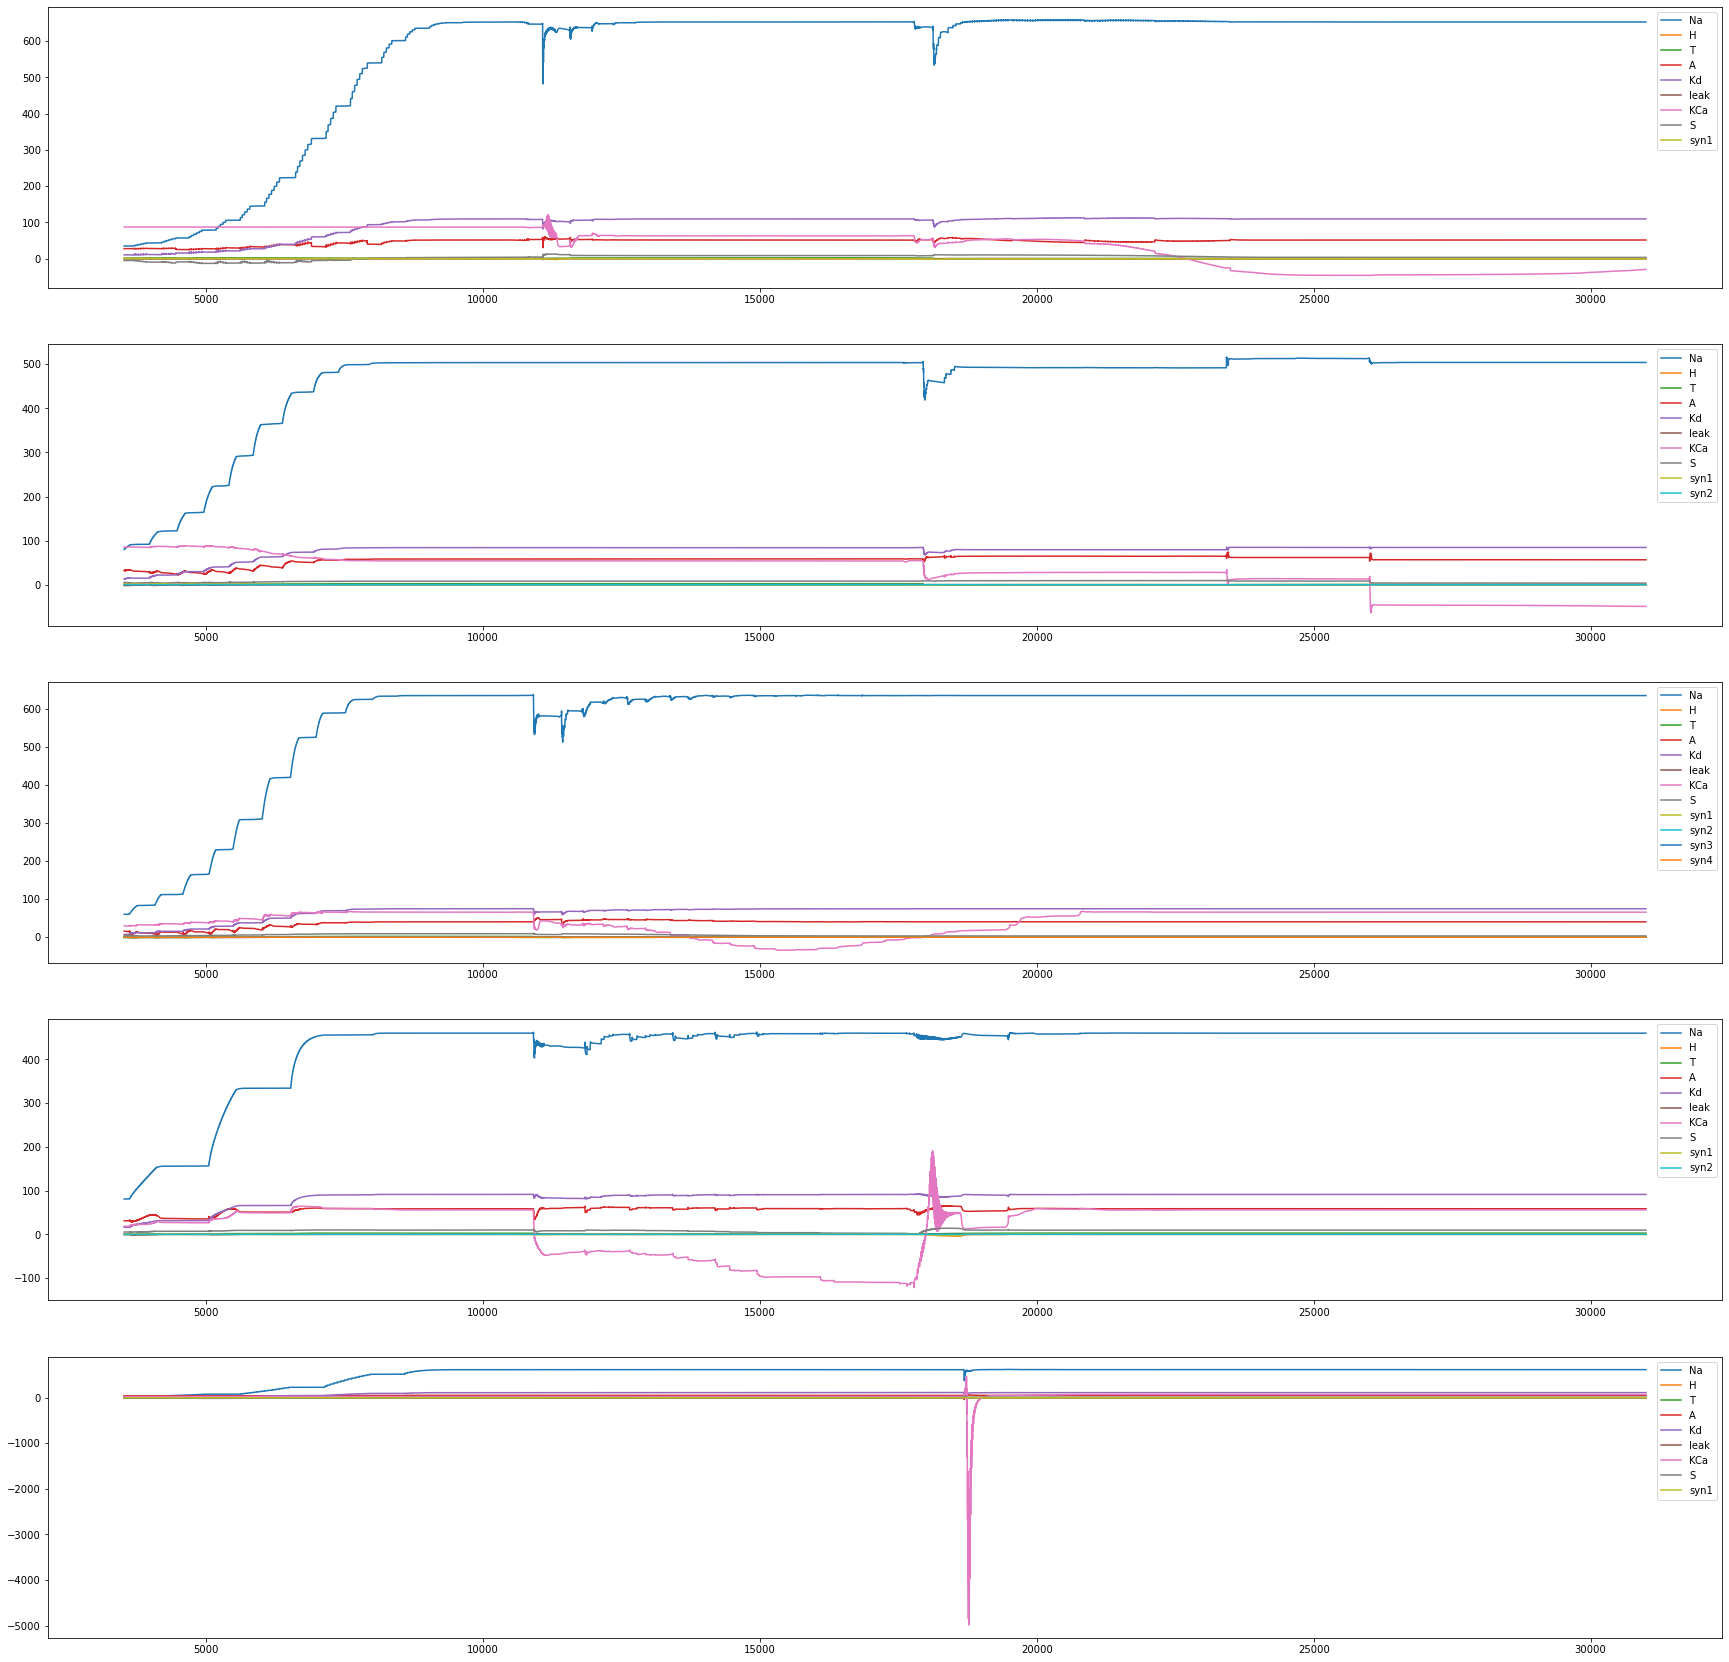

In [52]:
plot_fun3(net7,sol9,origin=-3000)

In [53]:
net8=random_MOD_V([0.,1.,1.,1.,0.])
gamma=10.
alpha=0.001
net8.set_mod(fgS,fgT)
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net8.cells[0].set_hyp(gamma,alpha,variable_mask1)
net8.cells[1].set_hyp(gamma,alpha,variable_mask2)
net8.cells[2].set_hyp(gamma,alpha,variable_mask3)
net8.cells[3].set_hyp(gamma,alpha,variable_mask2)
net8.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=[*net8.cells[0].init_cond_OB(-60+5),*net8.cells[1].init_cond_OB(-60-5),*net8.cells[2].init_cond_OB(-61),*net8.cells[3].init_cond_OB(-60-2),*net8.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.


num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.52814000e+02 1.07445000e-01 4.58872054e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 6.40231188e+01
 7.71695119e-02]
[-44.70024022]
[5.03580000e+02 9.29811000e-02 4.24283239e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 4.69285280e+01
 7.63508367e-02 2.10839169e-02]
[-49.72021204]
[6.34723000e+02 7.81820000e-02 6.98037272e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 5.88501216e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-44.56389316]
[4.59807000e+02 8.34140000e-02 5.02831714e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 2.98102133e+01
 1.17123333e-01 2.28748603e-02]
[-99.76680055]
[6.16433000e+02 8.87343000e-02 1.67346947e+00 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 9.55994160e+01
 7.

In [54]:
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol10=solve_ivp(net8.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 456.7903332710266


In [55]:
file_sol10= open('sol10.data','wb') 
pickle.dump(sol10, file_sol10)
file_sol10.close()

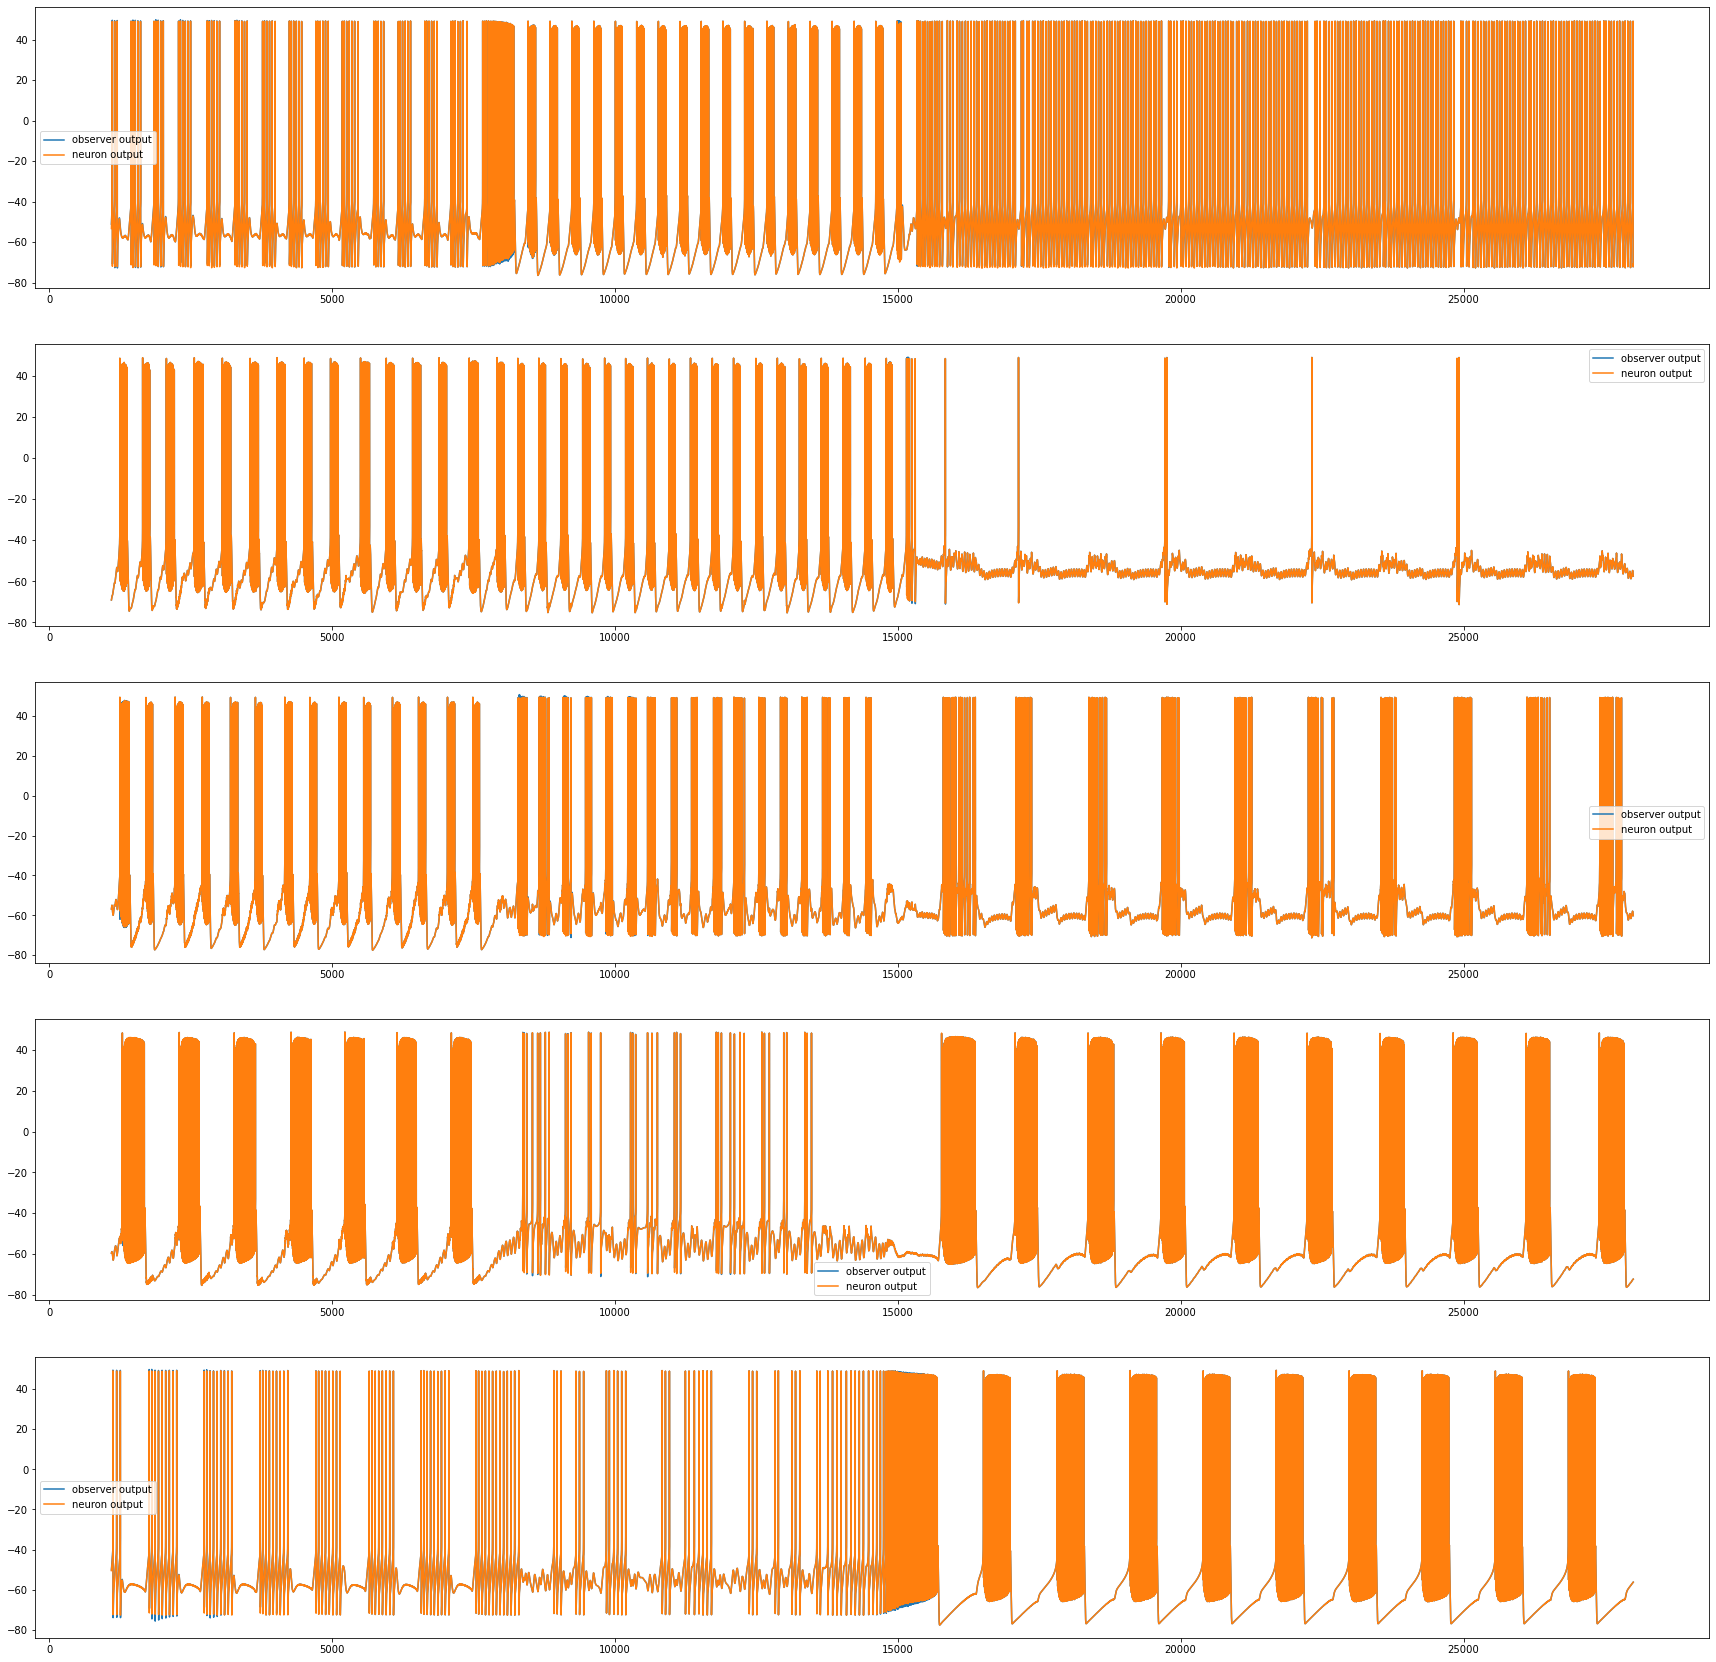

In [56]:
plot_fun(net8,sol10)

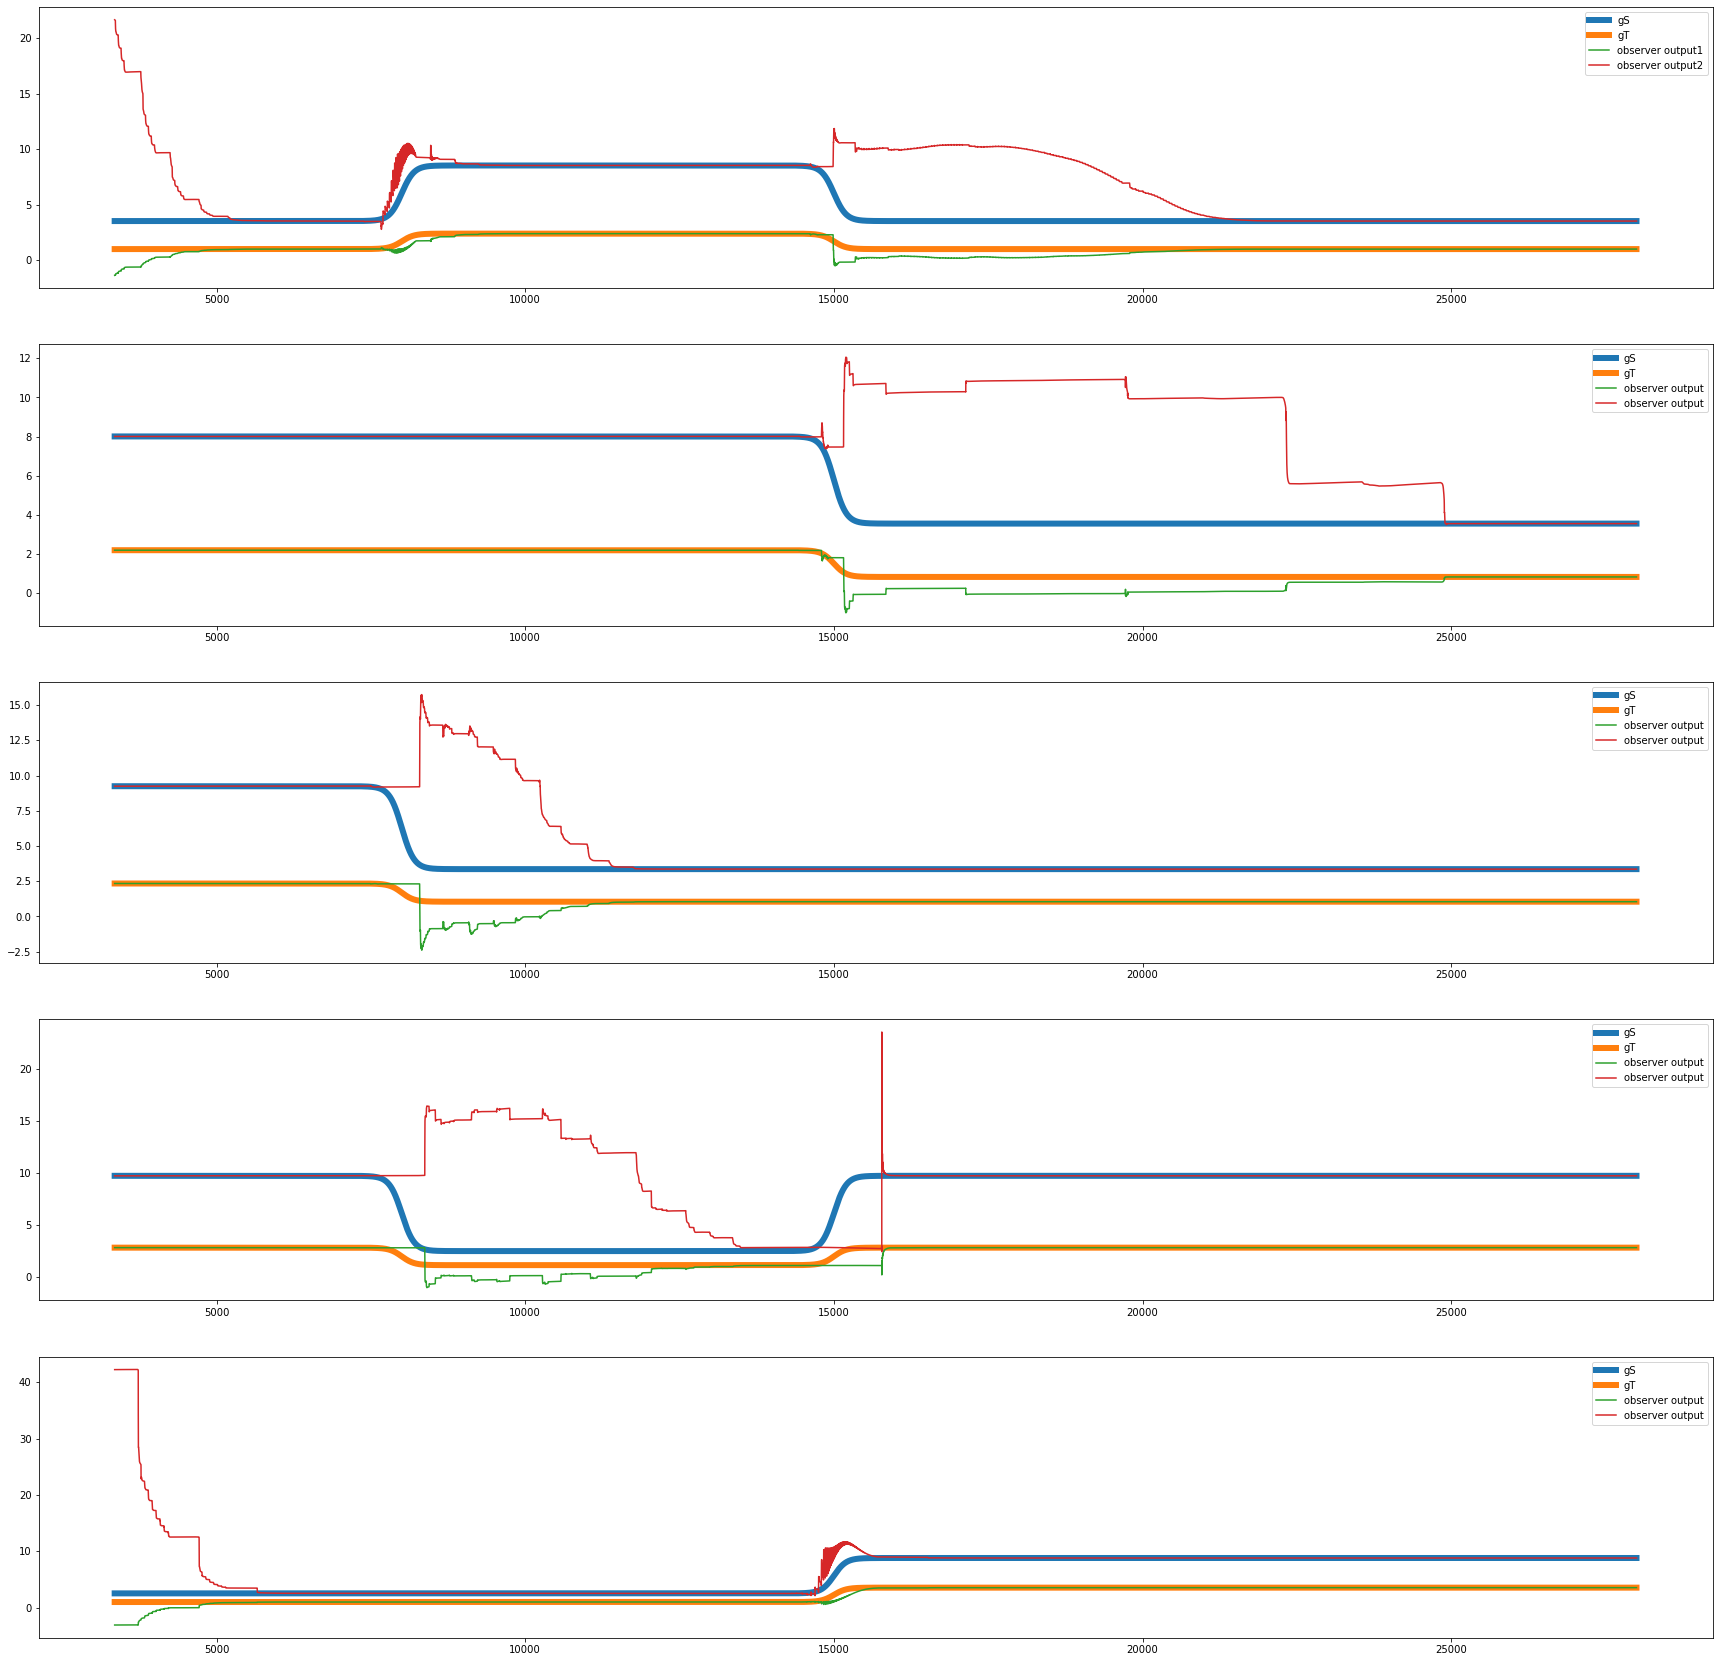

0.9928840000000181
0.8248148016486485
1.049580000000001
2.829569999950978
3.525740000651406


In [57]:
plot_fun2(net8,sol10)

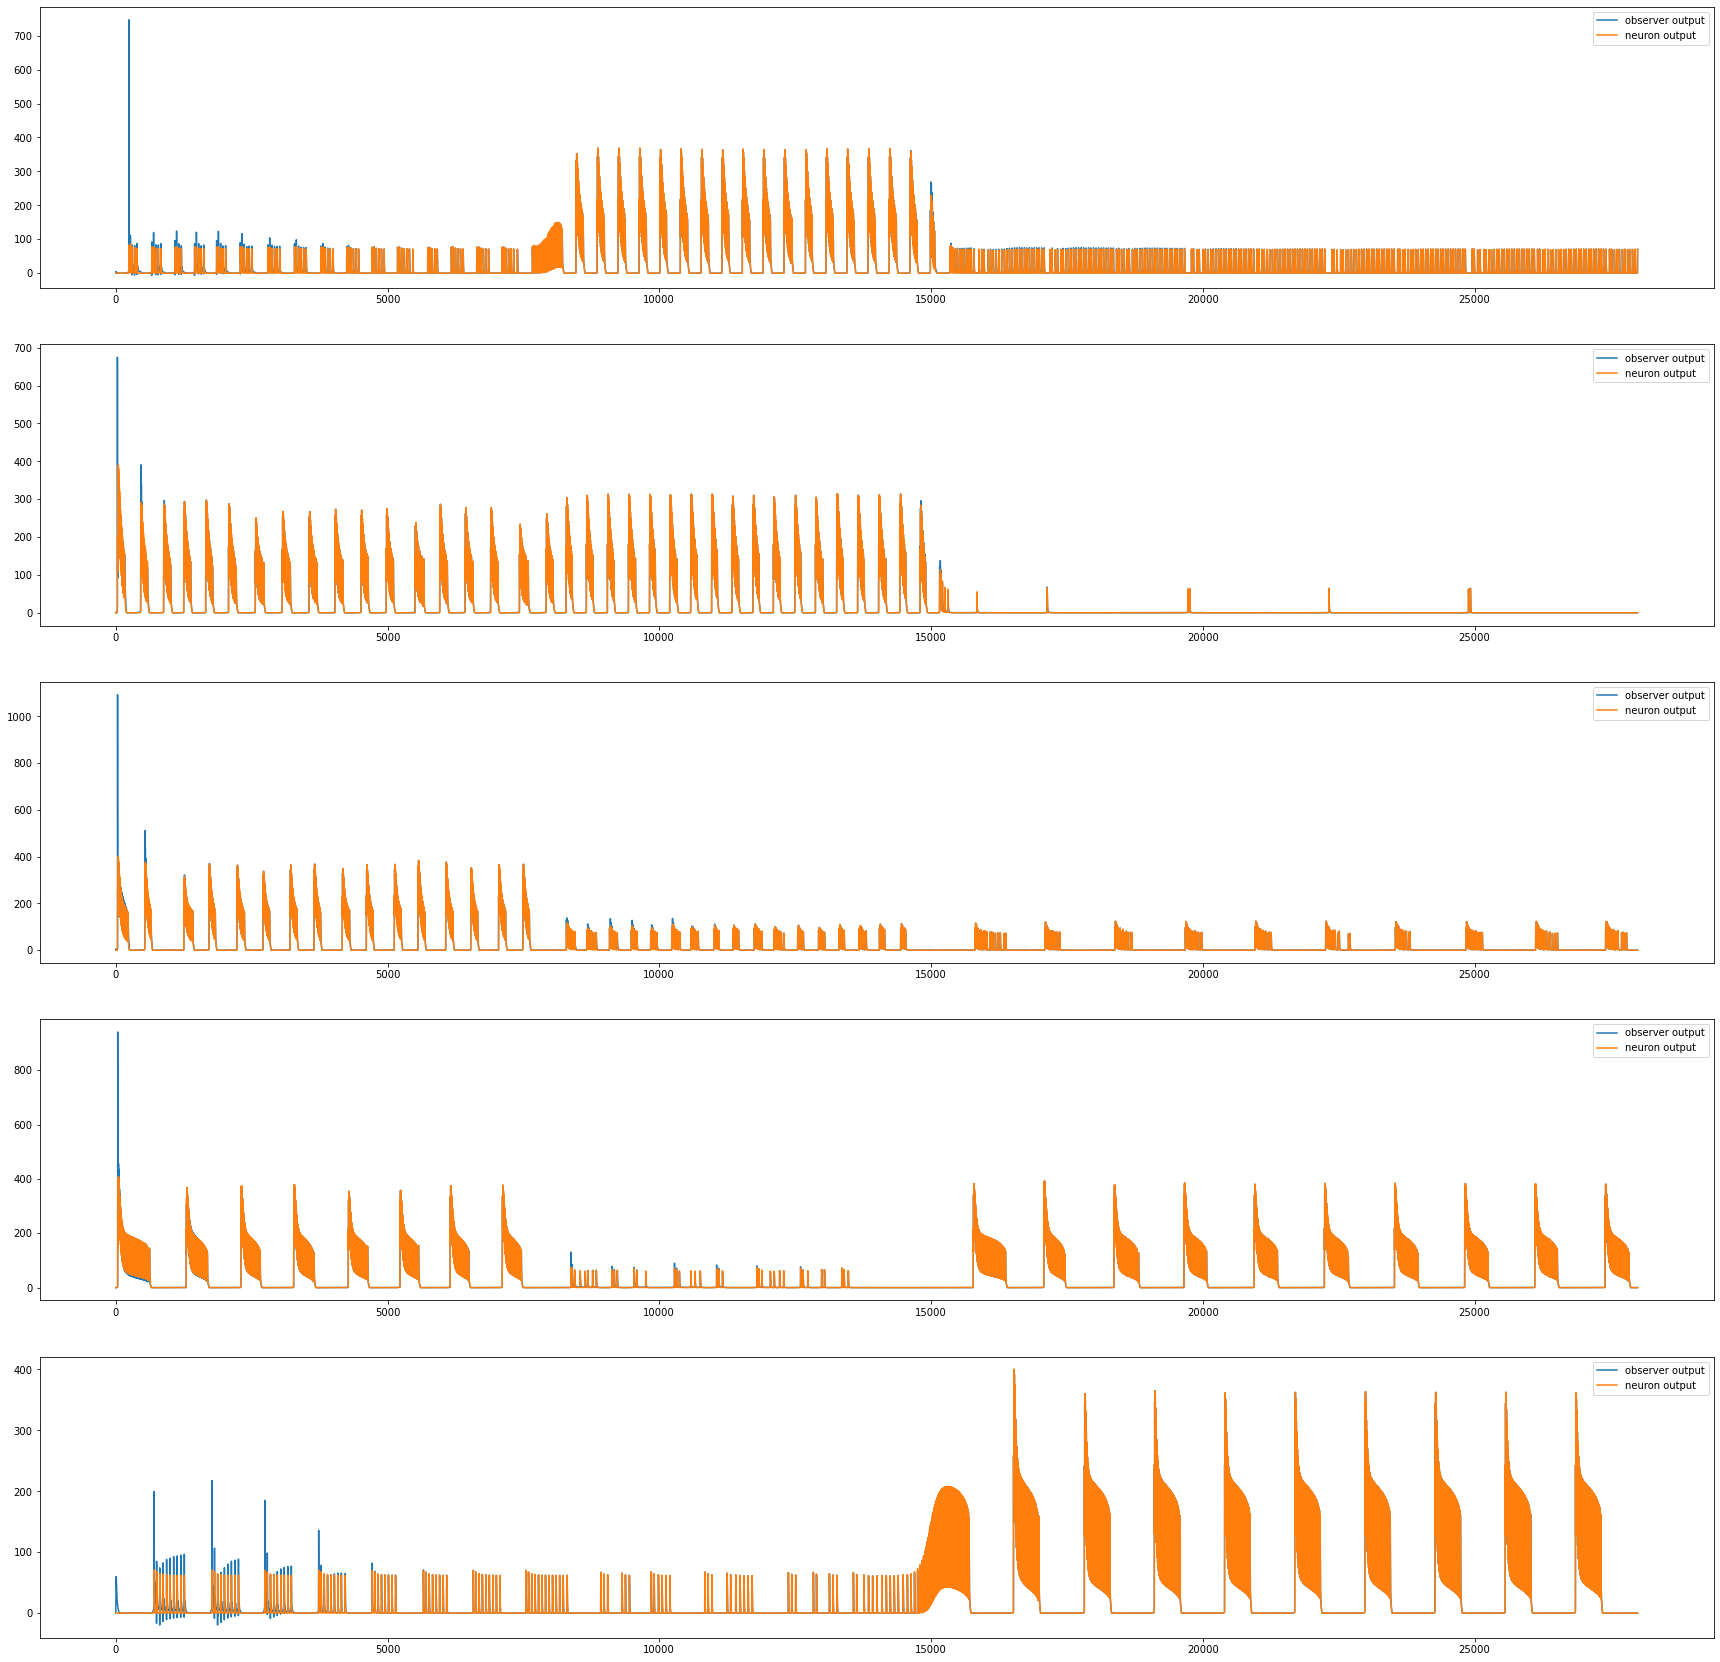

In [58]:
plot_fun1(net8,sol10)

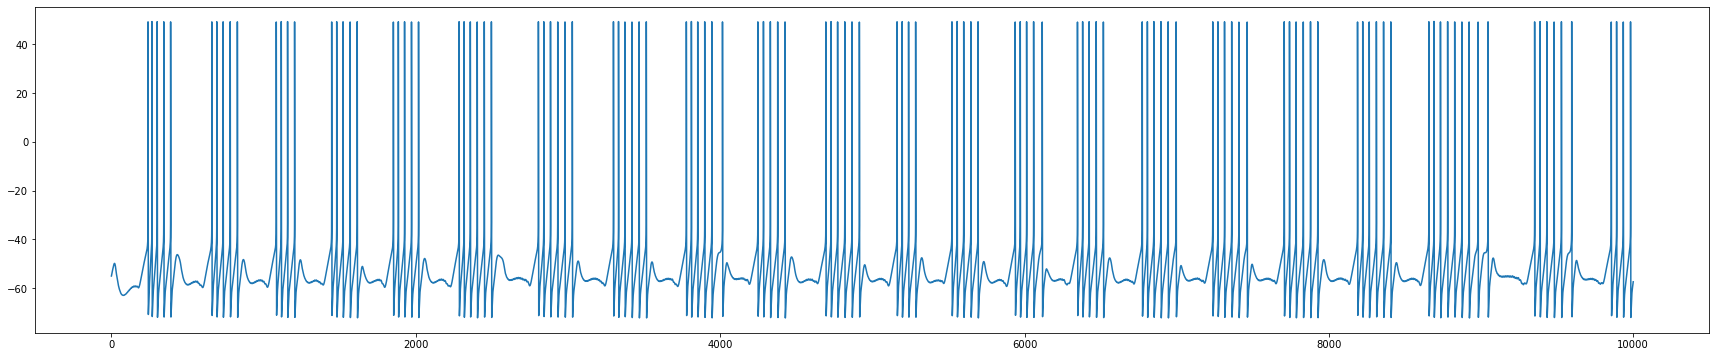

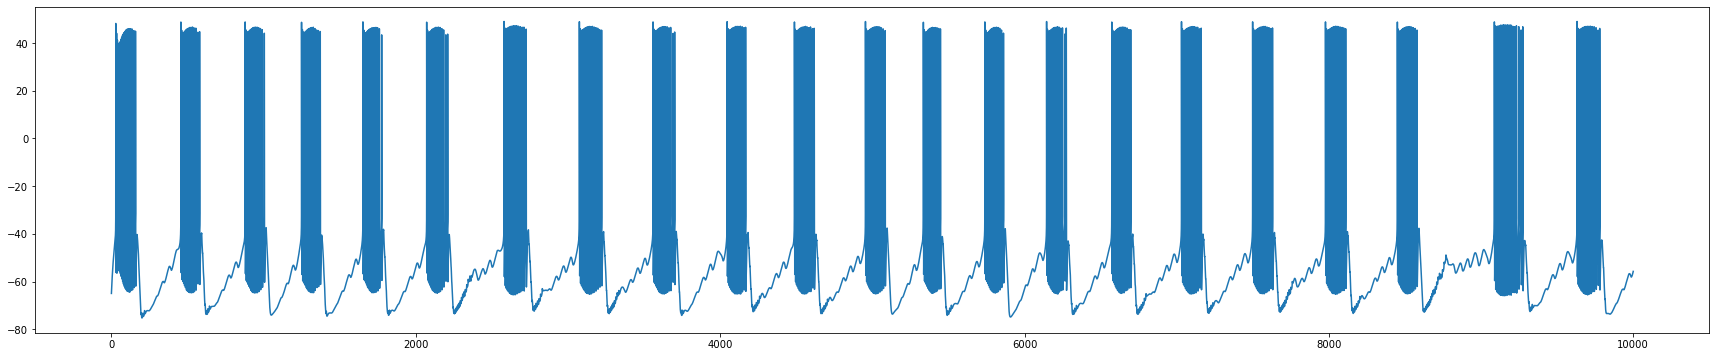

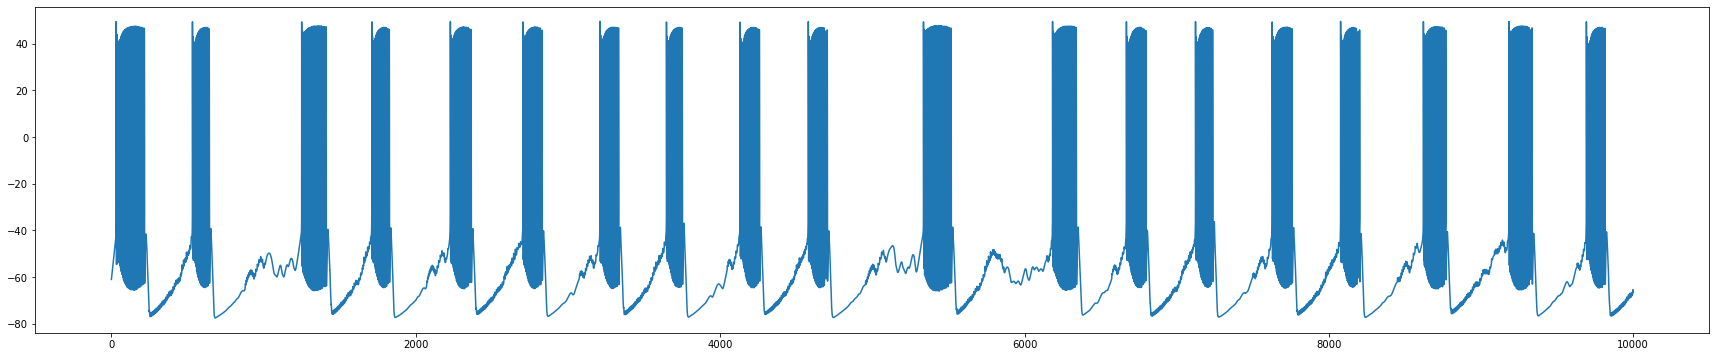

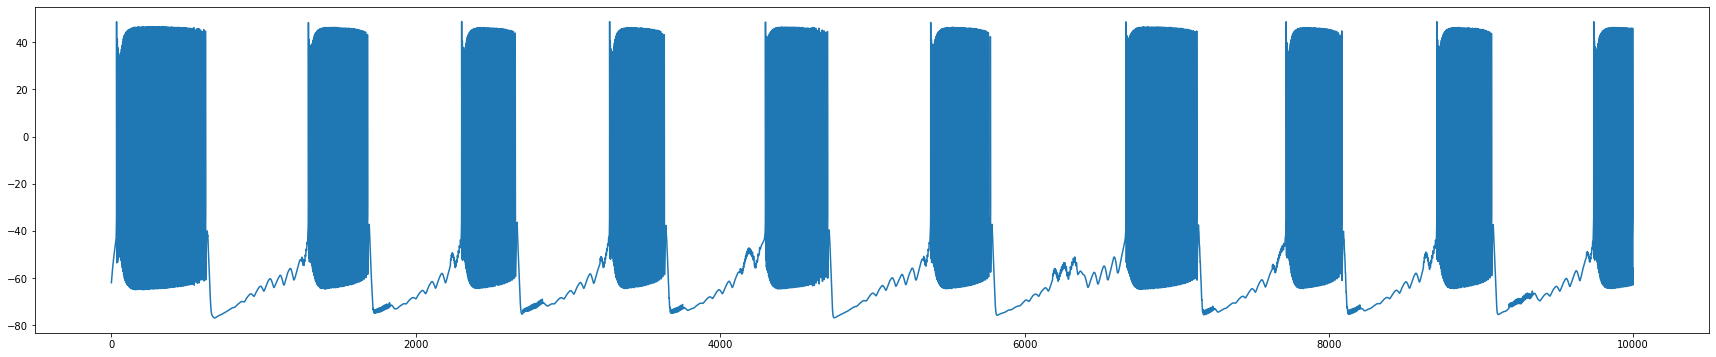

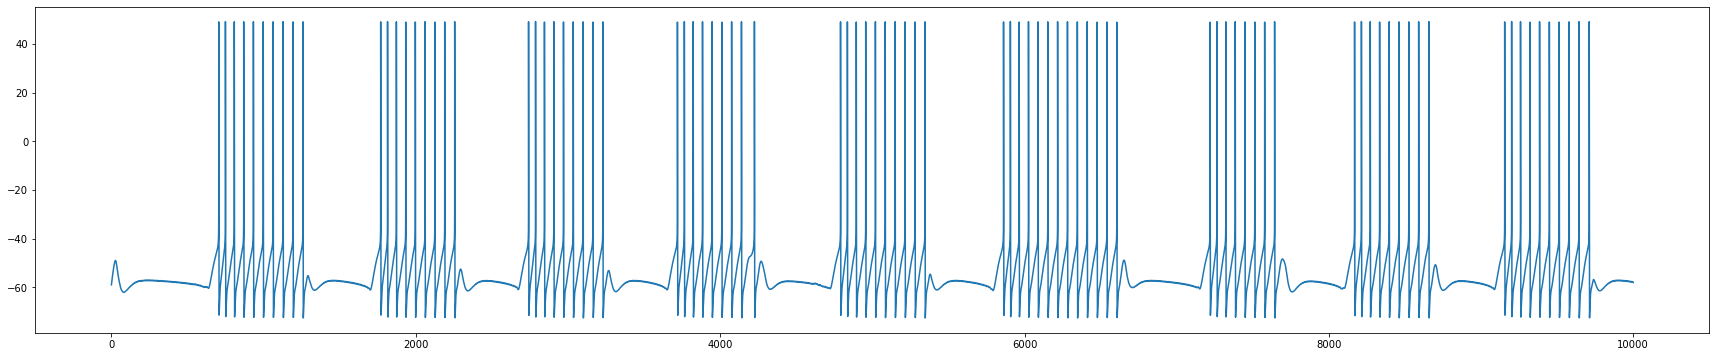

In [10]:
fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[0])


fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[net7.cells[0].pos_dinamics])



fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[net7.cells[0].pos_dinamics+net7.cells[1].pos_dinamics])



fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[net7.cells[0].pos_dinamics+net7.cells[1].pos_dinamics+net7.cells[2].pos_dinamics])



fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[net7.cells[0].pos_dinamics+net7.cells[1].pos_dinamics+net7.cells[2].pos_dinamics+net7.cells[3].pos_dinamics])



In [59]:
net1=random_MOD([0.,1.,1.,1.,0.])
net1.set_mod(fgS,fgT)
X0=[*net1.cells[0].init_cond(-60+5),*net1.cells[1].init_cond(-60-5),*net1.cells[2].init_cond(-61),*net1.cells[3].init_cond(-60-2),*net1.cells[4].init_cond(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
Elapsed (with compilation) = 190.0325527191162


In [60]:
file_sol= open('sol.data','wb') 
pickle.dump(sol, file_sol)
file_sol.close()

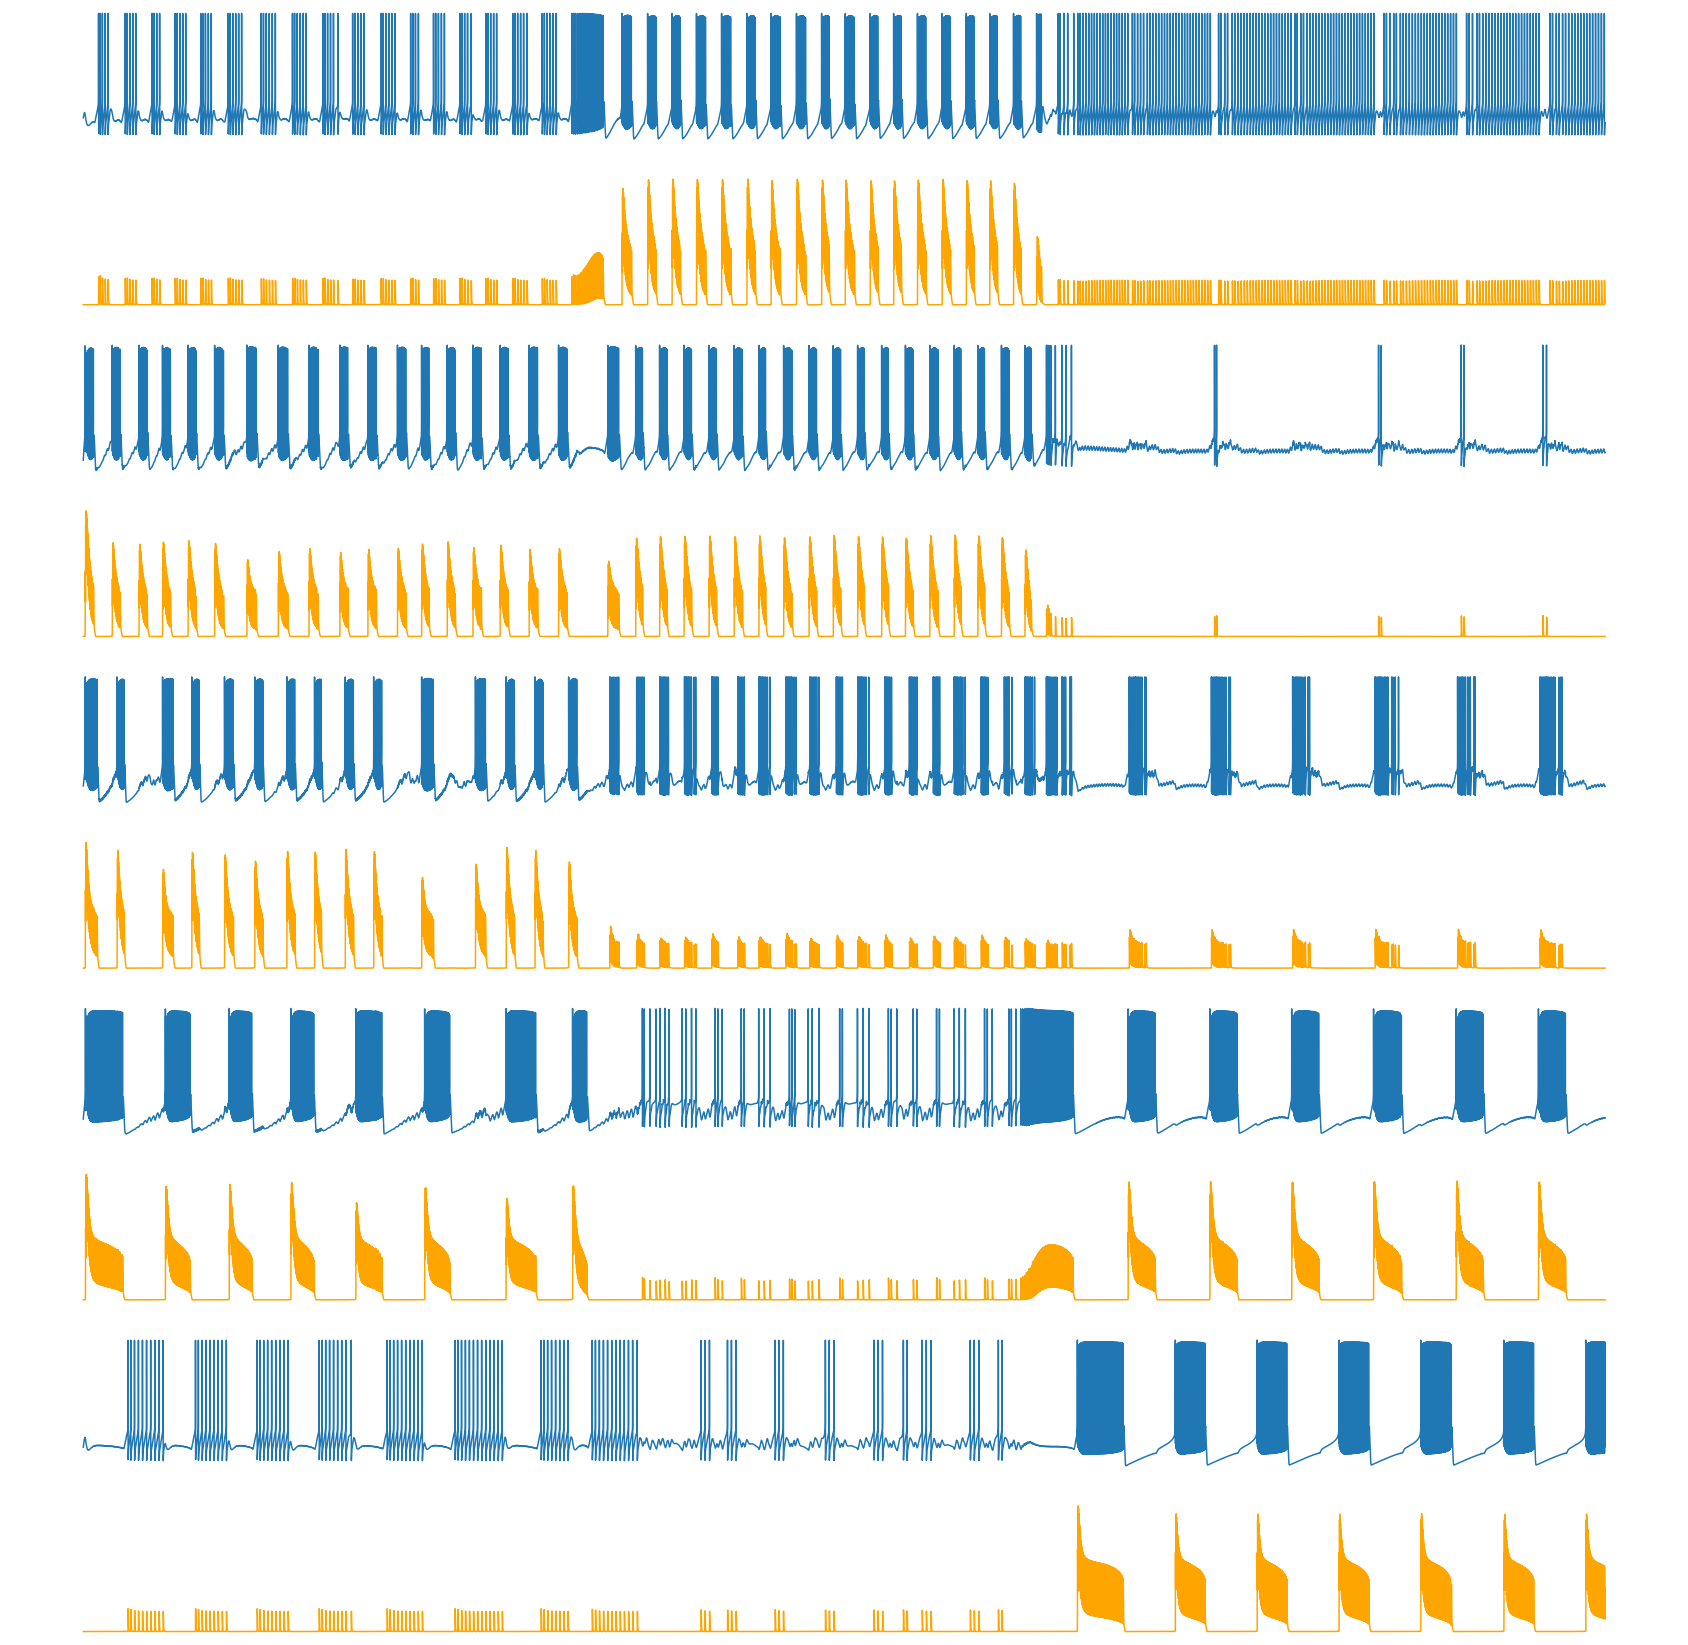

In [52]:
fig=plt.figure(figsize=(30, 30))
plt.subplot(10, 1, 1)
plt.plot(sol.t, sol.y[0])
plt.axis('off')

plt.subplot(10, 1, 2)
plt.plot(sol.t, sol.y[12],'orange')
plt.axis('off')

plt.subplot(10, 1, 3)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics])
plt.axis('off')

plt.subplot(10, 1, 4)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+12],'orange')
plt.axis('off')

plt.subplot(10, 1, 5)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.axis('off')

plt.subplot(10, 1, 6)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+12],'orange')
plt.axis('off')

plt.subplot(10, 1, 7)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.axis('off')

plt.subplot(10, 1, 8)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+12],'orange')
plt.axis('off')

plt.subplot(10, 1, 9)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.axis('off')

plt.subplot(10, 1, 10)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics+12],'orange')
plt.axis('off')
fig.savefig('Ca_con.jpg')

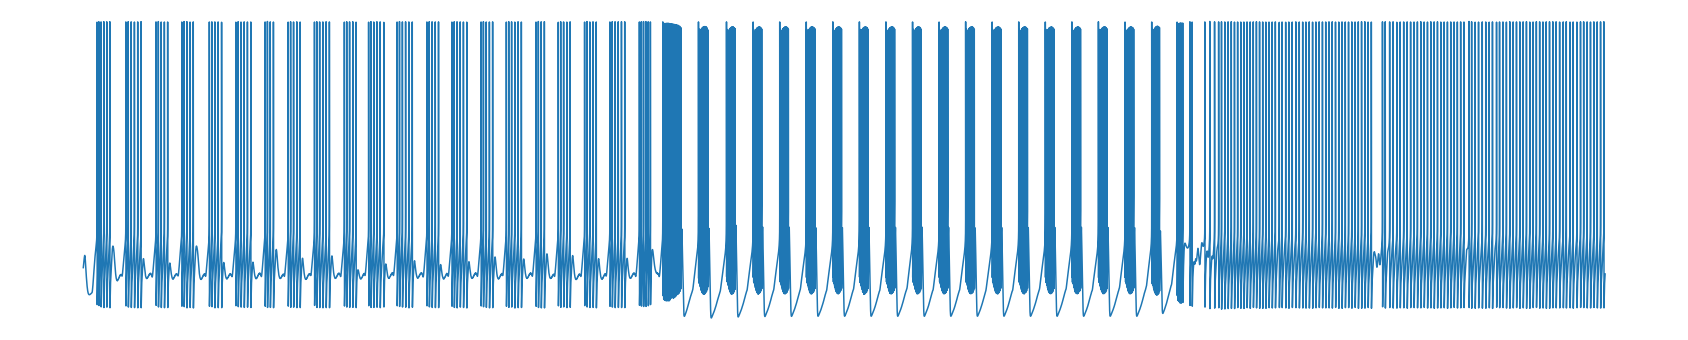

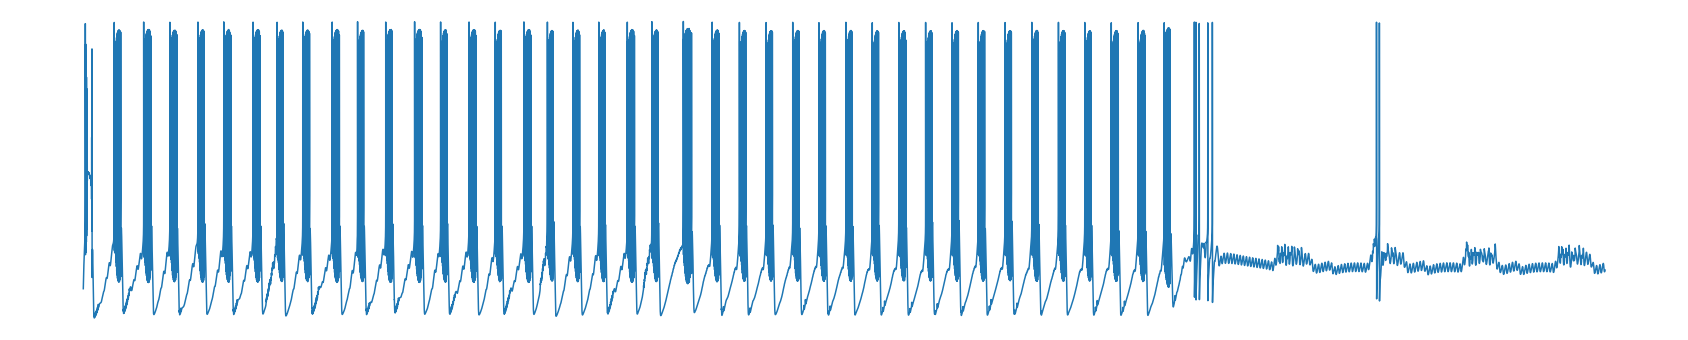

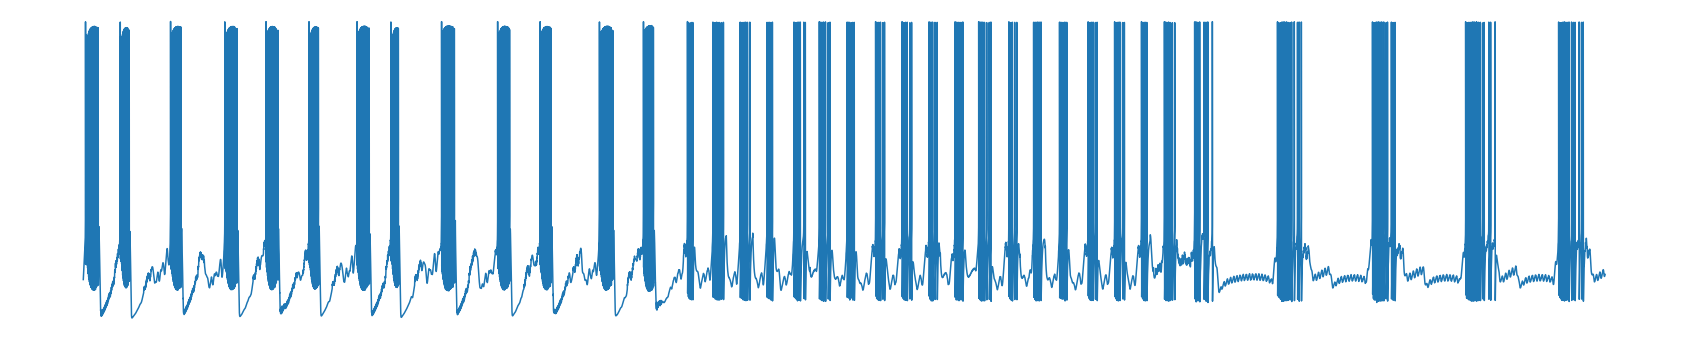

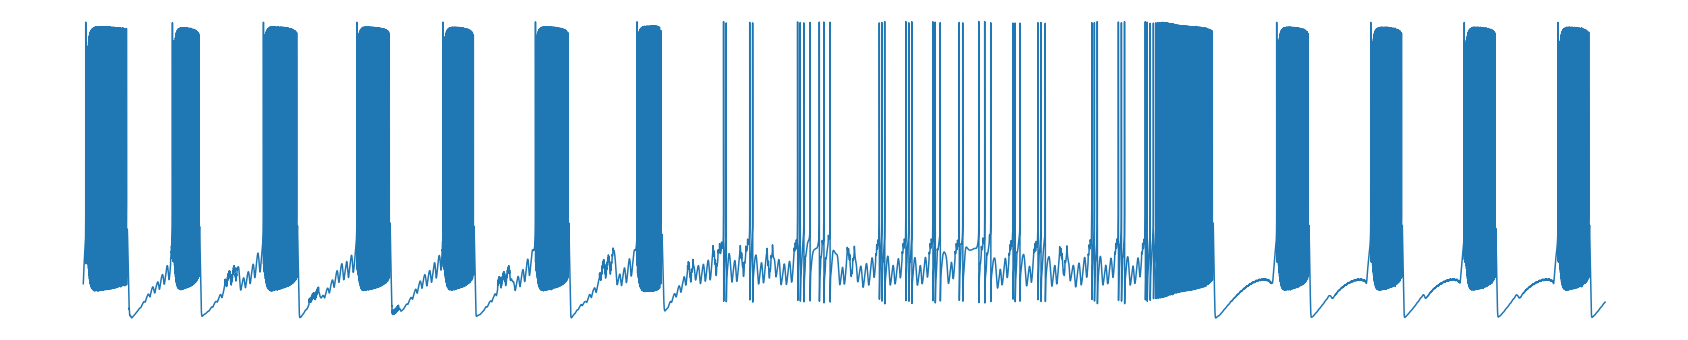

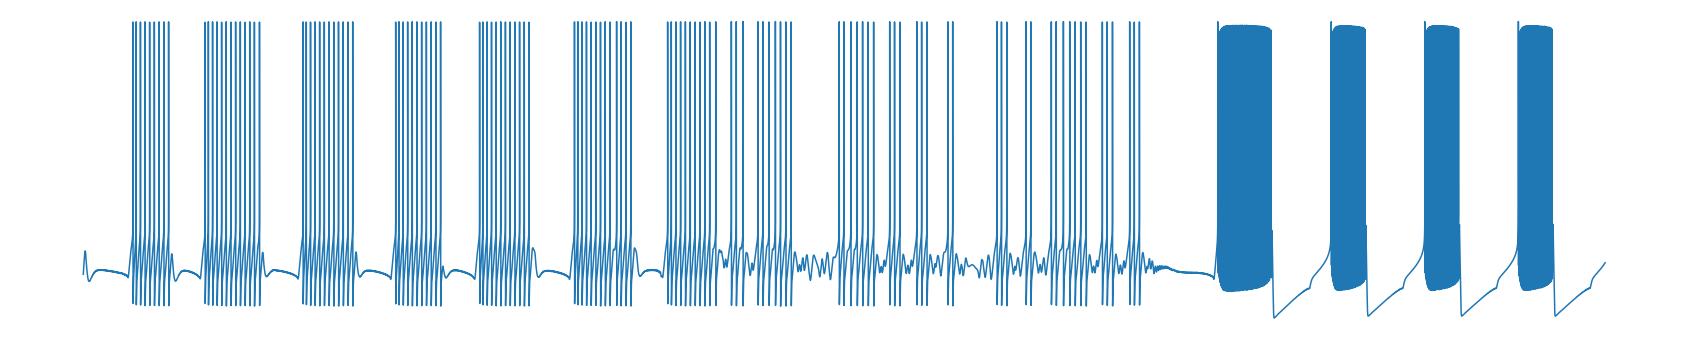

In [299]:
fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[0])
plt.axis('off')
fig.savefig('STG1.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics])
plt.axis('off')
fig.savefig('STG2.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.axis('off')
fig.savefig('STG3.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.axis('off')
fig.savefig('STG4.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.axis('off')
fig.savefig('STG5.jpg')


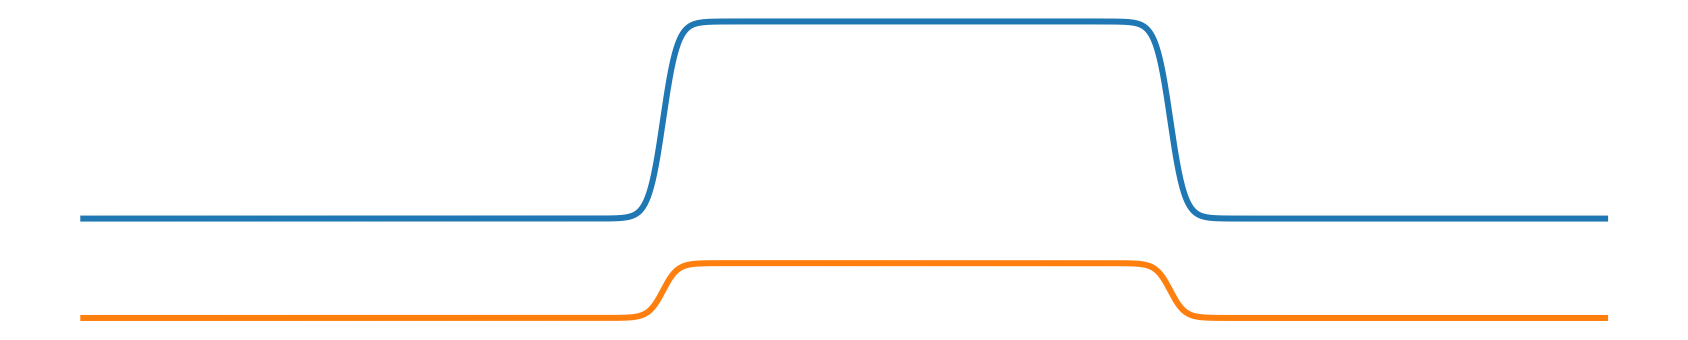

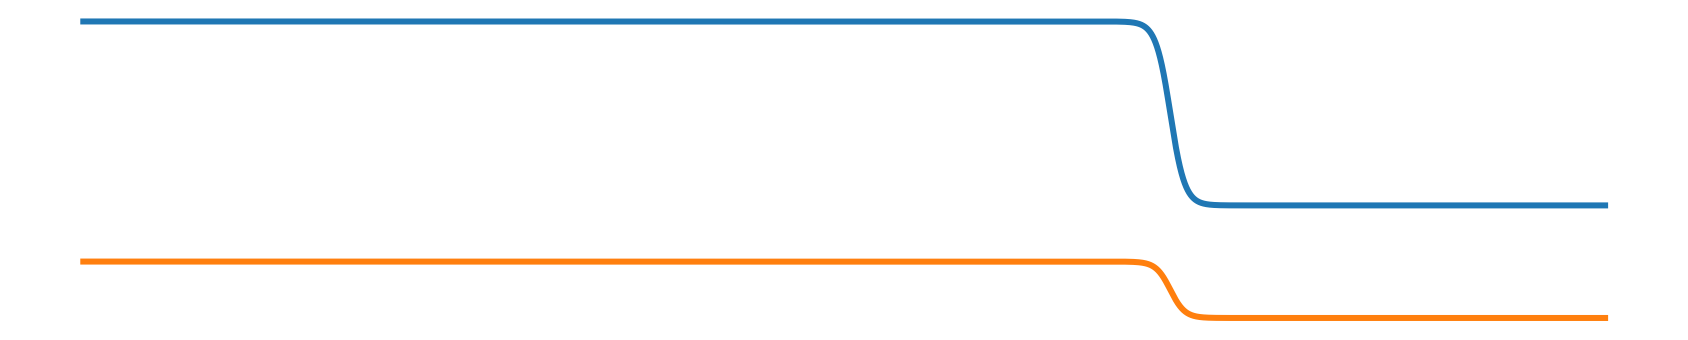

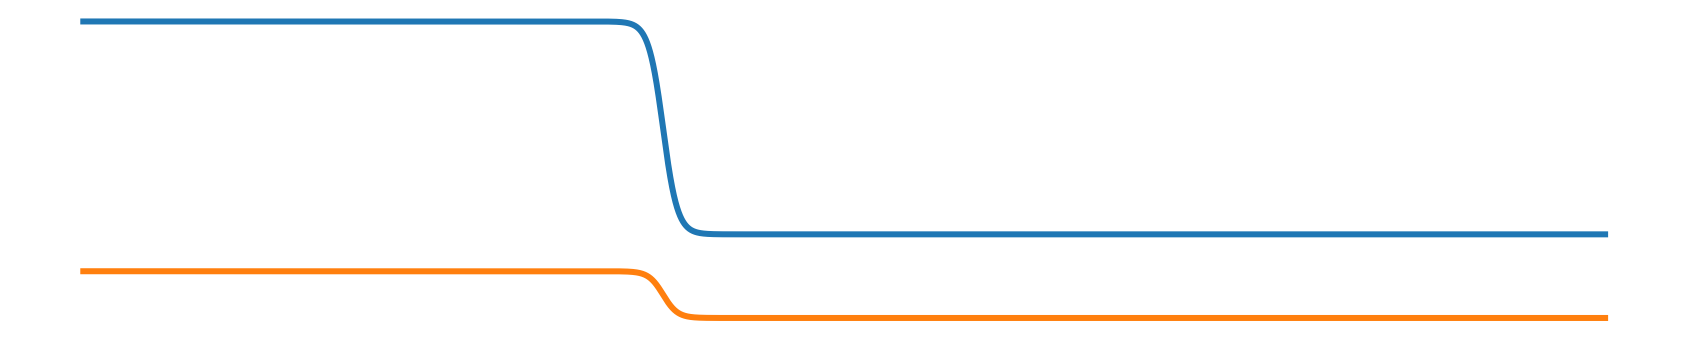

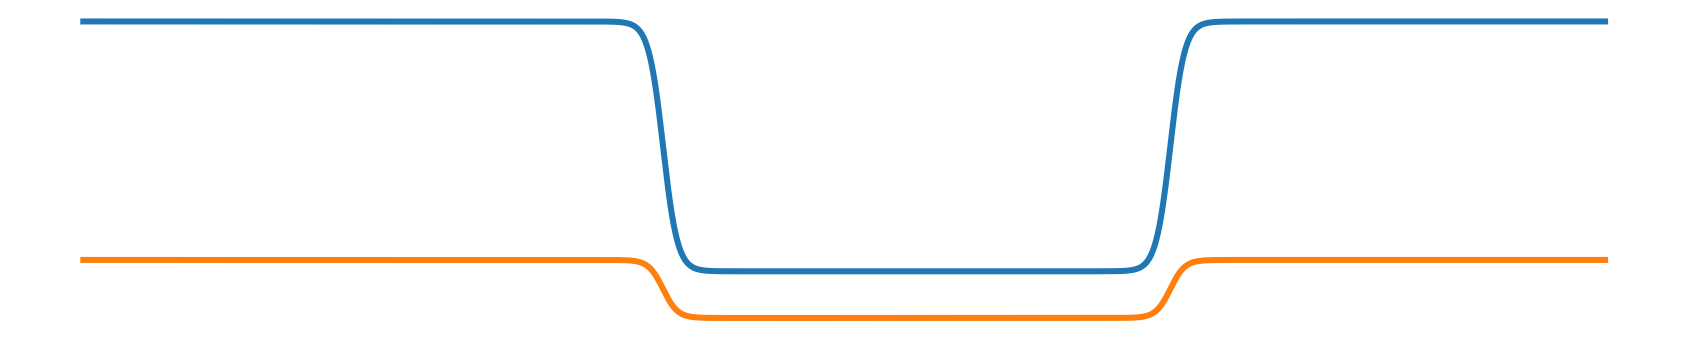

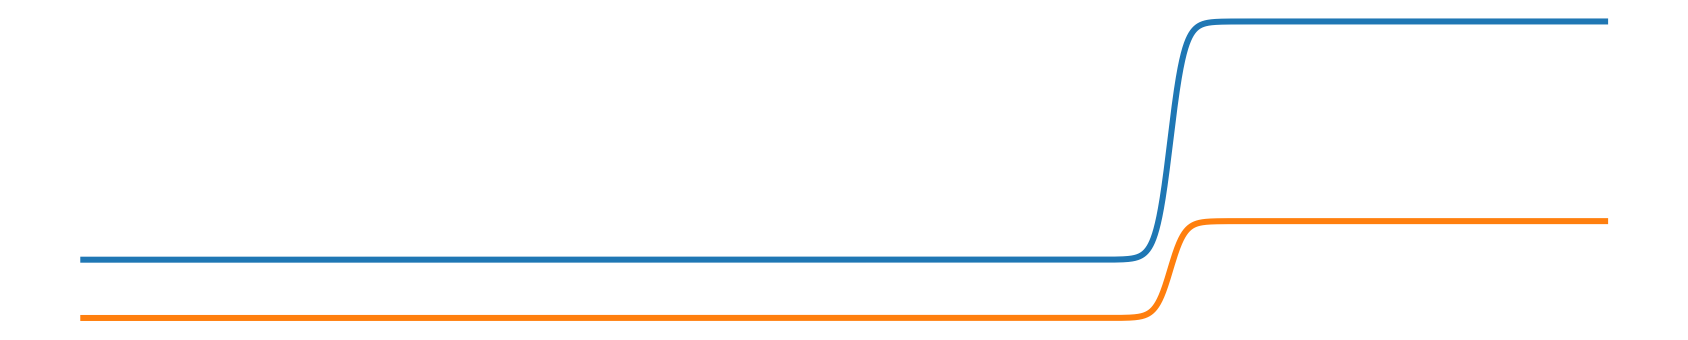

In [304]:
fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[0],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[0],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG1_c.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[1],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[1],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG2_c.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[2],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[2],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG3_c.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[3],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[3],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG4_c.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[4],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[4],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG5_c.jpg')

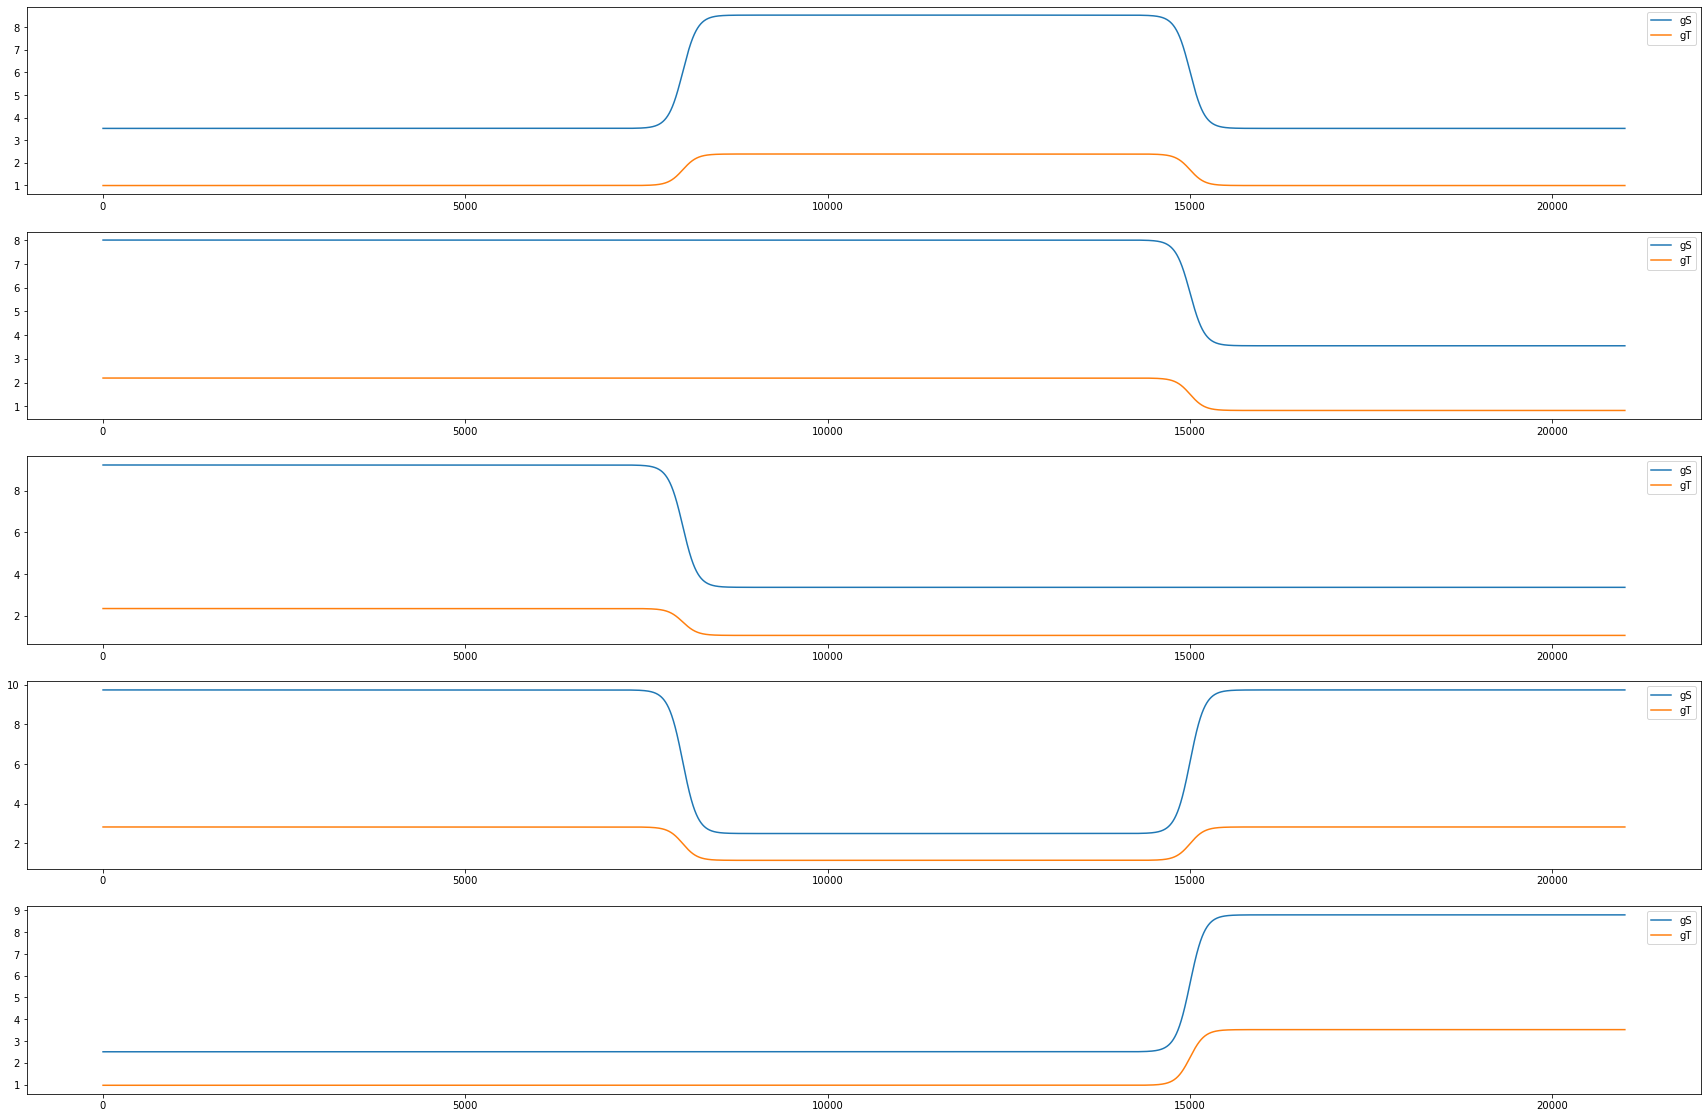

In [291]:
fgS_array=[[fgS(j,i) for i in sol.t]for j in range(5)]
fgT_array=[[fgT(j,i) for i in sol.t]for j in range(5)]
plt.figure(figsize=(30, 20))
plt.subplot(5, 1, 1)
plt.plot(sol.t,fgS_array[0],label='gS')
plt.plot(sol.t,fgT_array[0],label='gT')
plt.legend()
plt.subplot(5, 1, 2)
plt.plot(sol.t,fgS_array[1],label='gS')
plt.plot(sol.t,fgT_array[1],label='gT')
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(sol.t,fgS_array[2],label='gS')
plt.plot(sol.t,fgT_array[2],label='gT')
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(sol.t,fgS_array[3],label='gS')
plt.plot(sol.t,fgT_array[3],label='gT')
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(sol.t,fgS_array[4],label='gS')
plt.plot(sol.t,fgT_array[4],label='gT')
plt.legend()
plt.show()


In [74]:
file_sol= open('sol.data','wb') 
pickle.dump(sol, file_sol)

In [30]:
net1=random_MOD([0.,1.,1.,1.,0.])
#Hyperparameters
net1.set_mod(fgS,fgT)
gamma=10.
alpha=0.001
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net1.cells[0].set_hyp(gamma,alpha,variable_mask1)
net1.cells[1].set_hyp(gamma,alpha,variable_mask2)
net1.cells[2].set_hyp(gamma,alpha,variable_mask3)
net1.cells[3].set_hyp(gamma,alpha,variable_mask2)
net1.cells[4].set_hyp(gamma,alpha,variable_mask1)

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [31]:
X0=[*net1.cells[0].init_cond_OB(-60+5),*net1.cells[1].init_cond_OB(-60-5),*net1.cells[2].init_cond_OB(-61),*net1.cells[3].init_cond_OB(-60-2),*net1.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol2=solve_ivp(net1.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 1.83312344e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 7.37498825e+01
 7.71695119e-02]
[-94.3976426]
[5.03580000e+02 9.29811000e-02 9.29065746e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 3.93131009e+01
 7.63508367e-02 2.10839169e-02]
[-60.55674956]
[6.34723000e+02 7.81820000e-02 6.35708901e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 8.27132982e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-67.76766322]
[4.59807000e+02 8.34140000e-02 5.43604626e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 4.50170250e+01
 1.17123333e-01 2.28748603e-02]
[-10.4863627]
[6.16433000e+02 8.87343000e-02 4.96430361e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 3.06122530e+01
 7.76215841e-02]
[-85.44324067]
Elapsed (with compilation) = 462.9930121898651


In [32]:
file_sol2= open('sol2.data','wb') 
pickle.dump(sol2, file_sol2)

In [35]:
file_sol2.close()

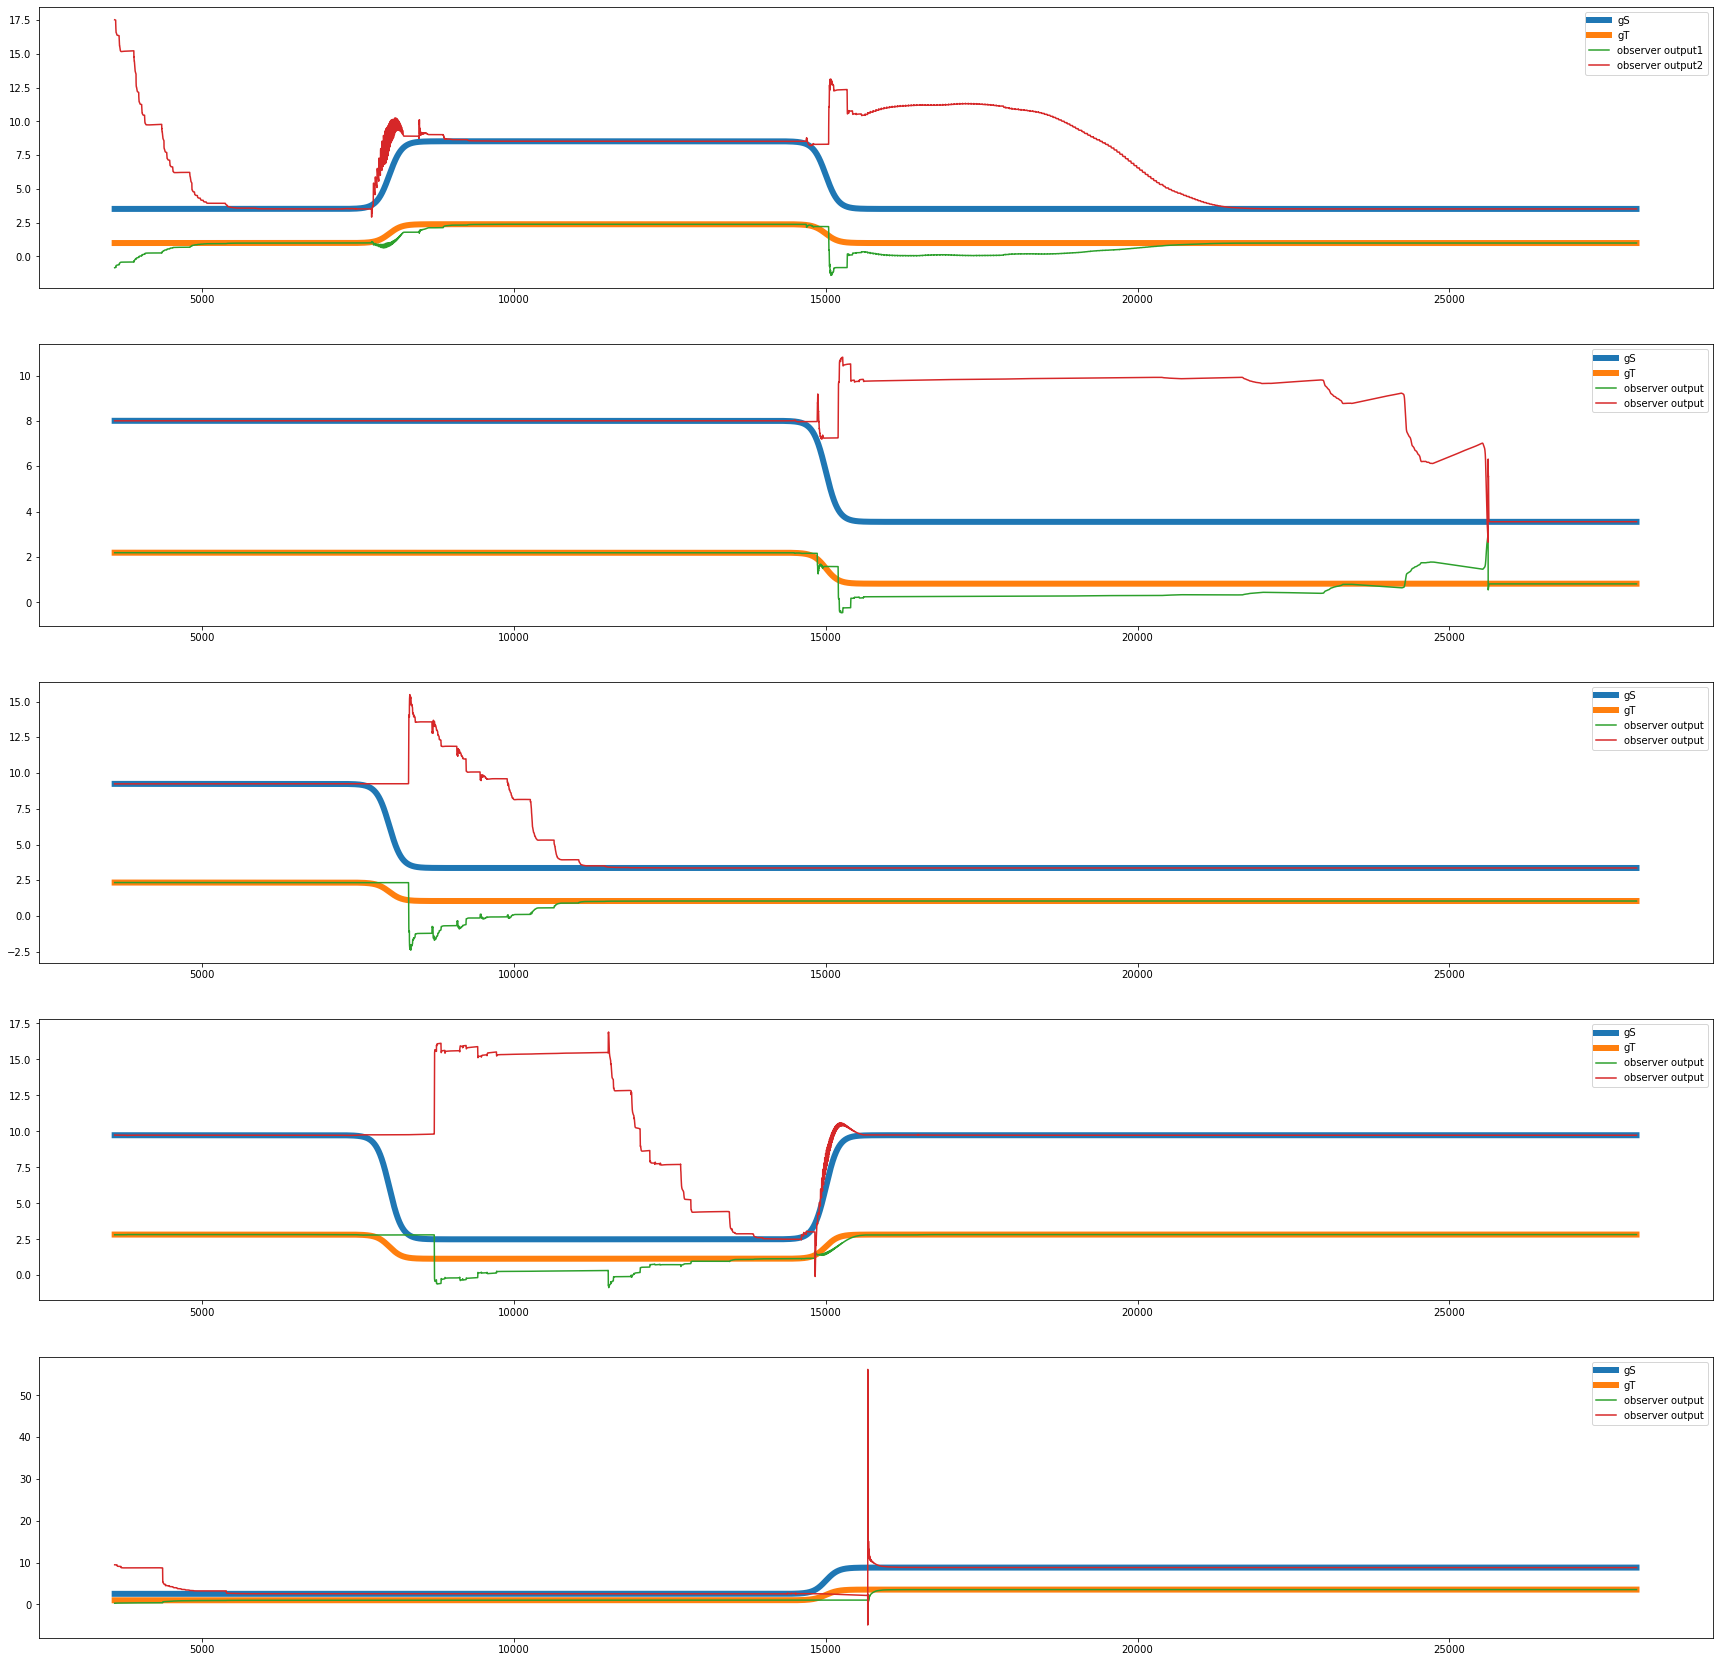

0.9928839999999969
0.8148303627265425
1.0495799999999997
2.8295700000000013
3.525739999999998


In [33]:
plot_fun2(net1,sol2)

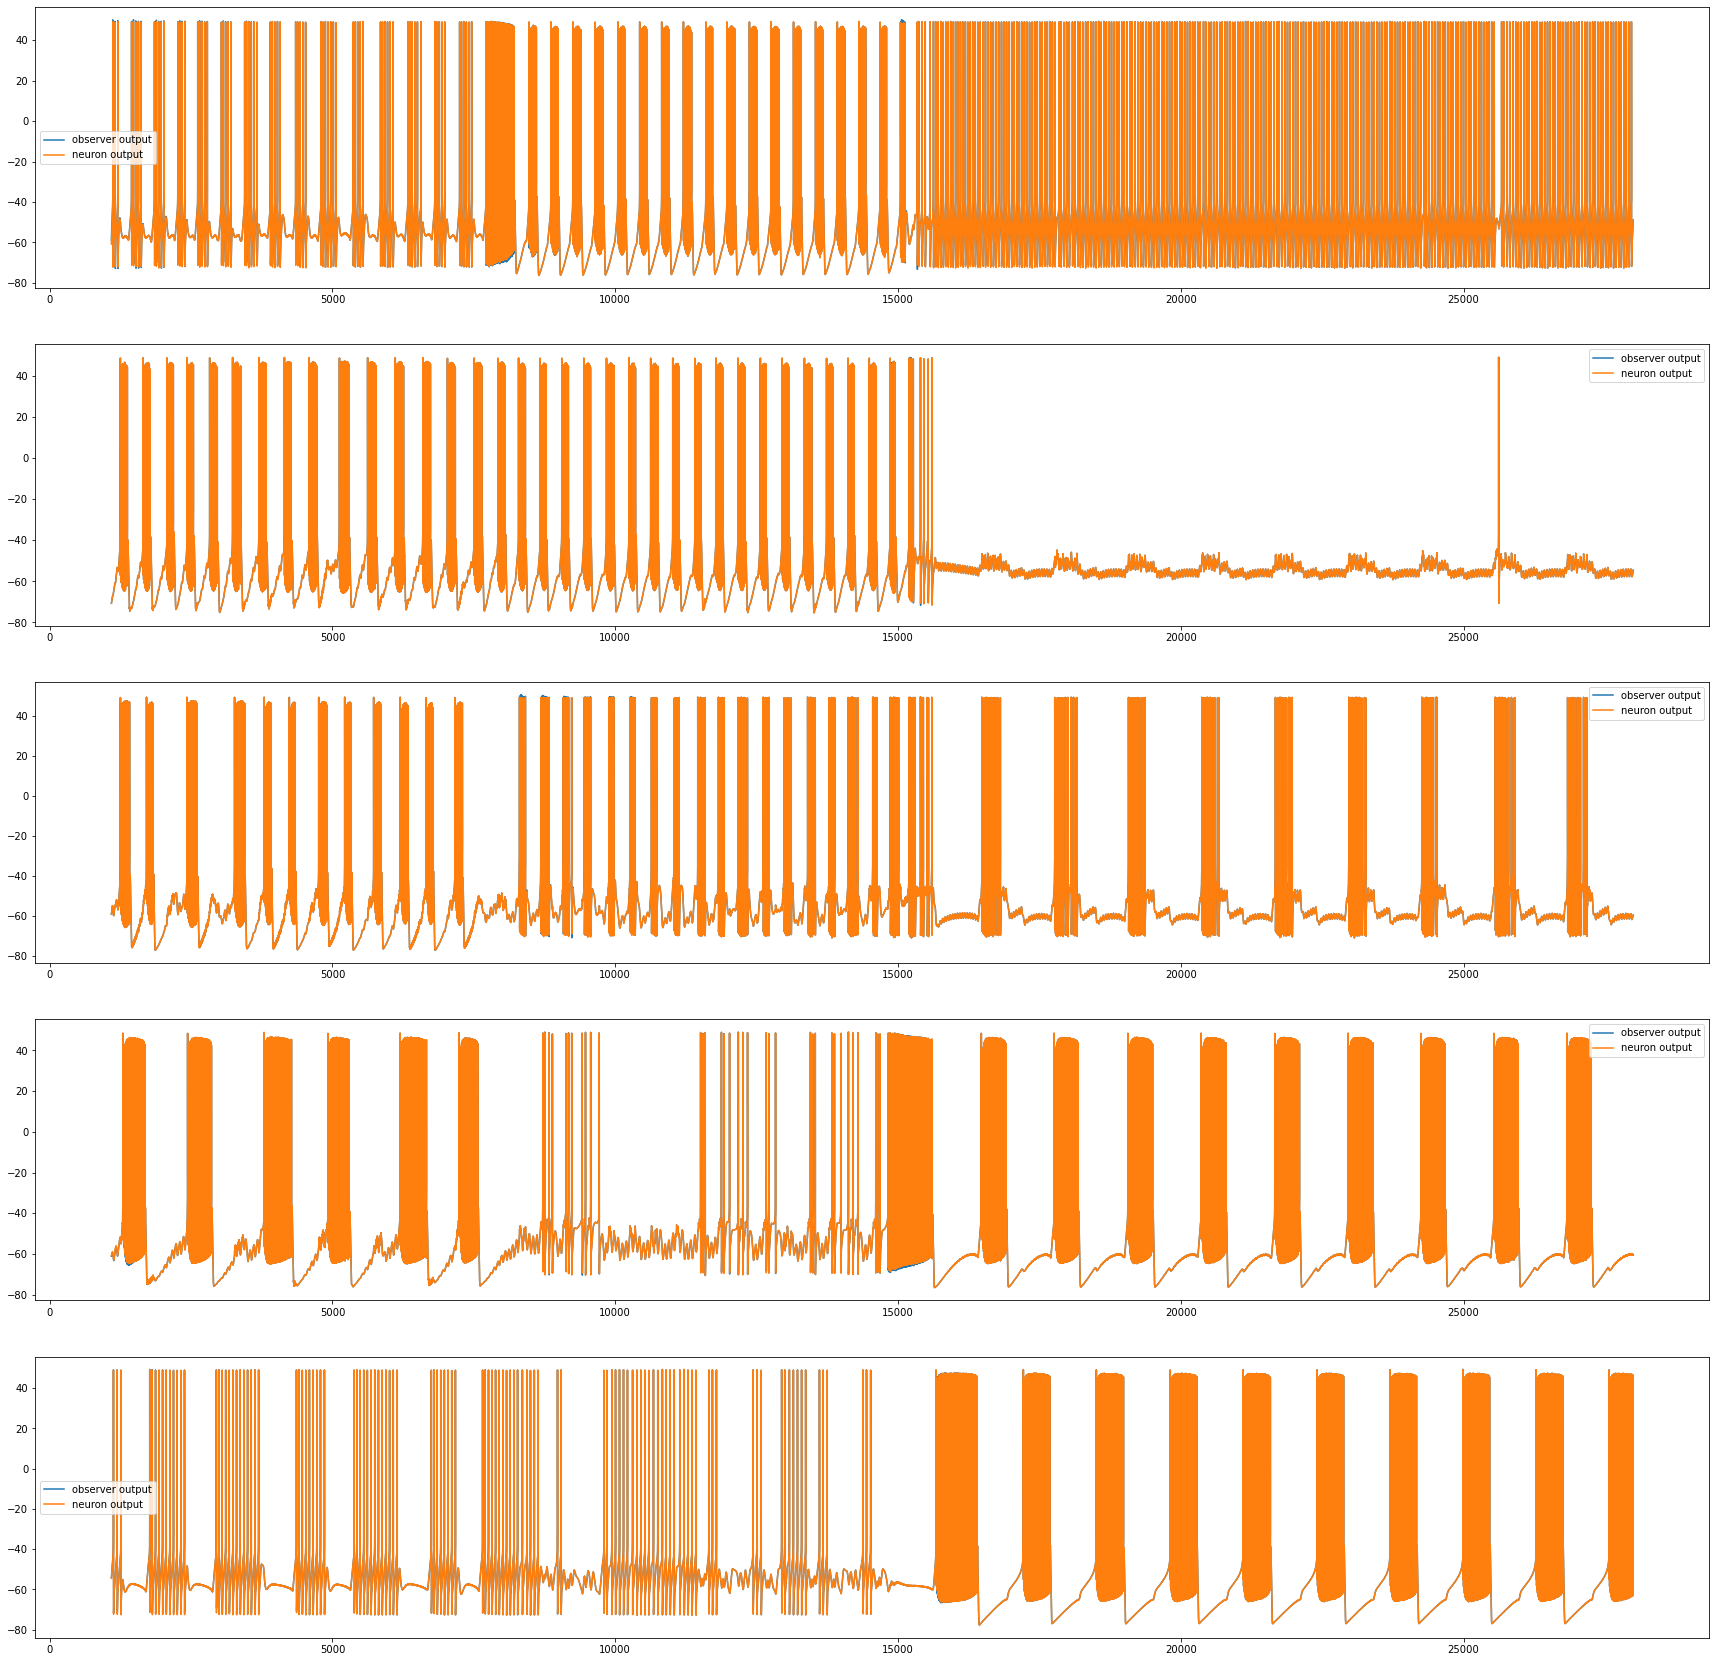

In [34]:
plot_fun(net1,sol2)

In [6]:
net1=random_MOD([0.,1.,1.,1.,0.])
net1.set_mod(fgS,fgT)
#Hyperparameters
gamma=8.
alpha=0.005
variable_mask1=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask2=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask3=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
net1.cells[0].set_hyp(gamma,alpha,variable_mask1)
net1.cells[1].set_hyp(gamma,alpha,variable_mask2)
net1.cells[2].set_hyp(gamma,alpha,variable_mask3)
net1.cells[3].set_hyp(gamma,alpha,variable_mask2)
net1.cells[4].set_hyp(gamma,alpha,variable_mask1)

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [7]:
X0=[*net1.cells[0].init_cond_OB(-60+5),*net1.cells[1].init_cond_OB(-60-5),*net1.cells[2].init_cond_OB(-61),*net1.cells[3].init_cond_OB(-60-2),*net1.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol3=solve_ivp(net1.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[3.05153724e-02 9.15084064e+01 4.58801183e+01 3.27180884e+00
 6.48213479e+01 6.61103787e+01 3.42122225e+01 4.66990178e+01
 6.46280844e+01]
[-16.65915254]
[93.02490971 93.69111663 98.61007644  3.42360513 49.81571936  2.74488864
 74.0824279  80.46500364 95.79848918 87.12748679]
[-93.47508759]
[9.88474211e+01 2.40163308e+01 8.46124068e+01 2.21435209e-02
 7.92422892e+01 7.23357855e+01 5.88380114e+01 1.64594343e+01
 3.68864378e+01 7.79658982e+01 4.49295721e+00 4.19414264e+01]
[-27.42138777]
[15.69133262 36.82709651 20.64804381 90.96472382 59.70728449 94.60721951
 99.04787504 24.66143945 65.13745377 20.93829124]
[-46.43141211]
[ 3.85863799 53.5737743  44.86610922 44.98662607 59.87879529 71.18238554
 10.91782645 85.66538348 96.32378481]
[-54.57746363]


<string>:3: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))


Elapsed (with compilation) = 383.79374074935913


In [24]:
import os

# if os.path.exists("sol3.data"):
#       os.remove("sol3.data")

file_sol3= open('sol3.data','wb') 
pickle.dump(sol3, file_sol3)

In [25]:
file_sol3.closed

False

In [26]:
file_sol3 = open('sol3.data', 'rb') 
sol3= pickle.load(file_sol3)
file_sol3.close()

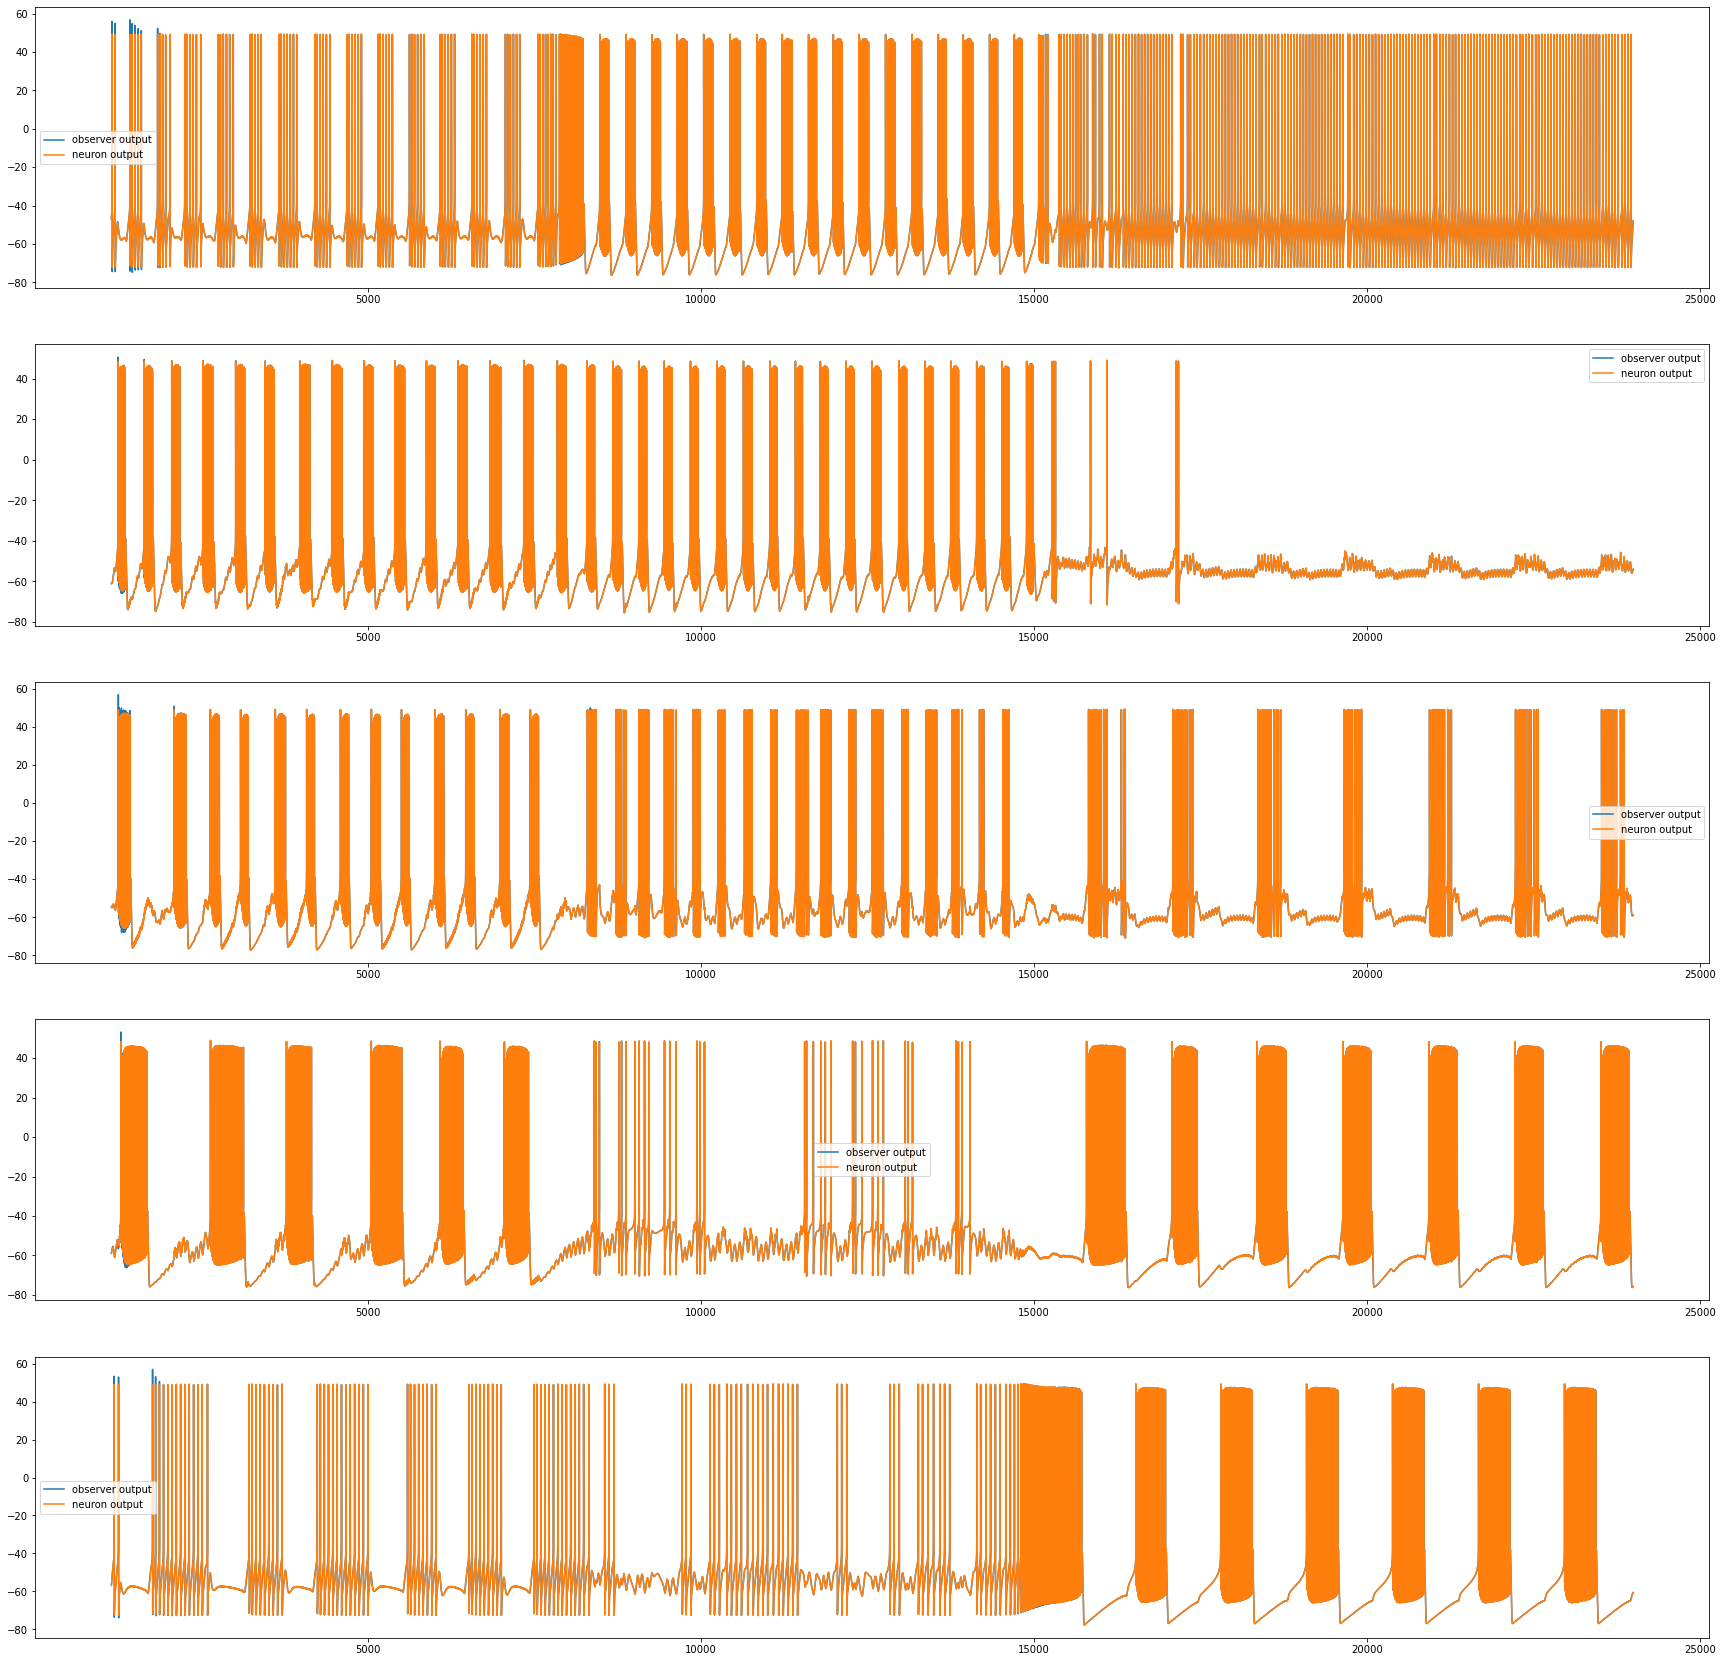

In [27]:
plot_fun(net1,sol3)

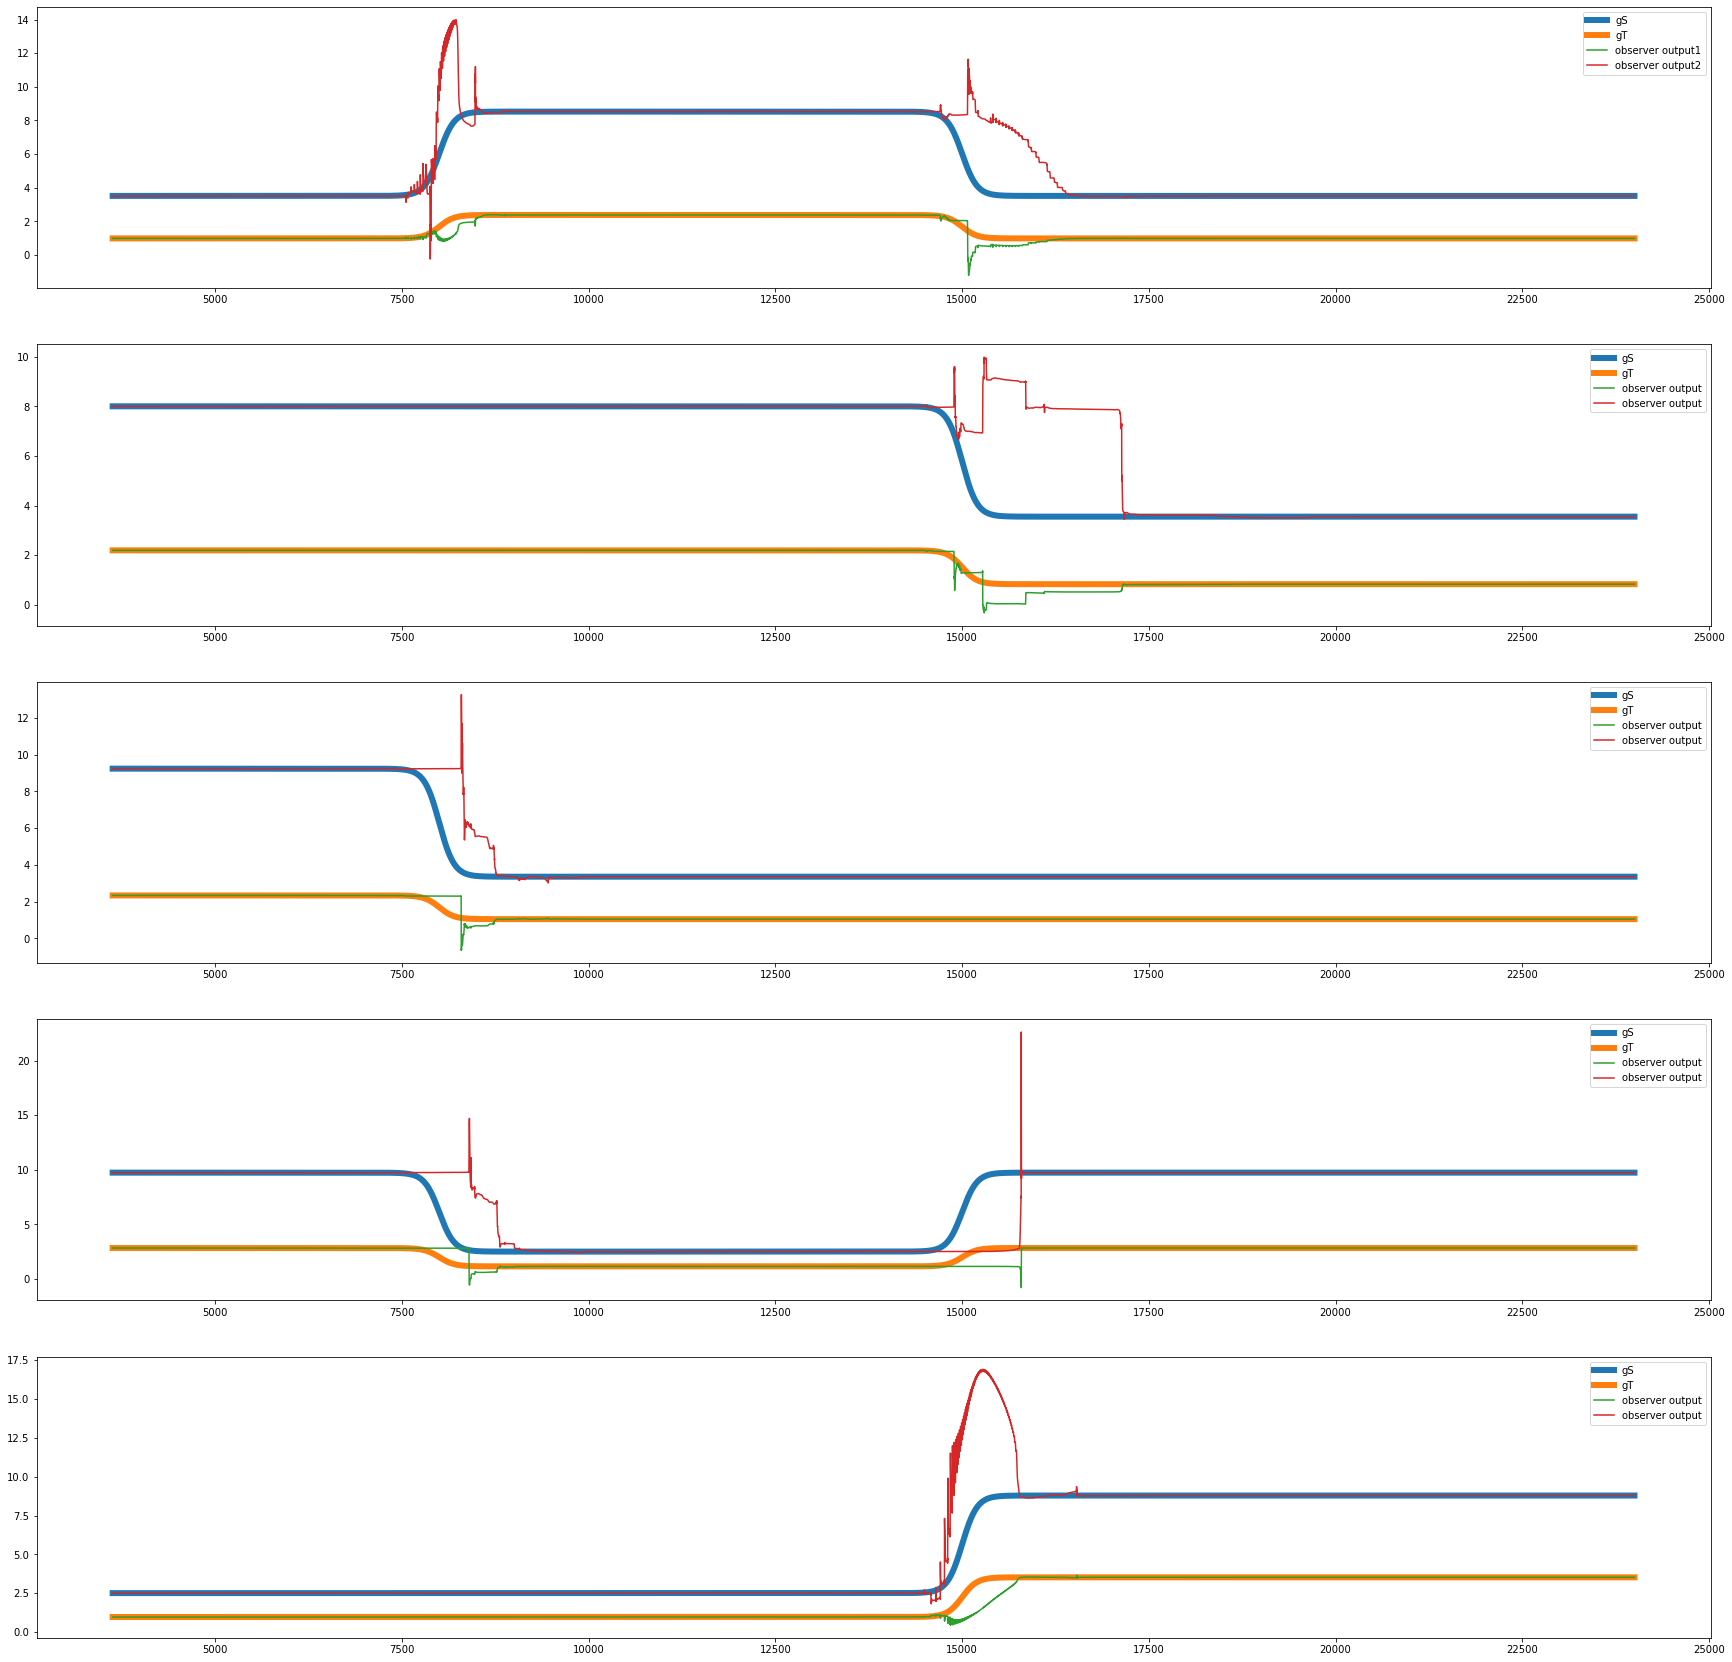

0.9928839999999923
0.8247873772047541
1.0495799999999964
2.829570000000033
3.525739999994982


In [28]:
plot_fun2(net1,sol3)

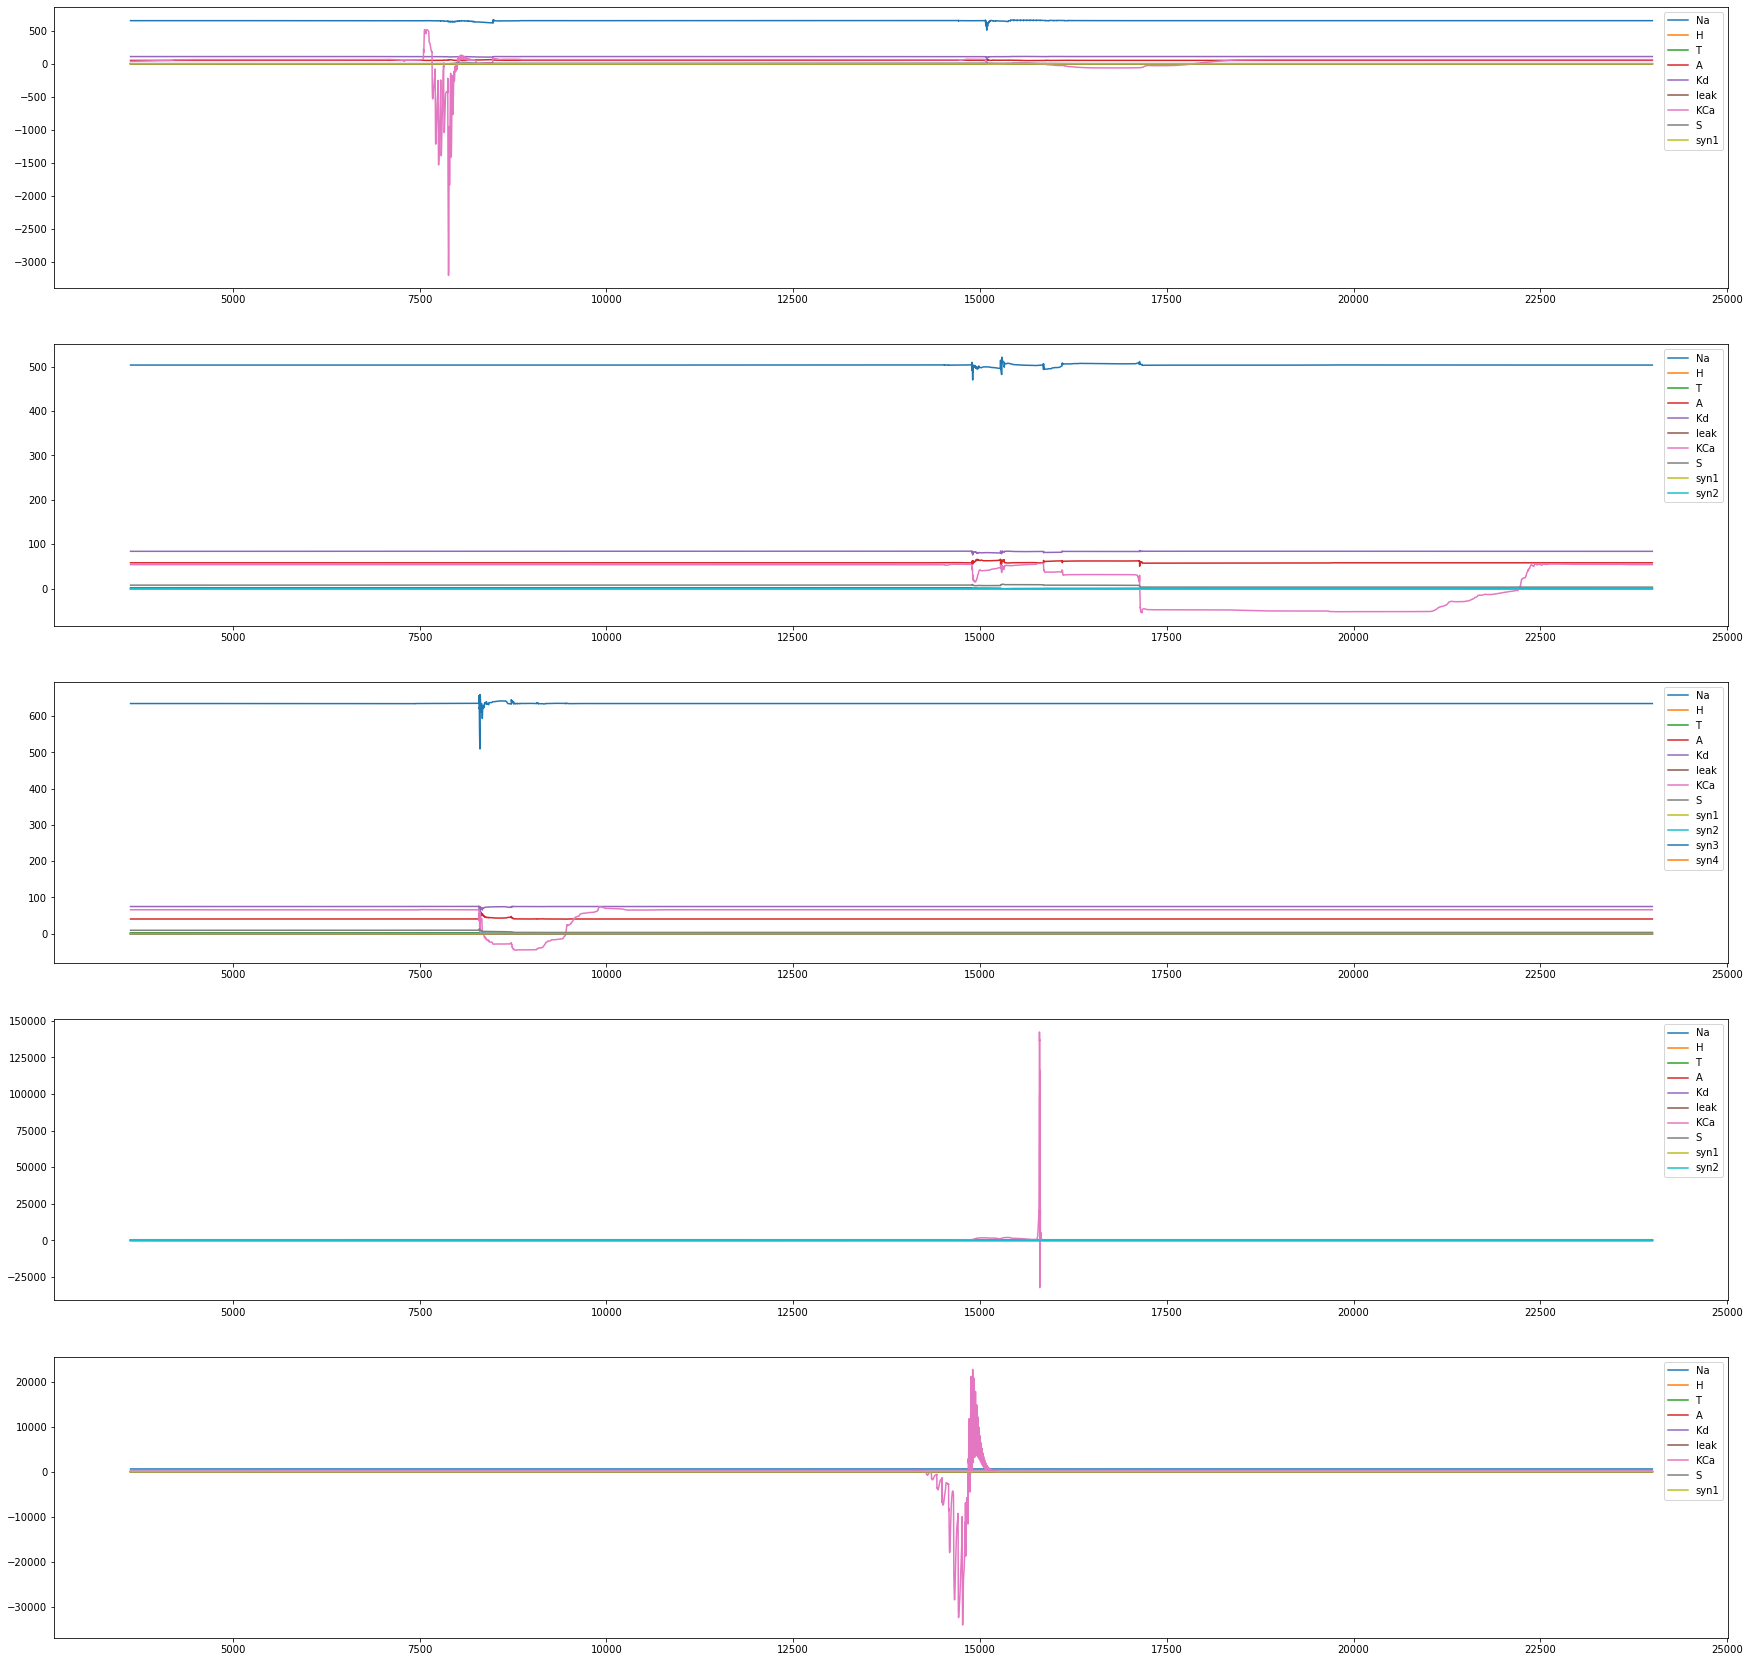

In [29]:
plot_fun3(net1,sol3)

In [158]:
net2=random_MOD2([0.,1.,1.,1.,0.])
#Hyperparameters
net2.set_mod(fgS,fgT)
gamma=15.
alpha=0.0015
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net2.cells[0].set_hyp(gamma,alpha,variable_mask1)
net2.cells[1].set_hyp(gamma,alpha,variable_mask2)
net2.cells[2].set_hyp(gamma,alpha,variable_mask3)
net2.cells[3].set_hyp(gamma,alpha,variable_mask2)
net2.cells[4].set_hyp(gamma,alpha,variable_mask1)


num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [159]:
X0=[*net2.cells[0].init_cond_OB(-60+5),*net2.cells[1].init_cond_OB(-60+2),*net2.cells[2].init_cond_OB(-61),*net2.cells[3].init_cond_OB(-60-2),*net2.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol4=solve_ivp(net2.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 1.32706916e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 8.56862581e+01
 7.71695119e-02]
[-79.86346381]
[5.03580000e+02 9.29811000e-02 8.78540118e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 3.99226513e+01
 7.63508367e-02 2.10839169e-02]
[-67.75630125]
[6.34723000e+02 7.81820000e-02 6.83235218e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 3.44660648e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-41.73945862]
[4.59807000e+02 8.34140000e-02 4.78381715e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 8.99711109e+01
 1.17123333e-01 2.28748603e-02]
[-12.59531226]
[6.16433000e+02 8.87343000e-02 1.40597356e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 9.81634177e+01
 7.76215841e-02]
[-99.38990637]
Elapsed (with compilation) = 424.42637395858765


In [160]:
file_sol4= open('sol4.data','wb') 
pickle.dump(sol4, file_sol4)
file_sol4.close()

In [8]:
file_sol4r = open('sol4.data', 'rb') 
sol4= pickle.load(file_sol4r)
file_sol4r.close()

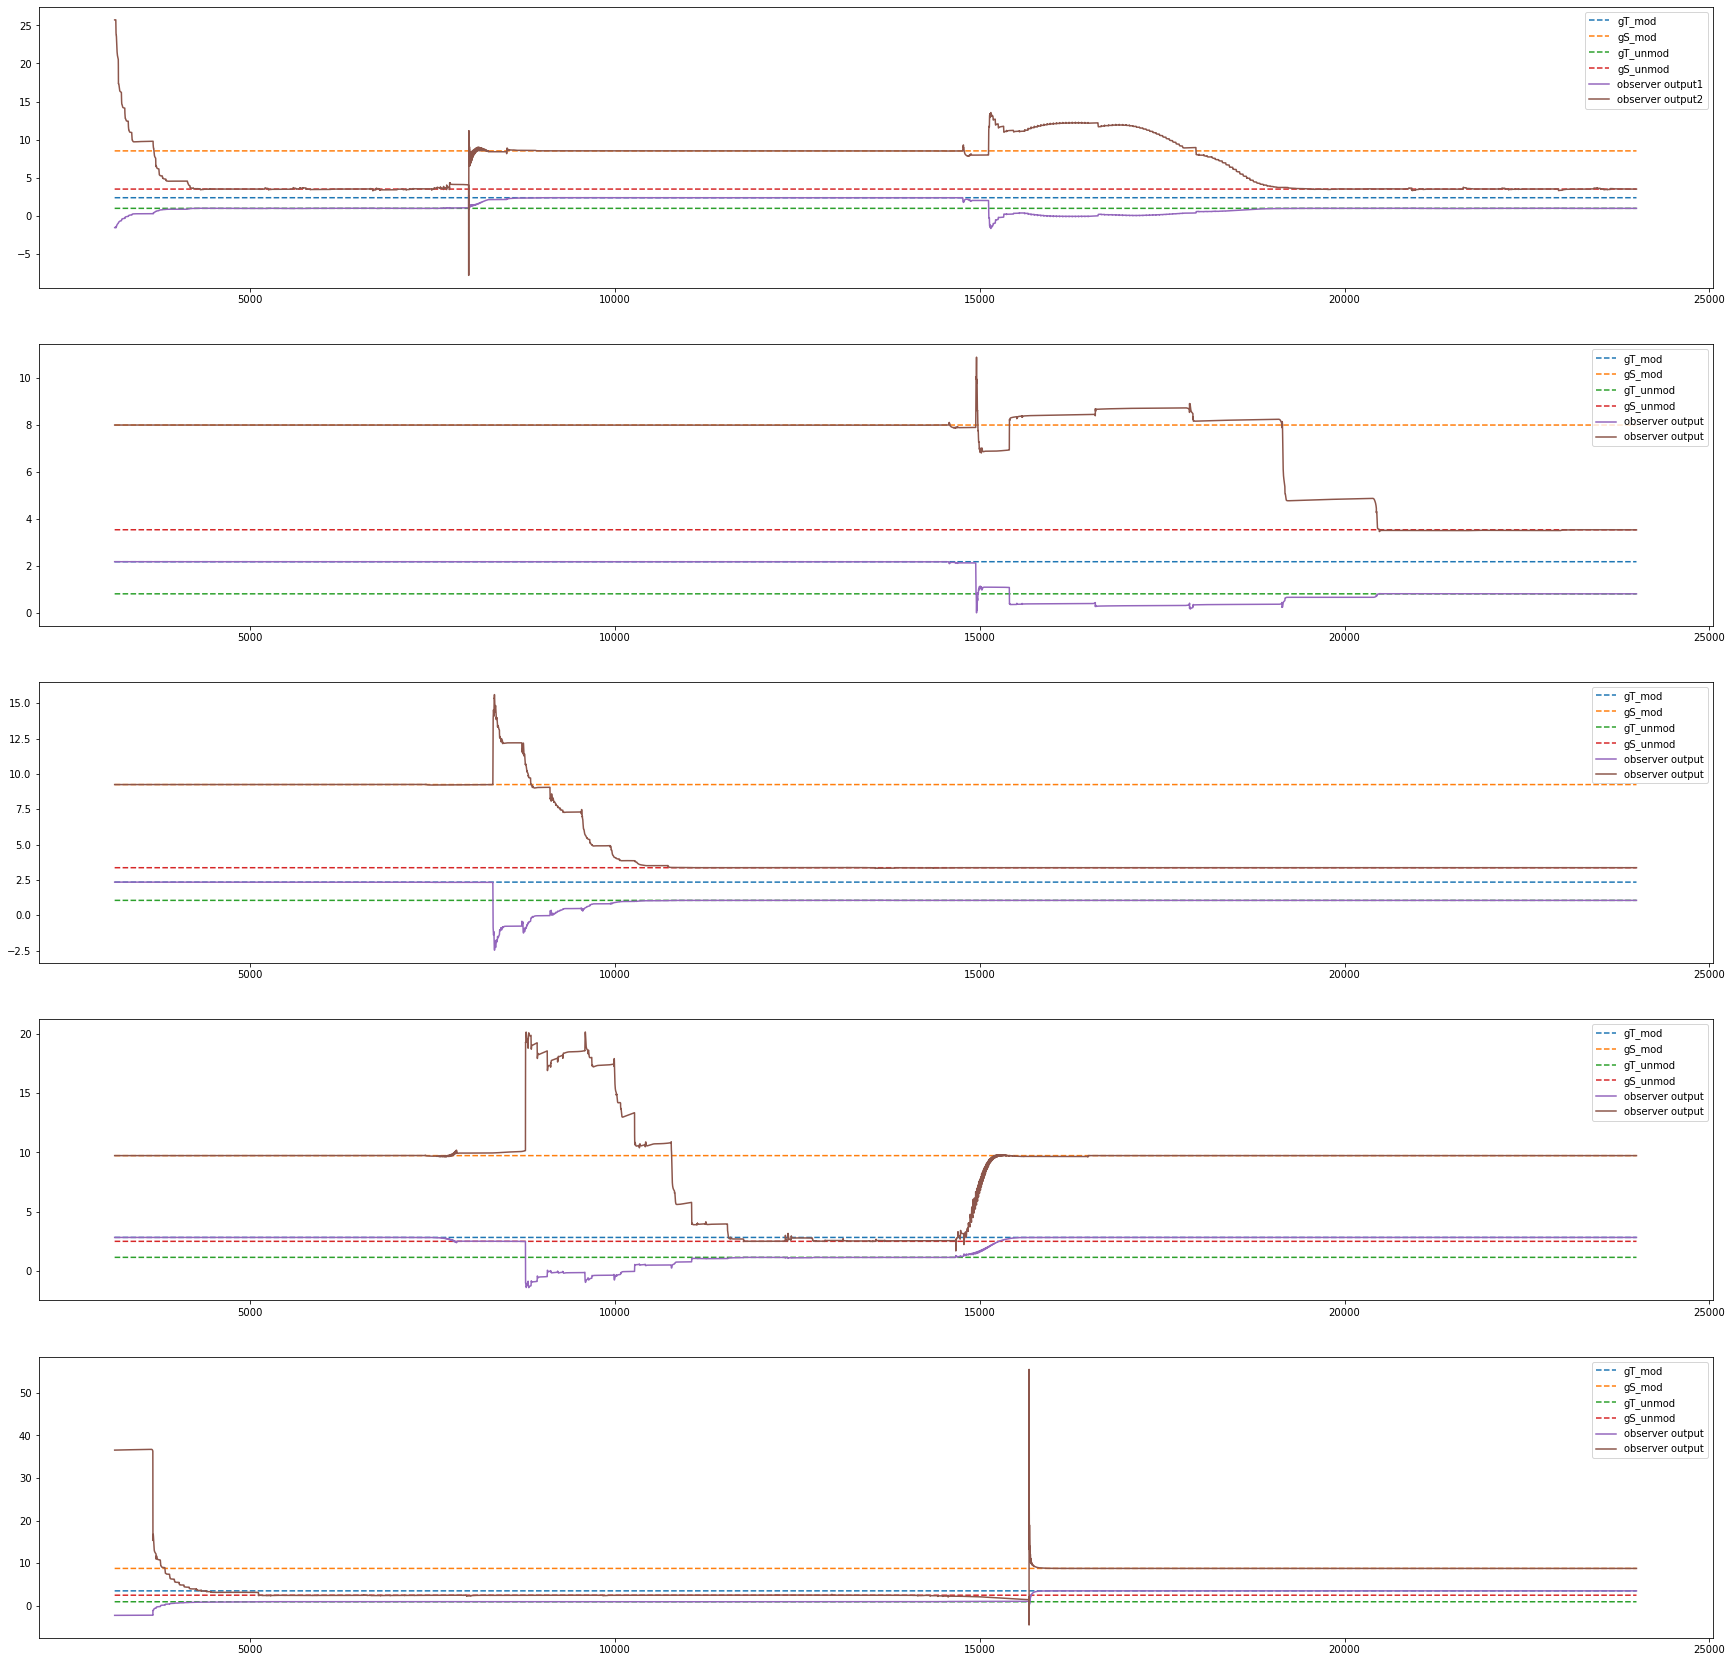

0.9928716501432812
0.8248336069950389
1.0495800000059112
2.829564236467341
3.5257400000476897


In [277]:
gT_mod_2=ones(len(sol4.t))*gCaTvec_MOD[2]
gS_mod_2=ones(len(sol4.t))*gCaSvec_MOD[2]
gT_unmod_2=ones(len(sol4.t))*gCaTvec[2]
gS_unmod_2=ones(len(sol4.t))*gCaSvec[2]

gT_mod_0=ones(len(sol4.t))*gCaTvec_MOD[0]
gS_mod_0=ones(len(sol4.t))*gCaSvec_MOD[0]
gT_unmod_0=ones(len(sol4.t))*gCaTvec[0]
gS_unmod_0=ones(len(sol4.t))*gCaSvec[0]

gT_mod_1=ones(len(sol4.t))*gCaTvec_MOD[1]
gS_mod_1=ones(len(sol4.t))*gCaSvec_MOD[1]
gT_unmod_1=ones(len(sol4.t))*gCaTvec[1]
gS_unmod_1=ones(len(sol4.t))*gCaSvec[1]

gT_mod_3=ones(len(sol4.t))*gCaTvec_MOD[3]
gS_mod_3=ones(len(sol4.t))*gCaSvec_MOD[3]
gT_unmod_3=ones(len(sol4.t))*gCaTvec[3]
gS_unmod_3=ones(len(sol4.t))*gCaSvec[3]

gT_mod_4=ones(len(sol4.t))*gCaTvec_MOD[4]
gS_mod_4=ones(len(sol4.t))*gCaSvec_MOD[4]
gT_unmod_4=ones(len(sol4.t))*gCaTvec[4]
gS_unmod_4=ones(len(sol4.t))*gCaSvec[4]


plot_fun2(net2,sol4)

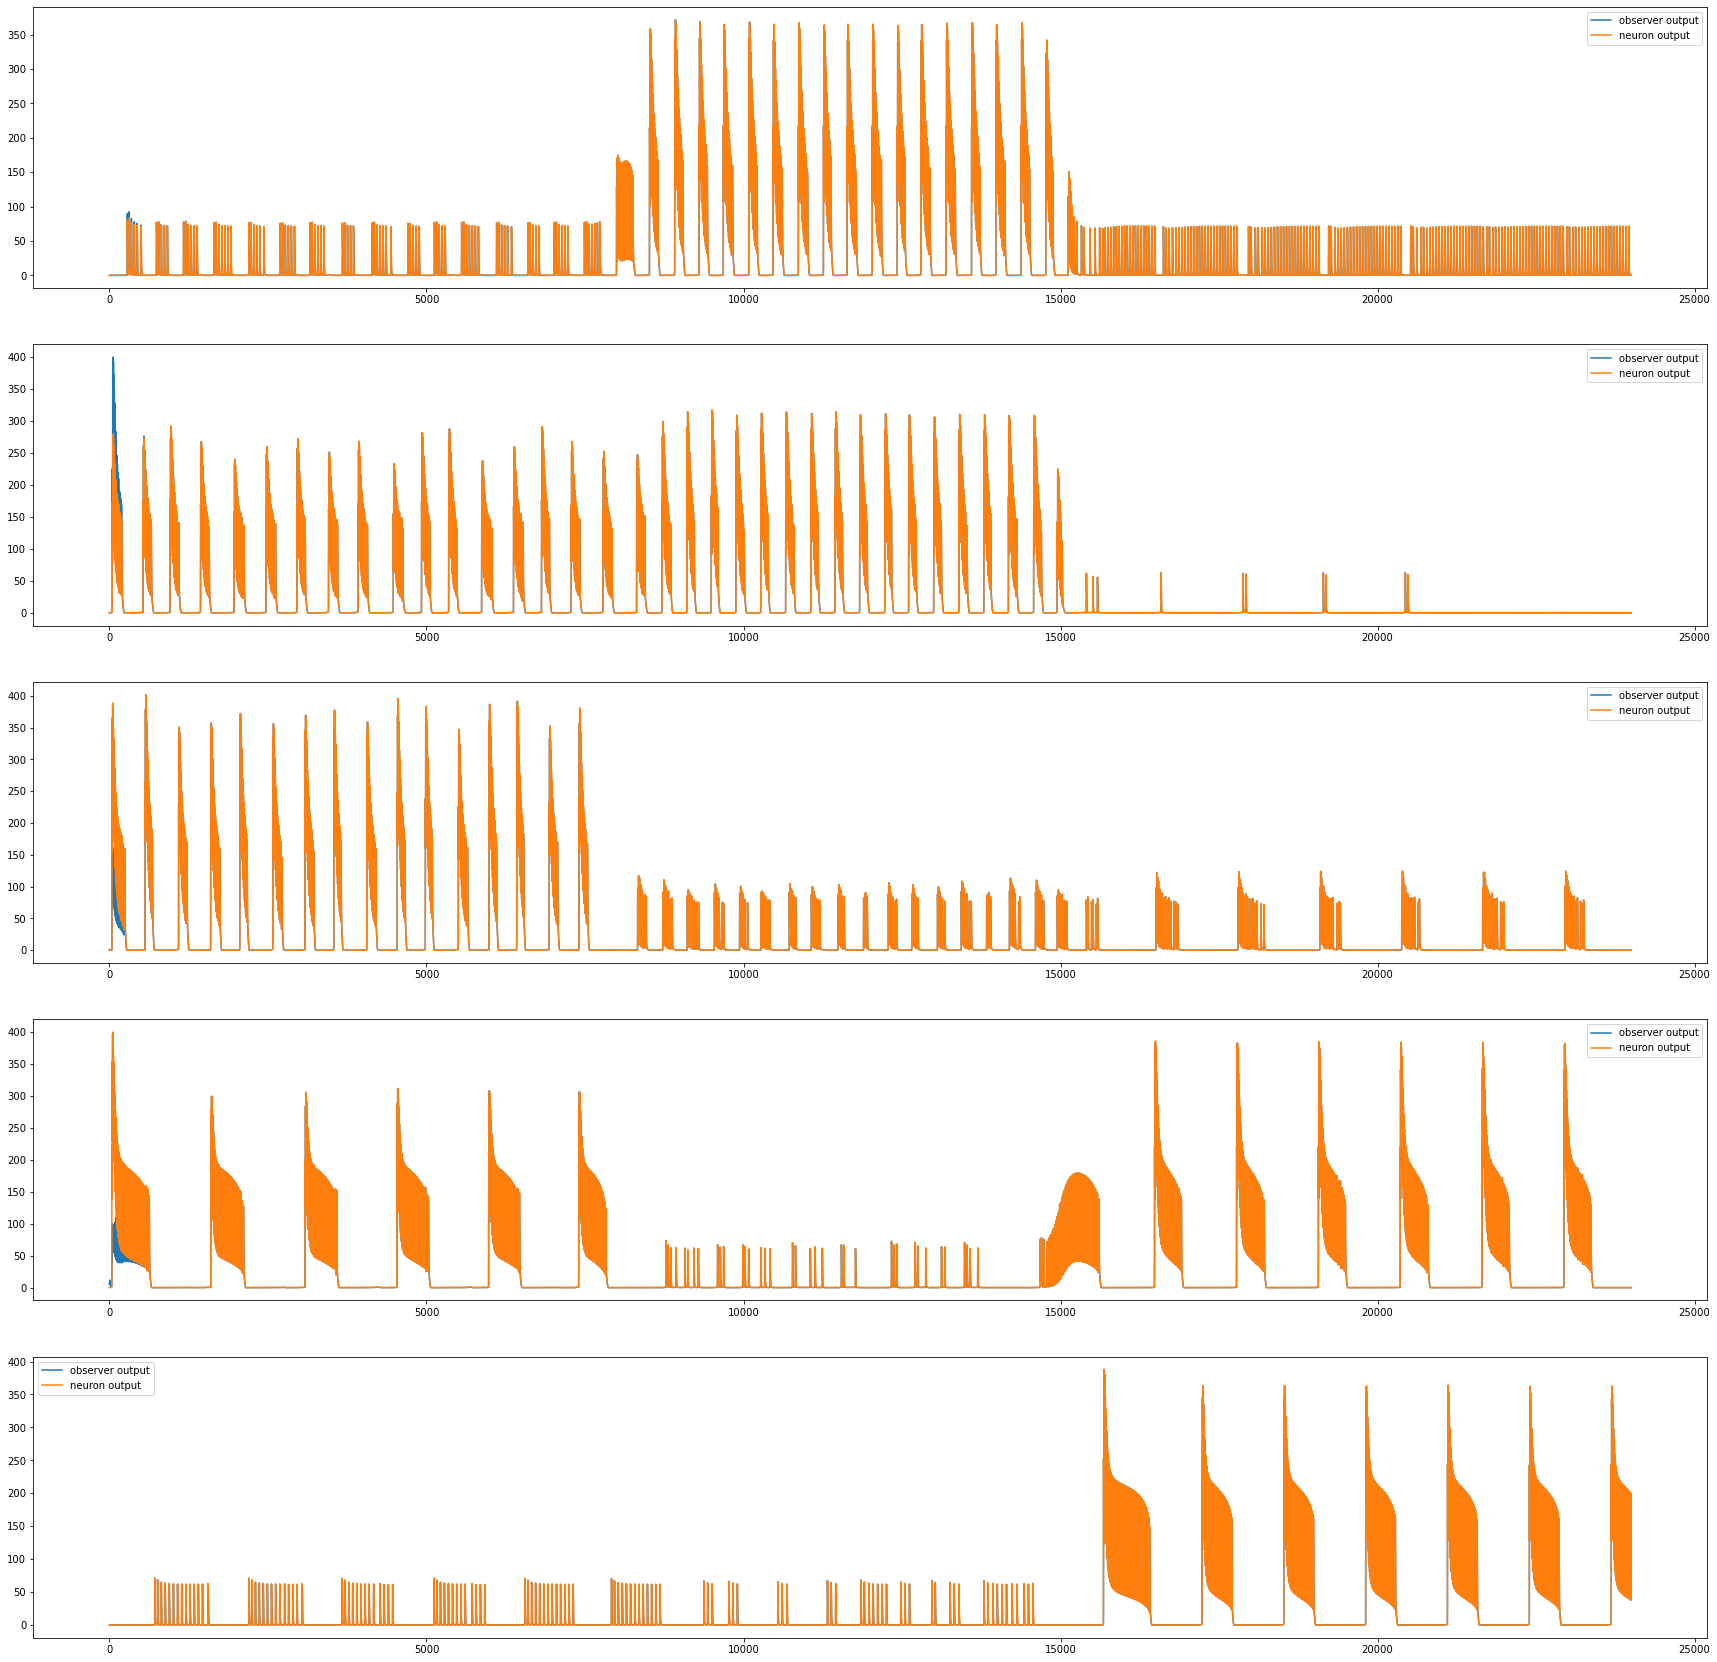

In [278]:
plot_fun1(net2,sol4)

In [36]:
net3=random_MOD_diag([0.,1.,1.,1.,0.])
#Hyperparameters
net3.set_mod(fgS2,fgT2)
gamma=10
alpha=0.0016
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net3.cells[0].set_hyp(gamma,alpha,variable_mask1)
net3.cells[1].set_hyp(gamma,alpha,variable_mask2)
net3.cells[2].set_hyp(gamma,alpha,variable_mask3)
net3.cells[3].set_hyp(gamma,alpha,variable_mask2)
net3.cells[4].set_hyp(gamma,alpha,variable_mask1)

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [37]:
X0=[*net3.cells[0].init_cond_OB(-60+5),*net3.cells[1].init_cond_OB(-60+2),*net3.cells[2].init_cond_OB(-61),*net3.cells[3].init_cond_OB(-60-2),*net3.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol5=solve_ivp(net3.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 1.22970759e+00 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 4.49258730e+00
 7.71695119e-02]
[-36.28400441]
[5.03580000e+02 9.29811000e-02 2.92480308e+00 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 8.50118025e+00
 7.63508367e-02 2.10839169e-02]
[-45.65959623]
[6.34723000e+02 7.81820000e-02 2.94353336e+00 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 1.01997188e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-38.9003341]
[4.59807000e+02 8.34140000e-02 3.38698422e+00 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 1.03787739e+01
 1.17123333e-01 2.28748603e-02]
[-31.00991945]
[6.16433000e+02 8.87343000e-02 1.23967560e+00 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 3.22684865e+00
 7.76215841e-02]
[-0.62798883]
Elapsed (with compilation) = 284.7507109642029


In [38]:
file_sol5= open('sol5.data','wb') 
pickle.dump(sol5, file_sol5)
file_sol5.close()

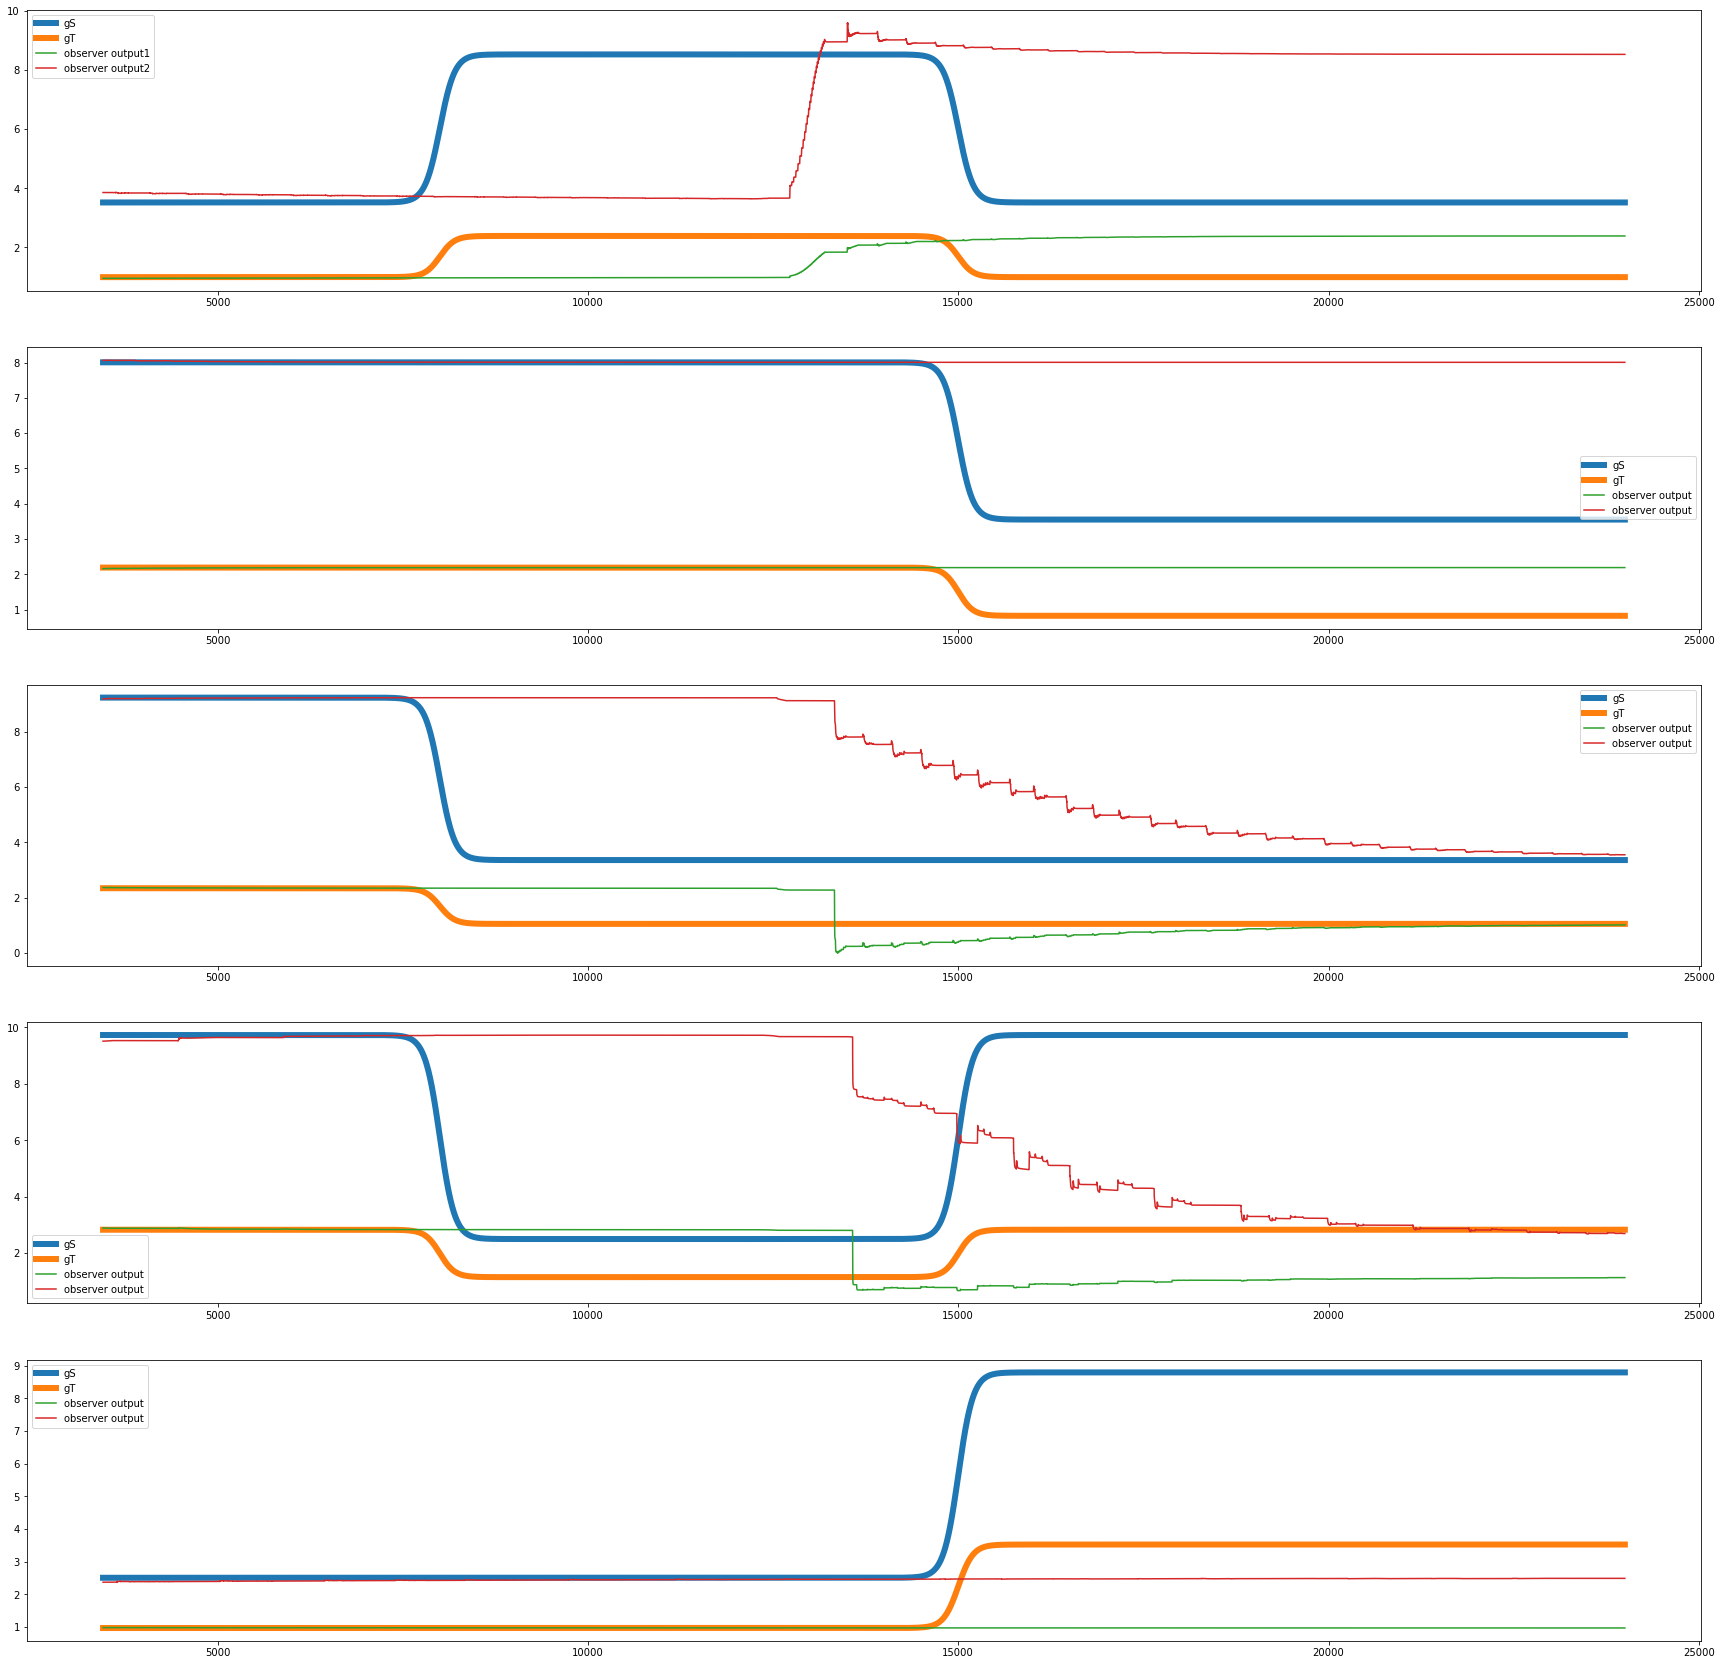

2.38572539011088
2.1909199731311935
1.0124485284792142
1.1327148302968792
0.9735036400567201


In [39]:
gT_mod_2=ones(len(sol5.t))*gCaTvec_MOD[2]
gS_mod_2=ones(len(sol5.t))*gCaSvec_MOD[2]
gT_unmod_2=ones(len(sol5.t))*gCaTvec[2]
gS_unmod_2=ones(len(sol5.t))*gCaSvec[2]

gT_mod_0=ones(len(sol5.t))*gCaTvec_MOD[0]
gS_mod_0=ones(len(sol5.t))*gCaSvec_MOD[0]
gT_unmod_0=ones(len(sol5.t))*gCaTvec[0]
gS_unmod_0=ones(len(sol5.t))*gCaSvec[0]

gT_mod_1=ones(len(sol5.t))*gCaTvec_MOD[1]
gS_mod_1=ones(len(sol5.t))*gCaSvec_MOD[1]
gT_unmod_1=ones(len(sol5.t))*gCaTvec[1]
gS_unmod_1=ones(len(sol5.t))*gCaSvec[1]

gT_mod_3=ones(len(sol5.t))*gCaTvec_MOD[3]
gS_mod_3=ones(len(sol5.t))*gCaSvec_MOD[3]
gT_unmod_3=ones(len(sol5.t))*gCaTvec[3]
gS_unmod_3=ones(len(sol5.t))*gCaSvec[3]

gT_mod_4=ones(len(sol5.t))*gCaTvec_MOD[4]
gS_mod_4=ones(len(sol5.t))*gCaSvec_MOD[4]
gT_unmod_4=ones(len(sol5.t))*gCaTvec[4]
gS_unmod_4=ones(len(sol5.t))*gCaSvec[4]


plot_fun2(net3,sol5)

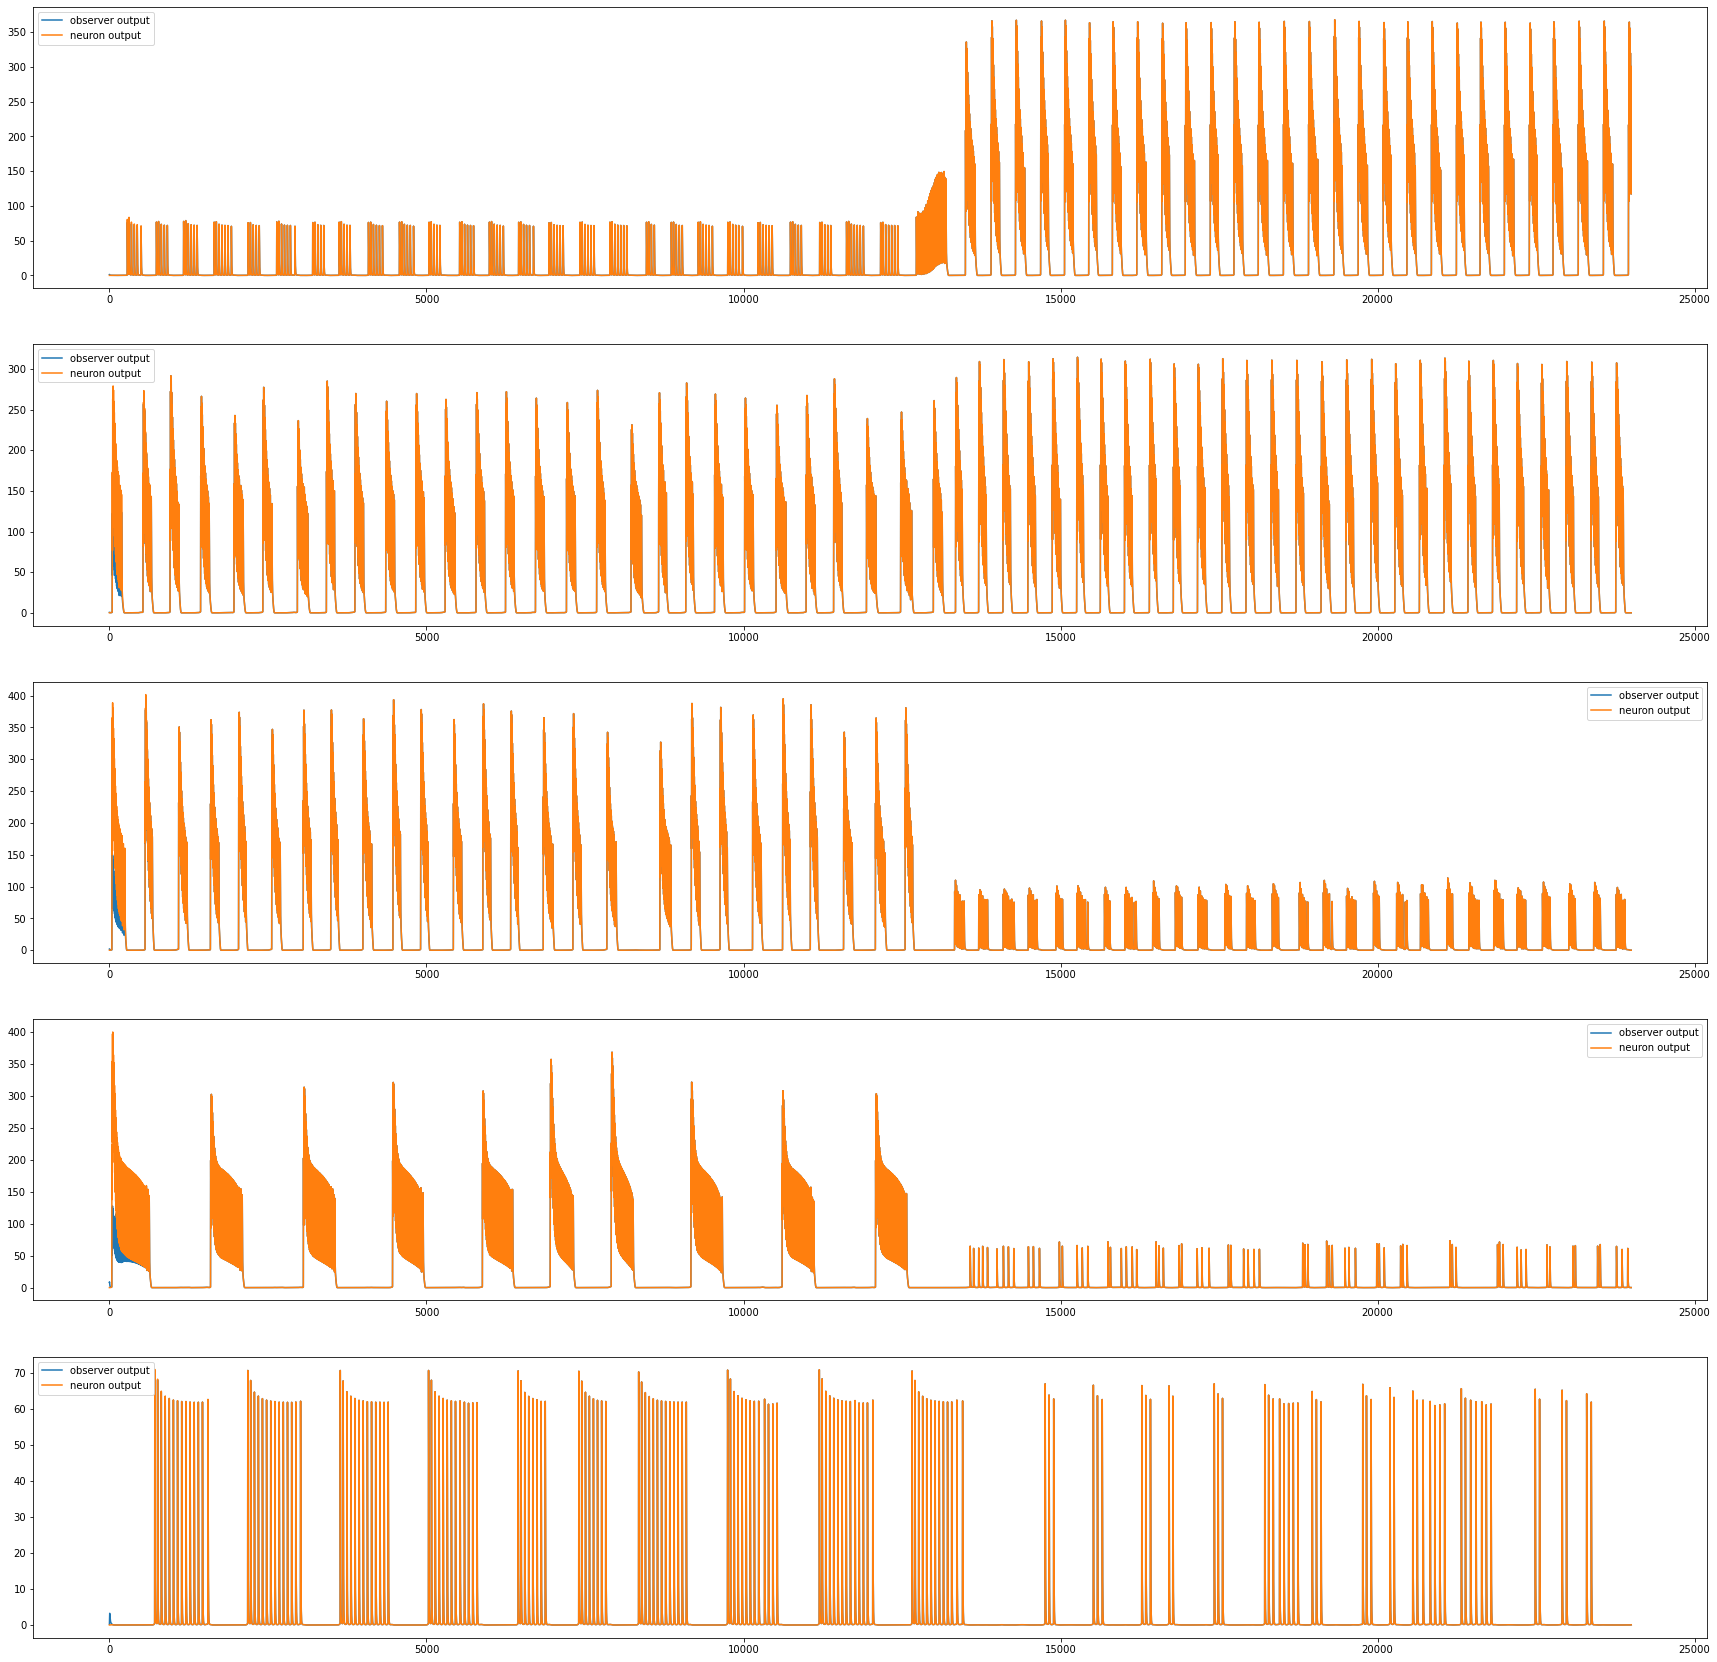

In [40]:
plot_fun1(net3,sol5)

In [80]:
net4=random_MOD_mis([0.,1.,1.,1.,0.])
#Hyperparameters
net4.set_mod(fgS,fgT)
gamma=10
alpha=0.0015
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net4.cells[0].set_hyp(gamma,alpha,variable_mask1)
net4.cells[1].set_hyp(gamma,alpha,variable_mask2)
net4.cells[2].set_hyp(gamma,alpha,variable_mask3)
net4.cells[3].set_hyp(gamma,alpha,variable_mask2)
net4.cells[4].set_hyp(gamma,alpha,variable_mask1)

[1.05681908 1.09459931 0.97617016 1.09918532 1.06650349 1.05047401]
num_Theta 8
[0.94392921 0.96133342 1.02932047 1.08848945 1.09367779 1.07065921]
num_Theta 8
[0.93307464 0.98378379 0.9169959  1.06396333 1.0235067  1.02613719]
num_Theta 8
[1.00339545 1.05309215 0.97154173 1.09323261 0.99413068 1.09758587]
num_Theta 8
[0.94139699 1.03297453 0.98605434 1.07989503 0.91850603 1.06047118]
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [81]:
X0=[*net4.cells[0].init_cond_OB(-60+5),*net4.cells[1].init_cond_OB(-60+2),*net4.cells[2].init_cond_OB(-61),*net4.cells[3].init_cond_OB(-60-2),*net4.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol6=solve_ivp(net4.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 8.78574280e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 6.81722967e+01
 7.71695119e-02]
[-73.56846811]
[5.03580000e+02 9.29811000e-02 3.95040451e+00 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 9.43693978e+01
 7.63508367e-02 2.10839169e-02]
[-45.66532419]
[6.34723000e+02 7.81820000e-02 5.34774867e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 5.00023813e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-75.67666172]
[4.59807000e+02 8.34140000e-02 7.15145211e+00 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 6.41241342e+01
 1.17123333e-01 2.28748603e-02]
[-89.18080589]
[6.16433000e+02 8.87343000e-02 9.33121786e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 4.09545319e+01
 7.76215841e-02]
[-52.85474558]
Elapsed (with compilation) = 412.4939479827881


In [82]:
file_sol6= open('sol6.data','wb') 
pickle.dump(sol6, file_sol6)
file_sol6.close()

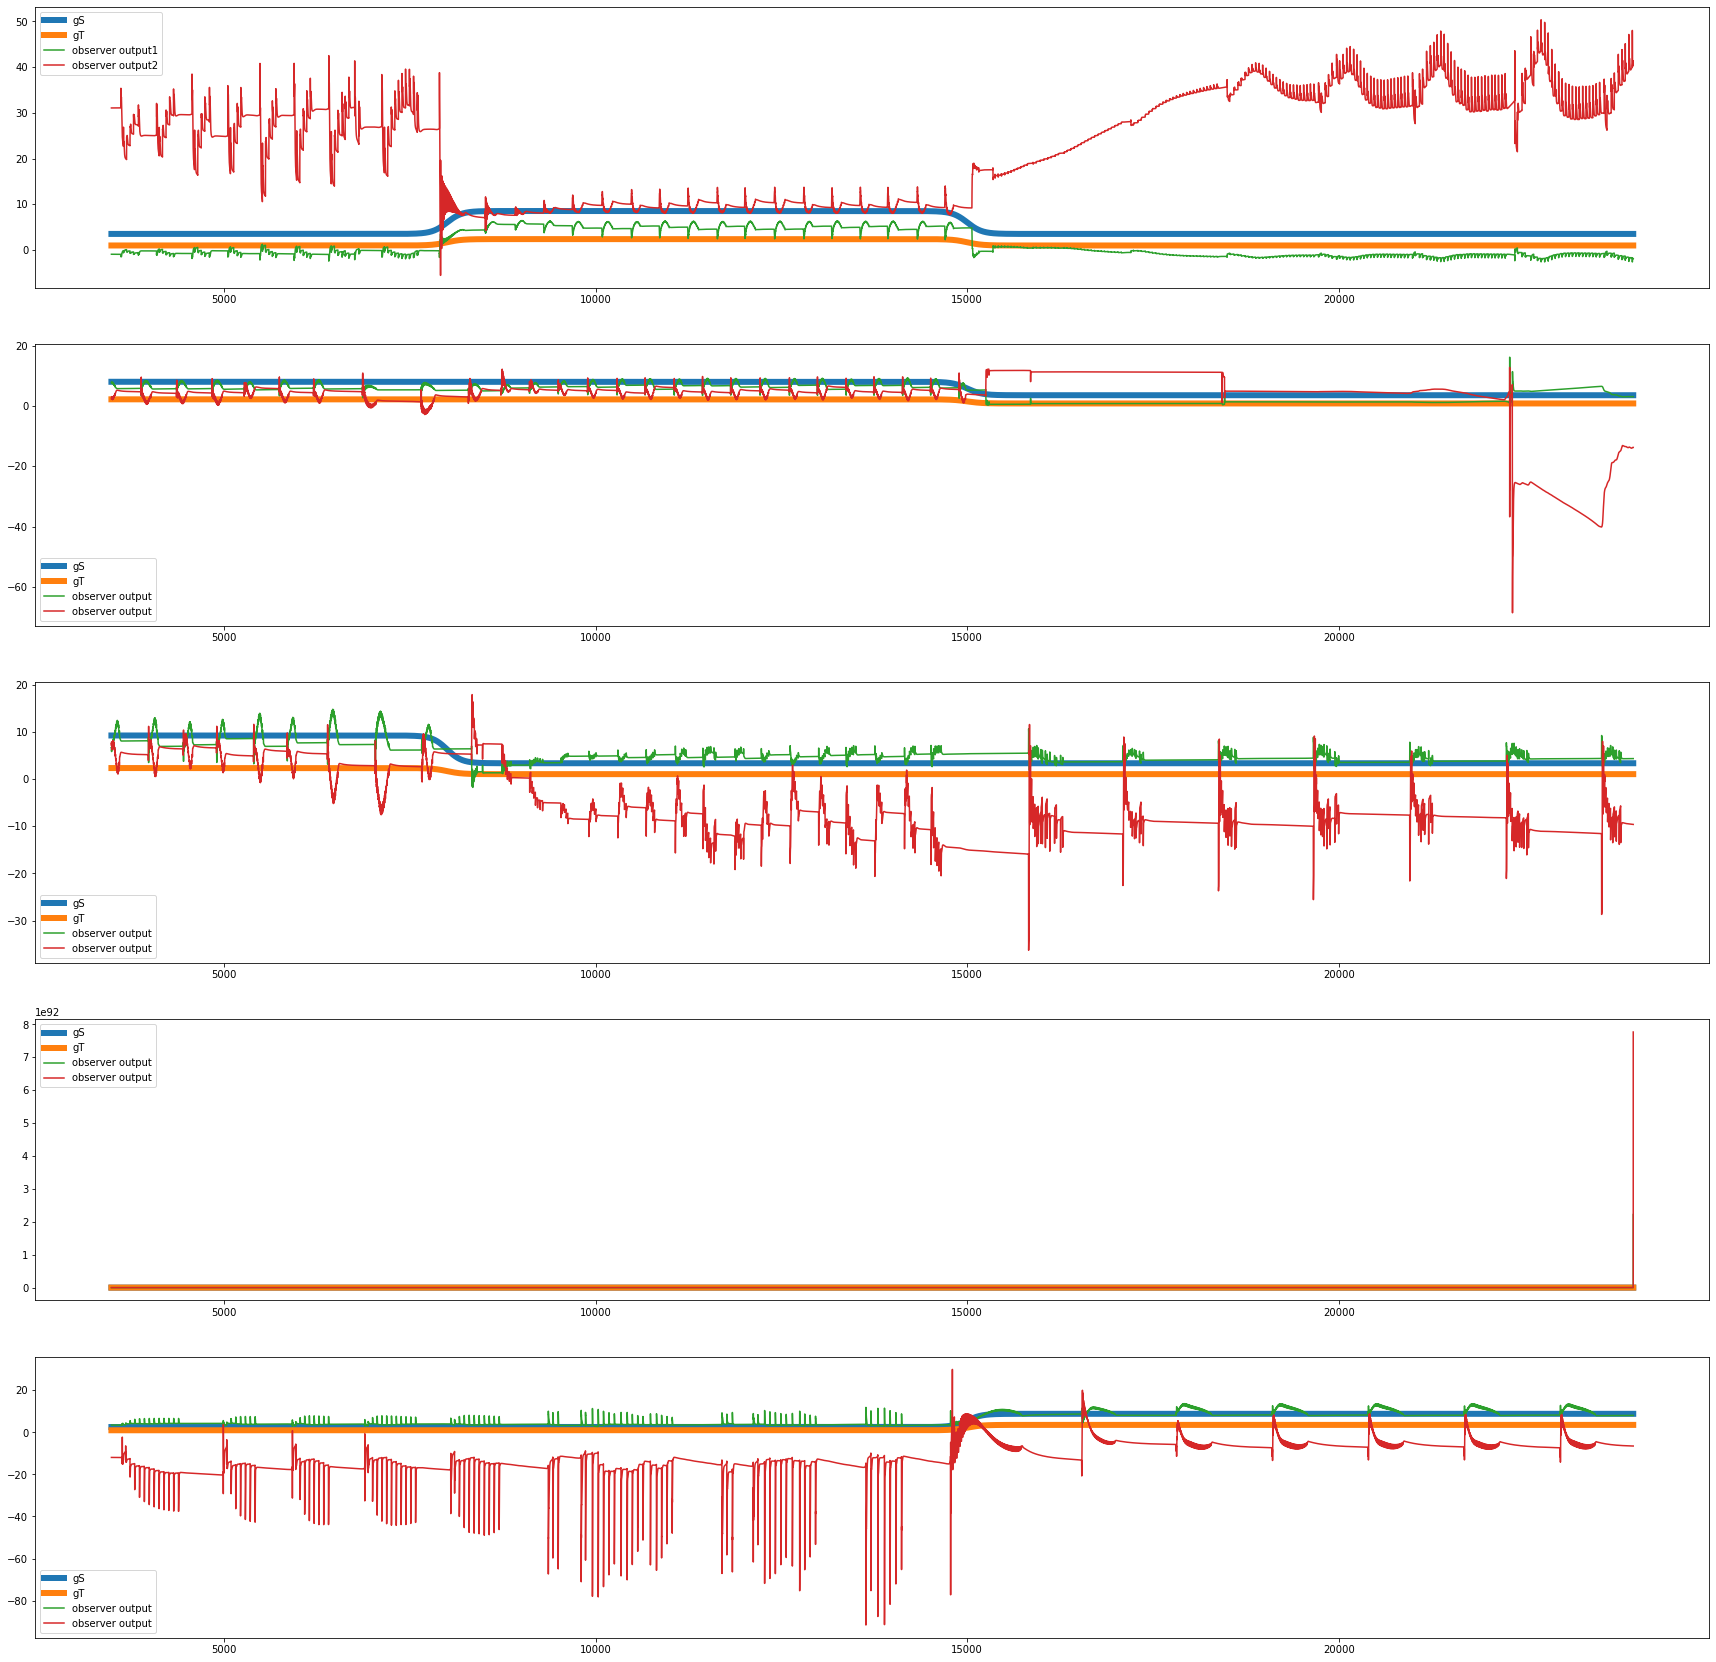

-1.867333750764961
3.06461082133676
4.34475177834043
2.2210439091909638e+92
8.019939275186479


In [83]:
plot_fun2(net4,sol6)

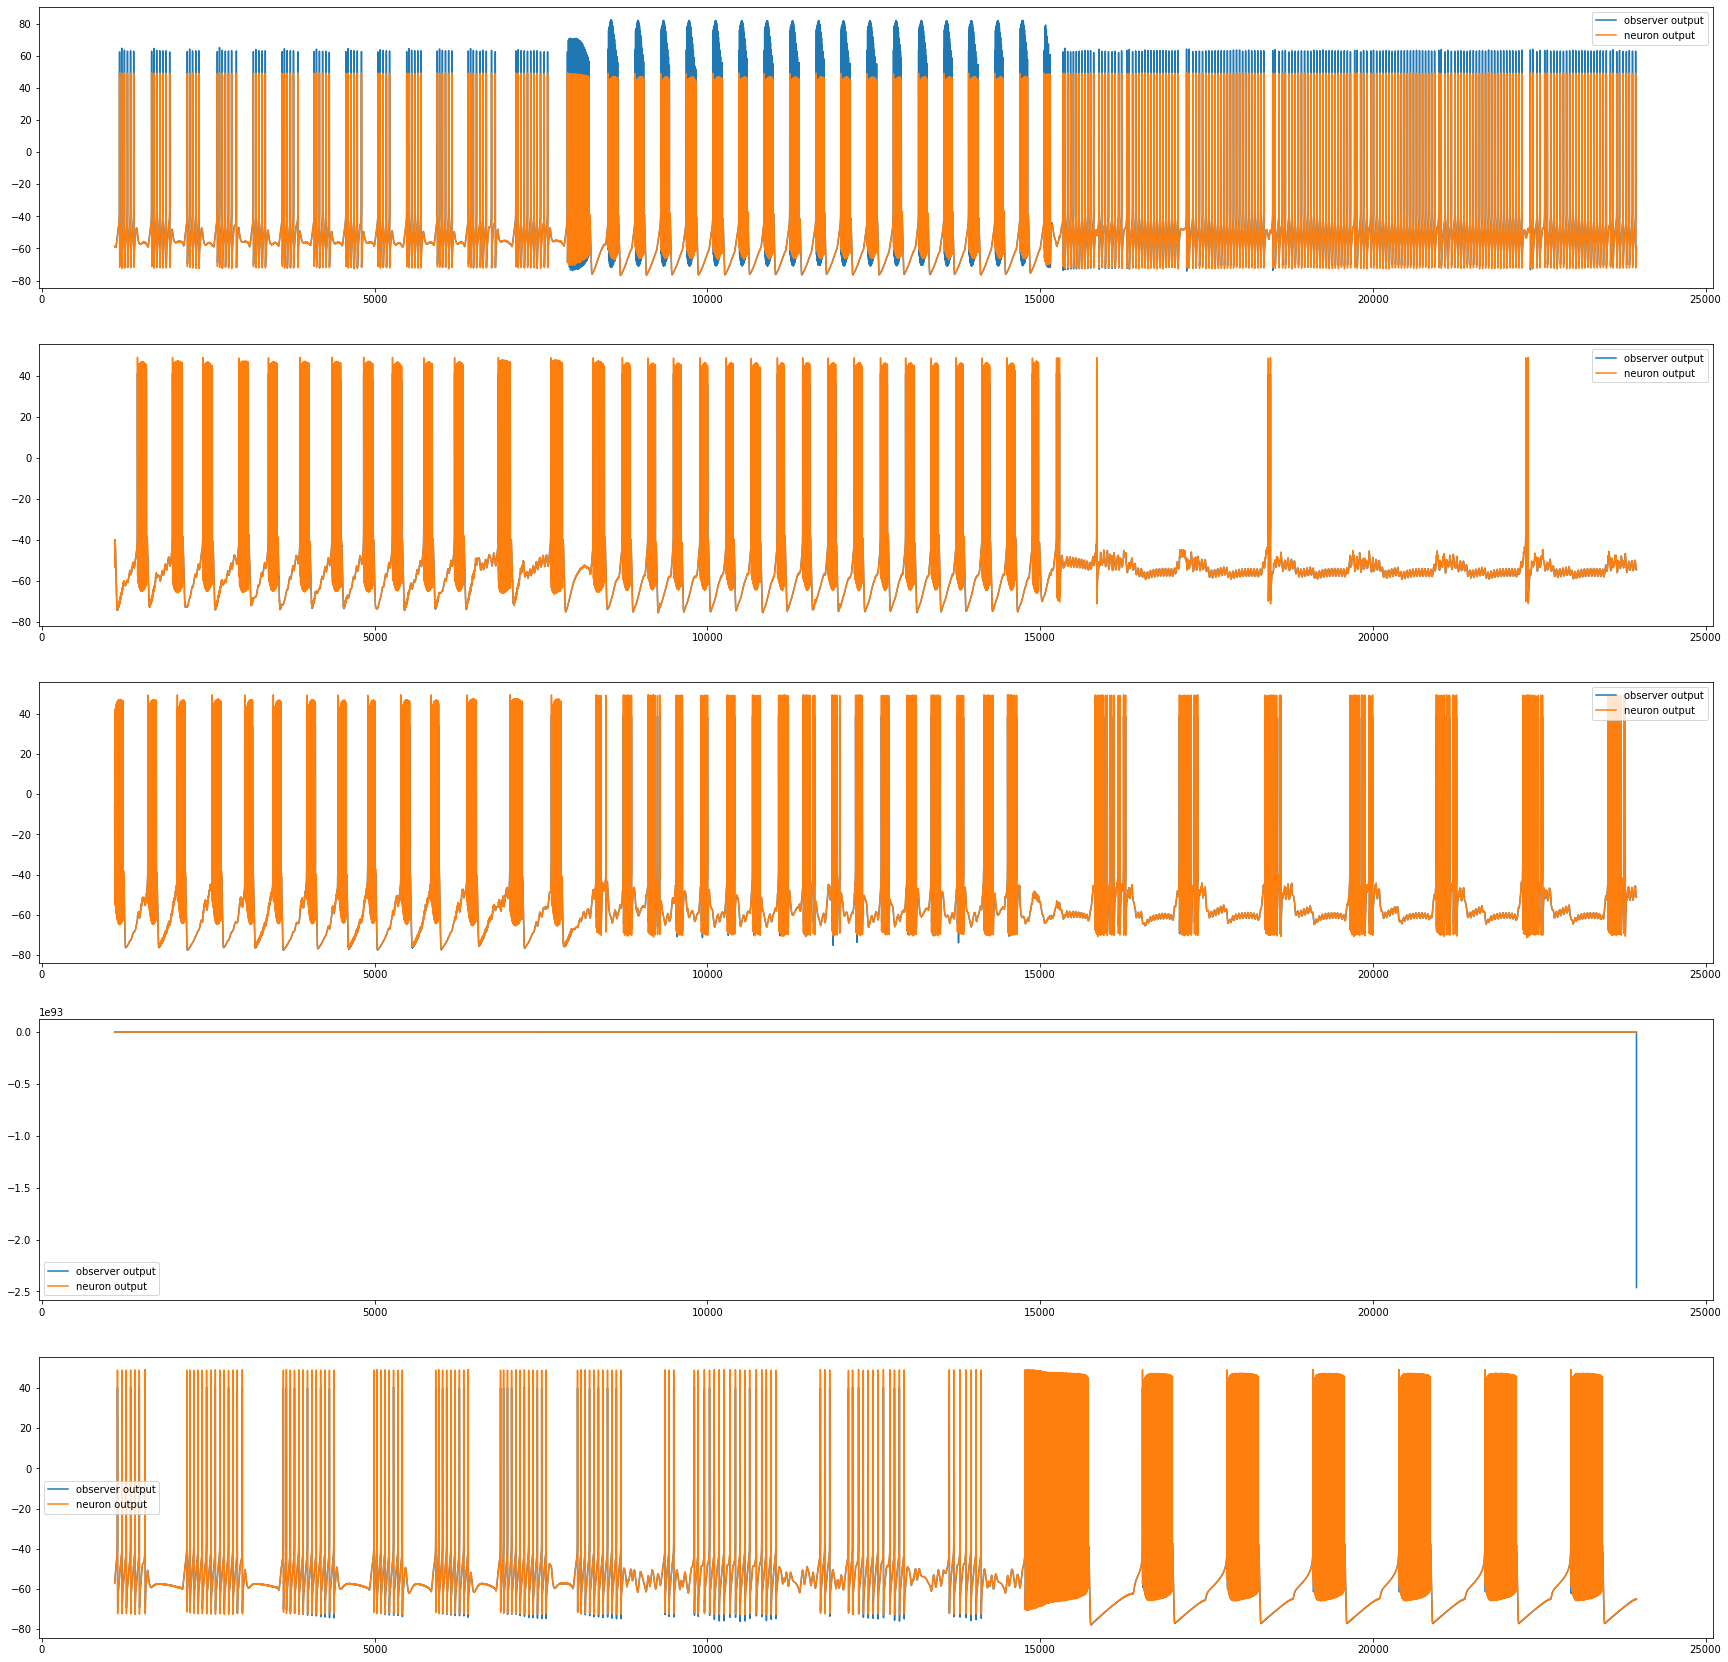

In [84]:
plot_fun(net4,sol6)

In [69]:
net5=random_MOD_mis2([0.,1.,1.,1.,0.])
#Hyperparameters
net5.set_mod(fgS,fgT)
gamma=10
alpha=0.001
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net5.cells[0].set_hyp(gamma,alpha,variable_mask1)
net5.cells[1].set_hyp(gamma,alpha,variable_mask2)
net5.cells[2].set_hyp(gamma,alpha,variable_mask3)
net5.cells[3].set_hyp(gamma,alpha,variable_mask2)
net5.cells[4].set_hyp(gamma,alpha,variable_mask1)

[0.90322492 1.05439681 1.09006757 1.01616637 0.95038066 0.90294057]
num_Theta 8
[0.96232077 1.07890224 1.07032792 1.00926018 0.95285264 1.04240488]
num_Theta 8
[0.9851601  0.93597661 1.01435413 0.90321866 1.07188313 0.91303119]
num_Theta 8
[0.95600573 0.9441952  1.0991357  1.03716854 1.02978701 1.00064306]
num_Theta 8
[1.08728157 0.92906152 1.09295892 1.07673191 1.00281293 1.0207486 ]
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [70]:
X0=[*net5.cells[0].init_cond_OB(-60+5),*net5.cells[1].init_cond_OB(-60+2),*net5.cells[2].init_cond_OB(-61),*net5.cells[3].init_cond_OB(-60-2),*net5.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol7=solve_ivp(net5.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 4.17955341e+00 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 7.77889743e+01
 7.71695119e-02]
[-10.29981144]
[5.03580000e+02 9.29811000e-02 9.07492702e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 8.62731600e+01
 7.63508367e-02 2.10839169e-02]
[-93.95236273]
[6.34723000e+02 7.81820000e-02 2.44981429e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 7.84677788e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-20.43339735]
[4.59807000e+02 8.34140000e-02 8.21023651e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 1.89773390e+01
 1.17123333e-01 2.28748603e-02]
[-17.97649055]
[6.16433000e+02 8.87343000e-02 6.28713806e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 7.30773936e+01
 7.76215841e-02]
[-35.76006315]
Elapsed (with compilation) = 491.7837188243866


In [71]:
file_sol7= open('sol7.data','wb') 
pickle.dump(sol7, file_sol7)
file_sol7.close()

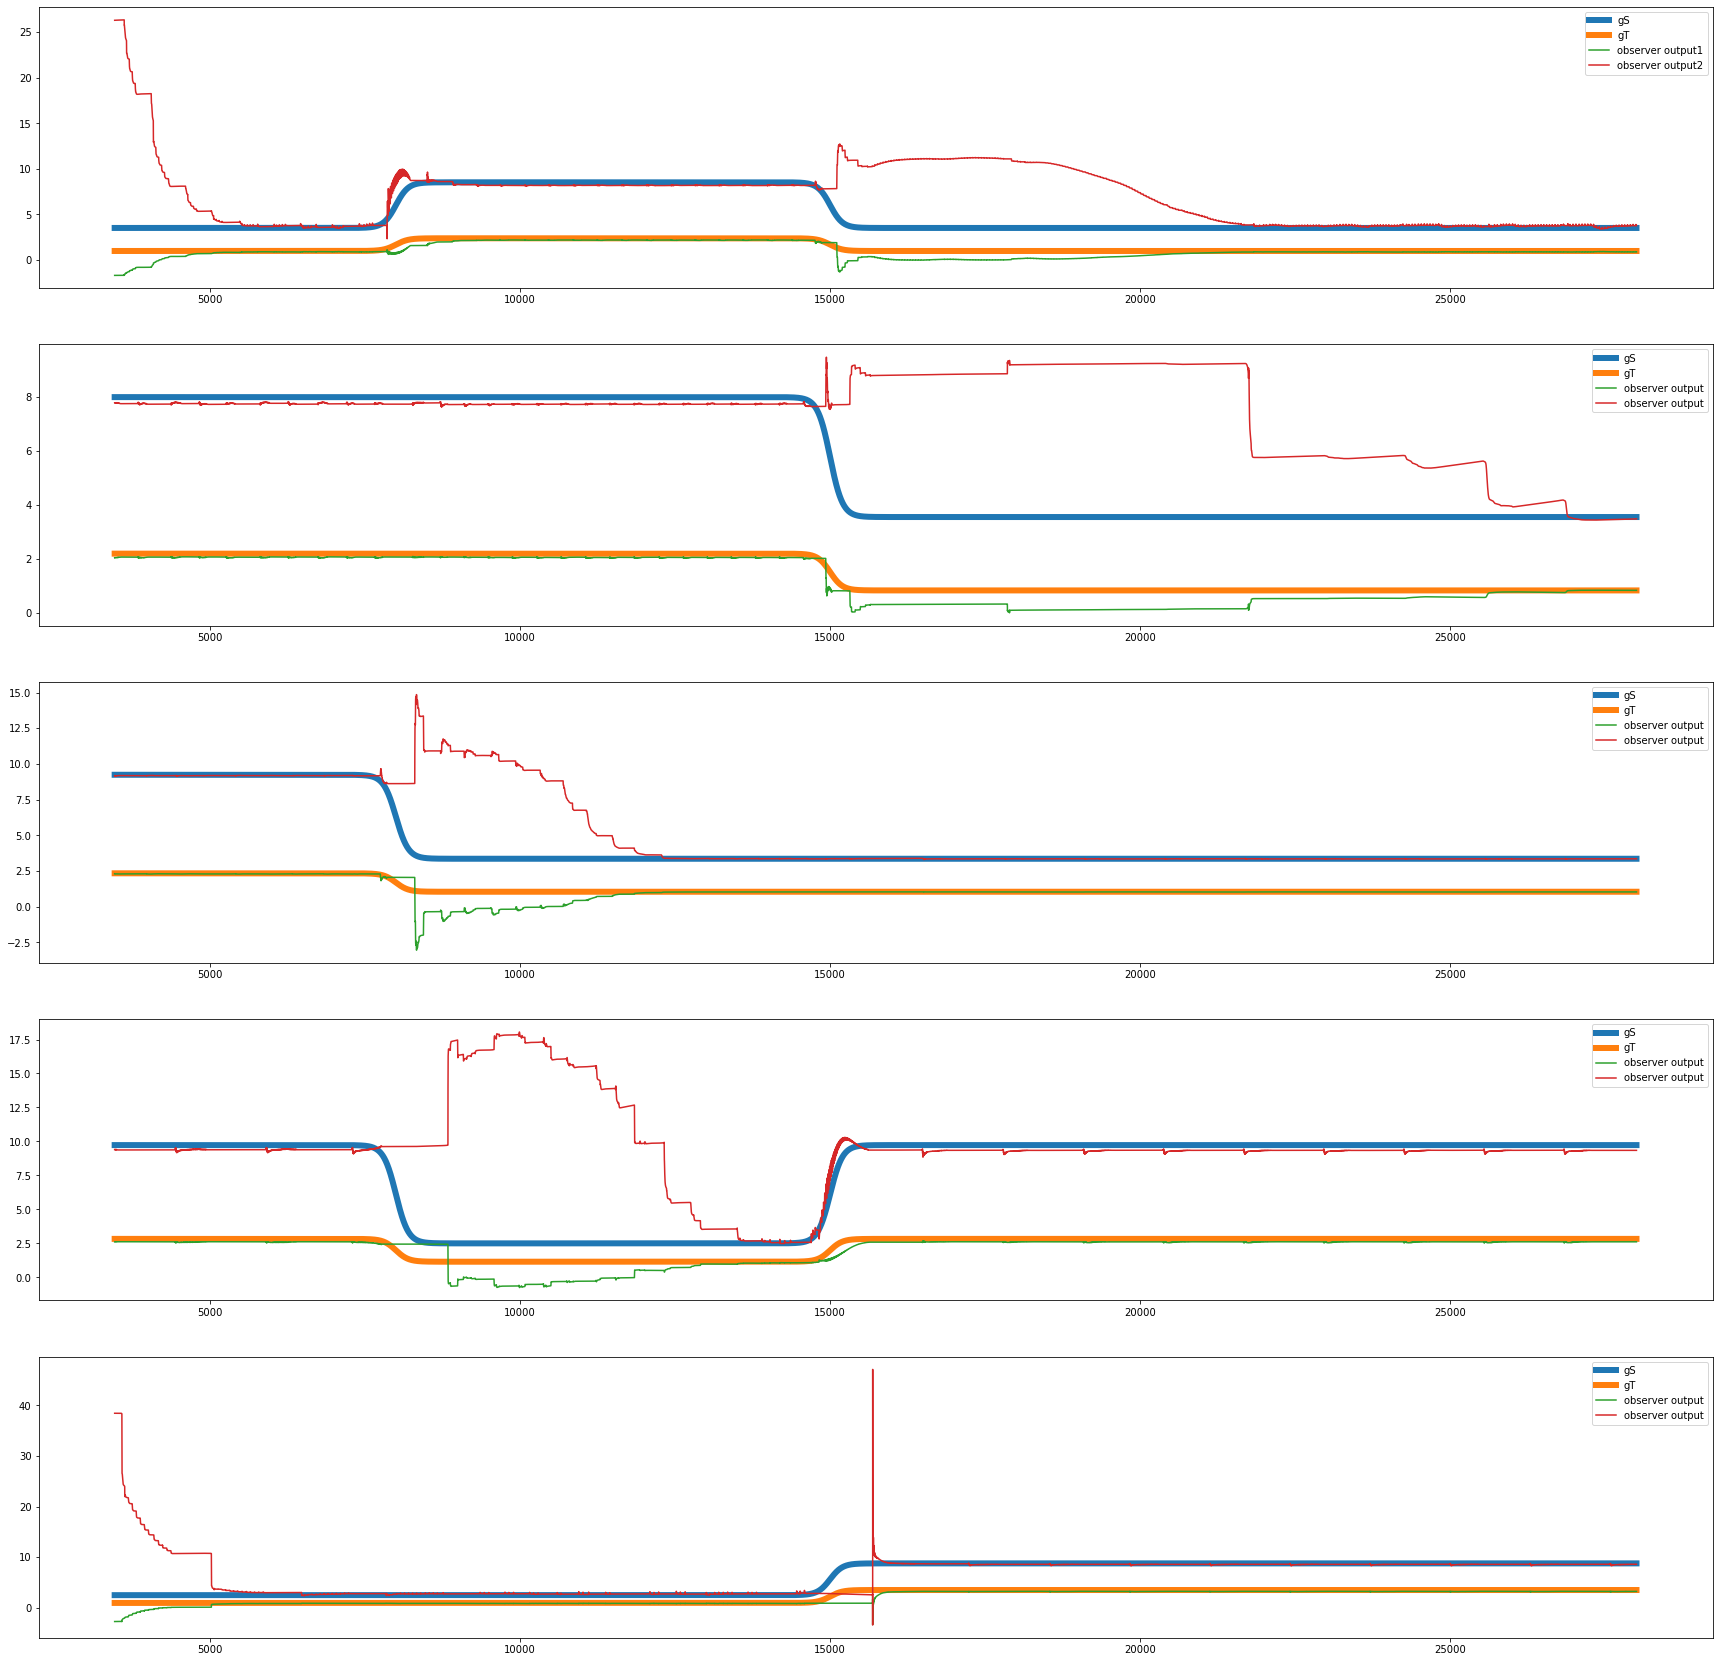

0.8910398304412069
0.8276332174251719
1.0364992461474325
2.613691246353723
3.2499390442844827


In [72]:
plot_fun2(net5,sol7)

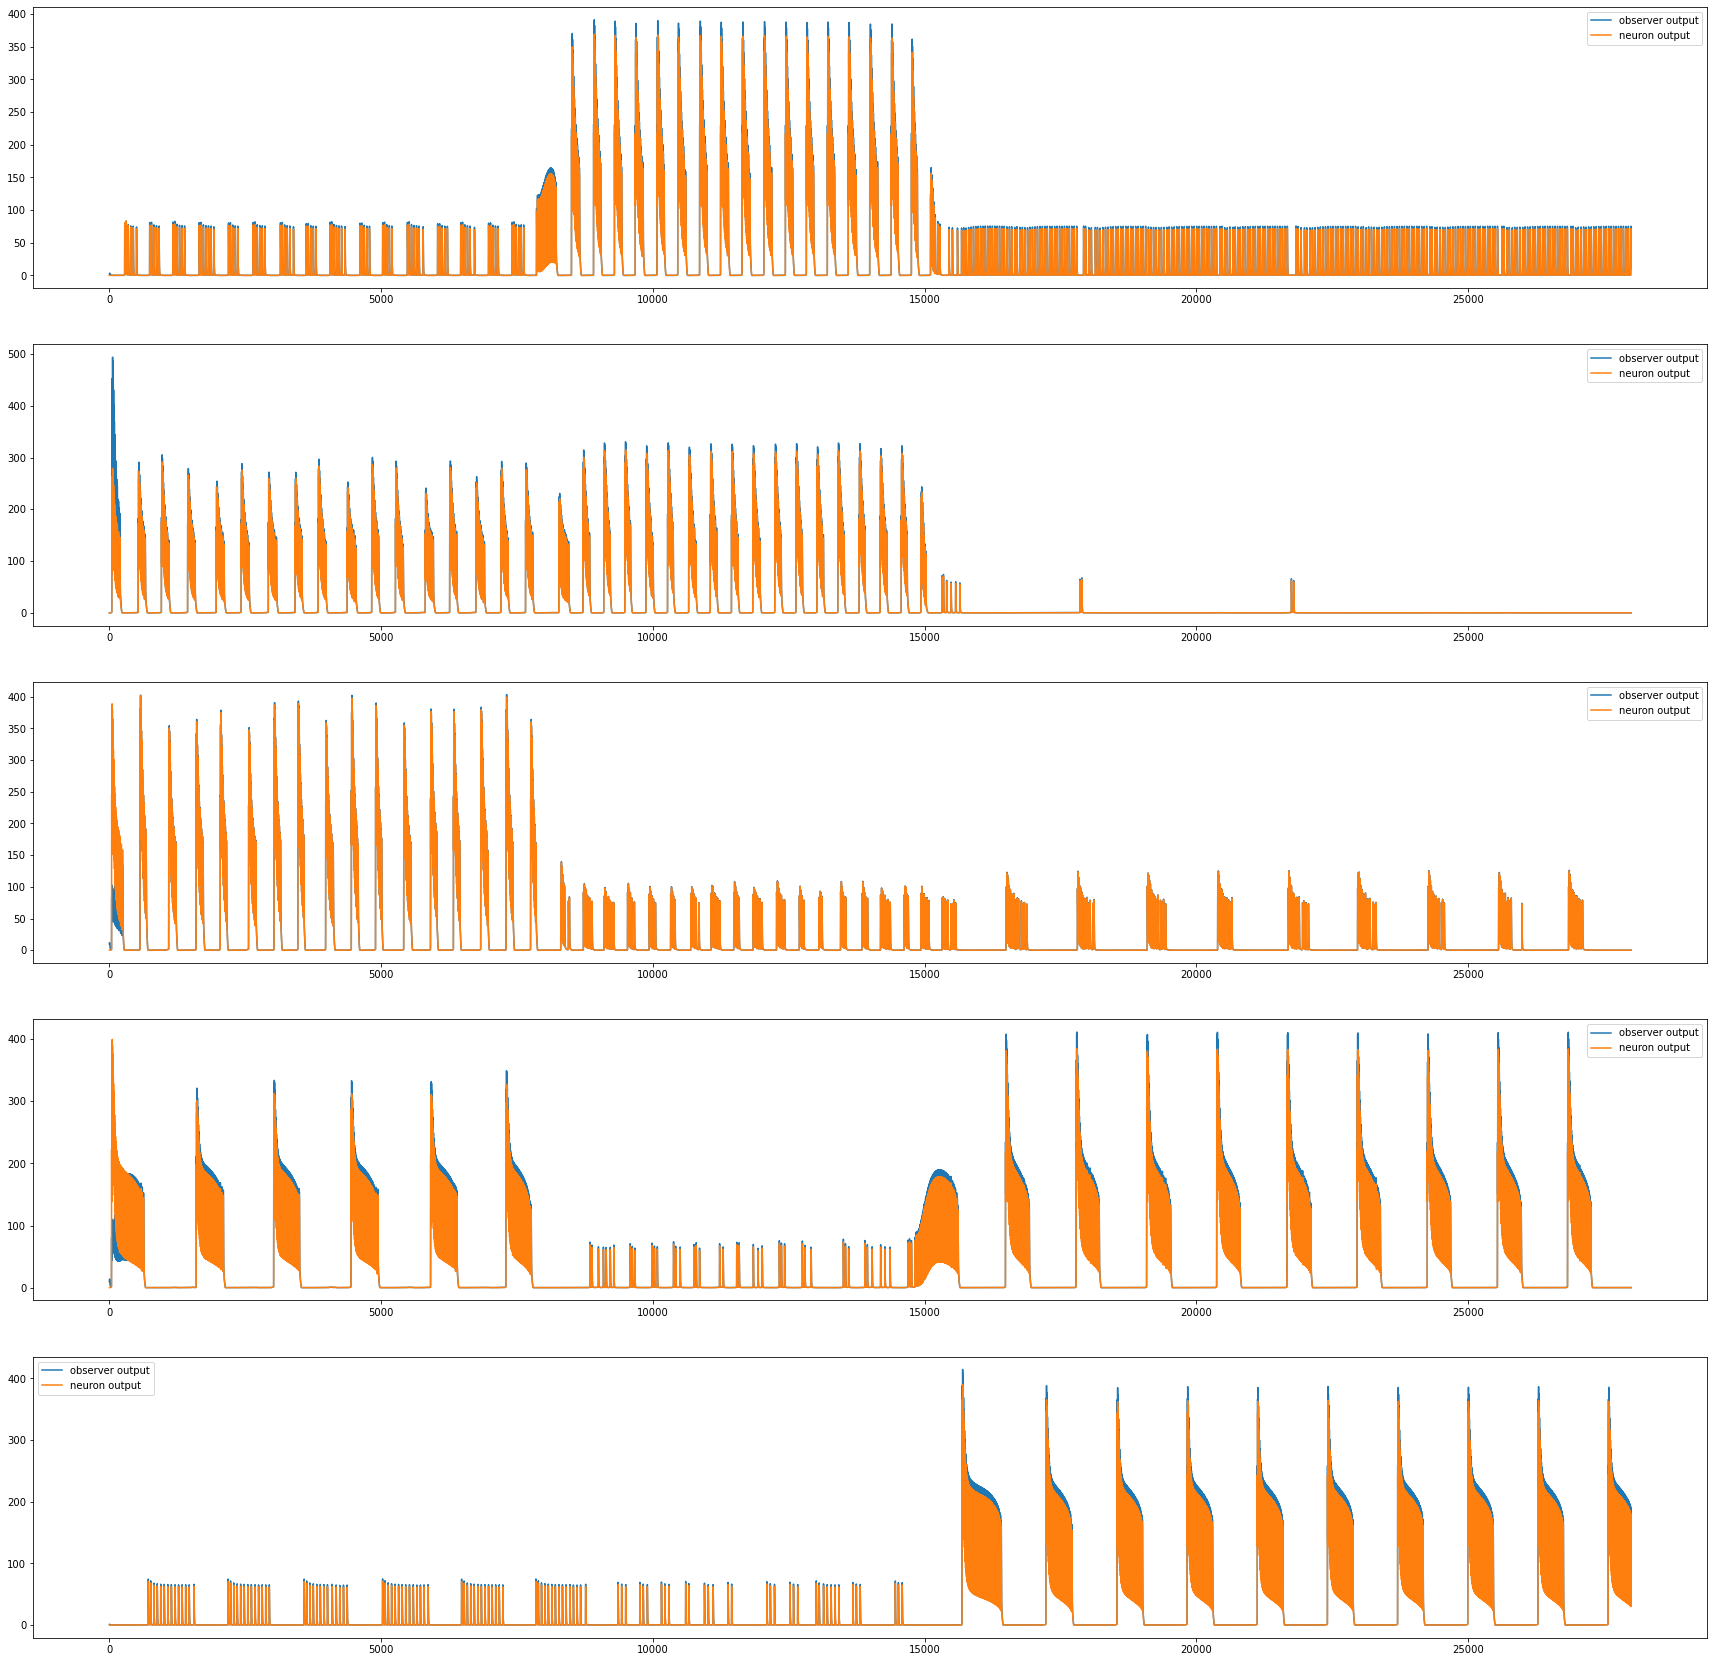

In [73]:
plot_fun1(net5,sol7)

In [75]:
net6=random_MOD_mis3([0.,1.,1.,1.,0.])
#Hyperparameters
net6.set_mod(fgS,fgT)
gamma=10
alpha=0.001
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net6.cells[0].set_hyp(gamma,alpha,variable_mask1)
net6.cells[1].set_hyp(gamma,alpha,variable_mask2)
net6.cells[2].set_hyp(gamma,alpha,variable_mask3)
net6.cells[3].set_hyp(gamma,alpha,variable_mask2)
net6.cells[4].set_hyp(gamma,alpha,variable_mask1)

[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [76]:
X0=[*net6.cells[0].init_cond_OB(-60+5),*net6.cells[1].init_cond_OB(-60+2),*net6.cells[2].init_cond_OB(-61),*net6.cells[3].init_cond_OB(-60-2),*net6.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol8=solve_ivp(net6.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 8.23594344e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 2.87421599e+00
 7.71695119e-02]
[-38.33100187]
[5.03580000e+02 9.29811000e-02 7.82341018e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 3.29611916e+01
 7.63508367e-02 2.10839169e-02]
[-82.59101618]
[6.34723000e+02 7.81820000e-02 4.11482389e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 9.73367541e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-25.32417428]
[4.59807000e+02 8.34140000e-02 6.96991117e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 3.57930886e+01
 1.17123333e-01 2.28748603e-02]
[-3.69169629]
[6.16433000e+02 8.87343000e-02 9.71791628e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 8.72401011e+01
 7.76215841e-02]
[-66.73518964]
Elapsed (with compilation) = 445.5755572319031


In [77]:
file_sol8= open('sol8.data','wb') 
pickle.dump(sol8, file_sol8)
file_sol8.close()

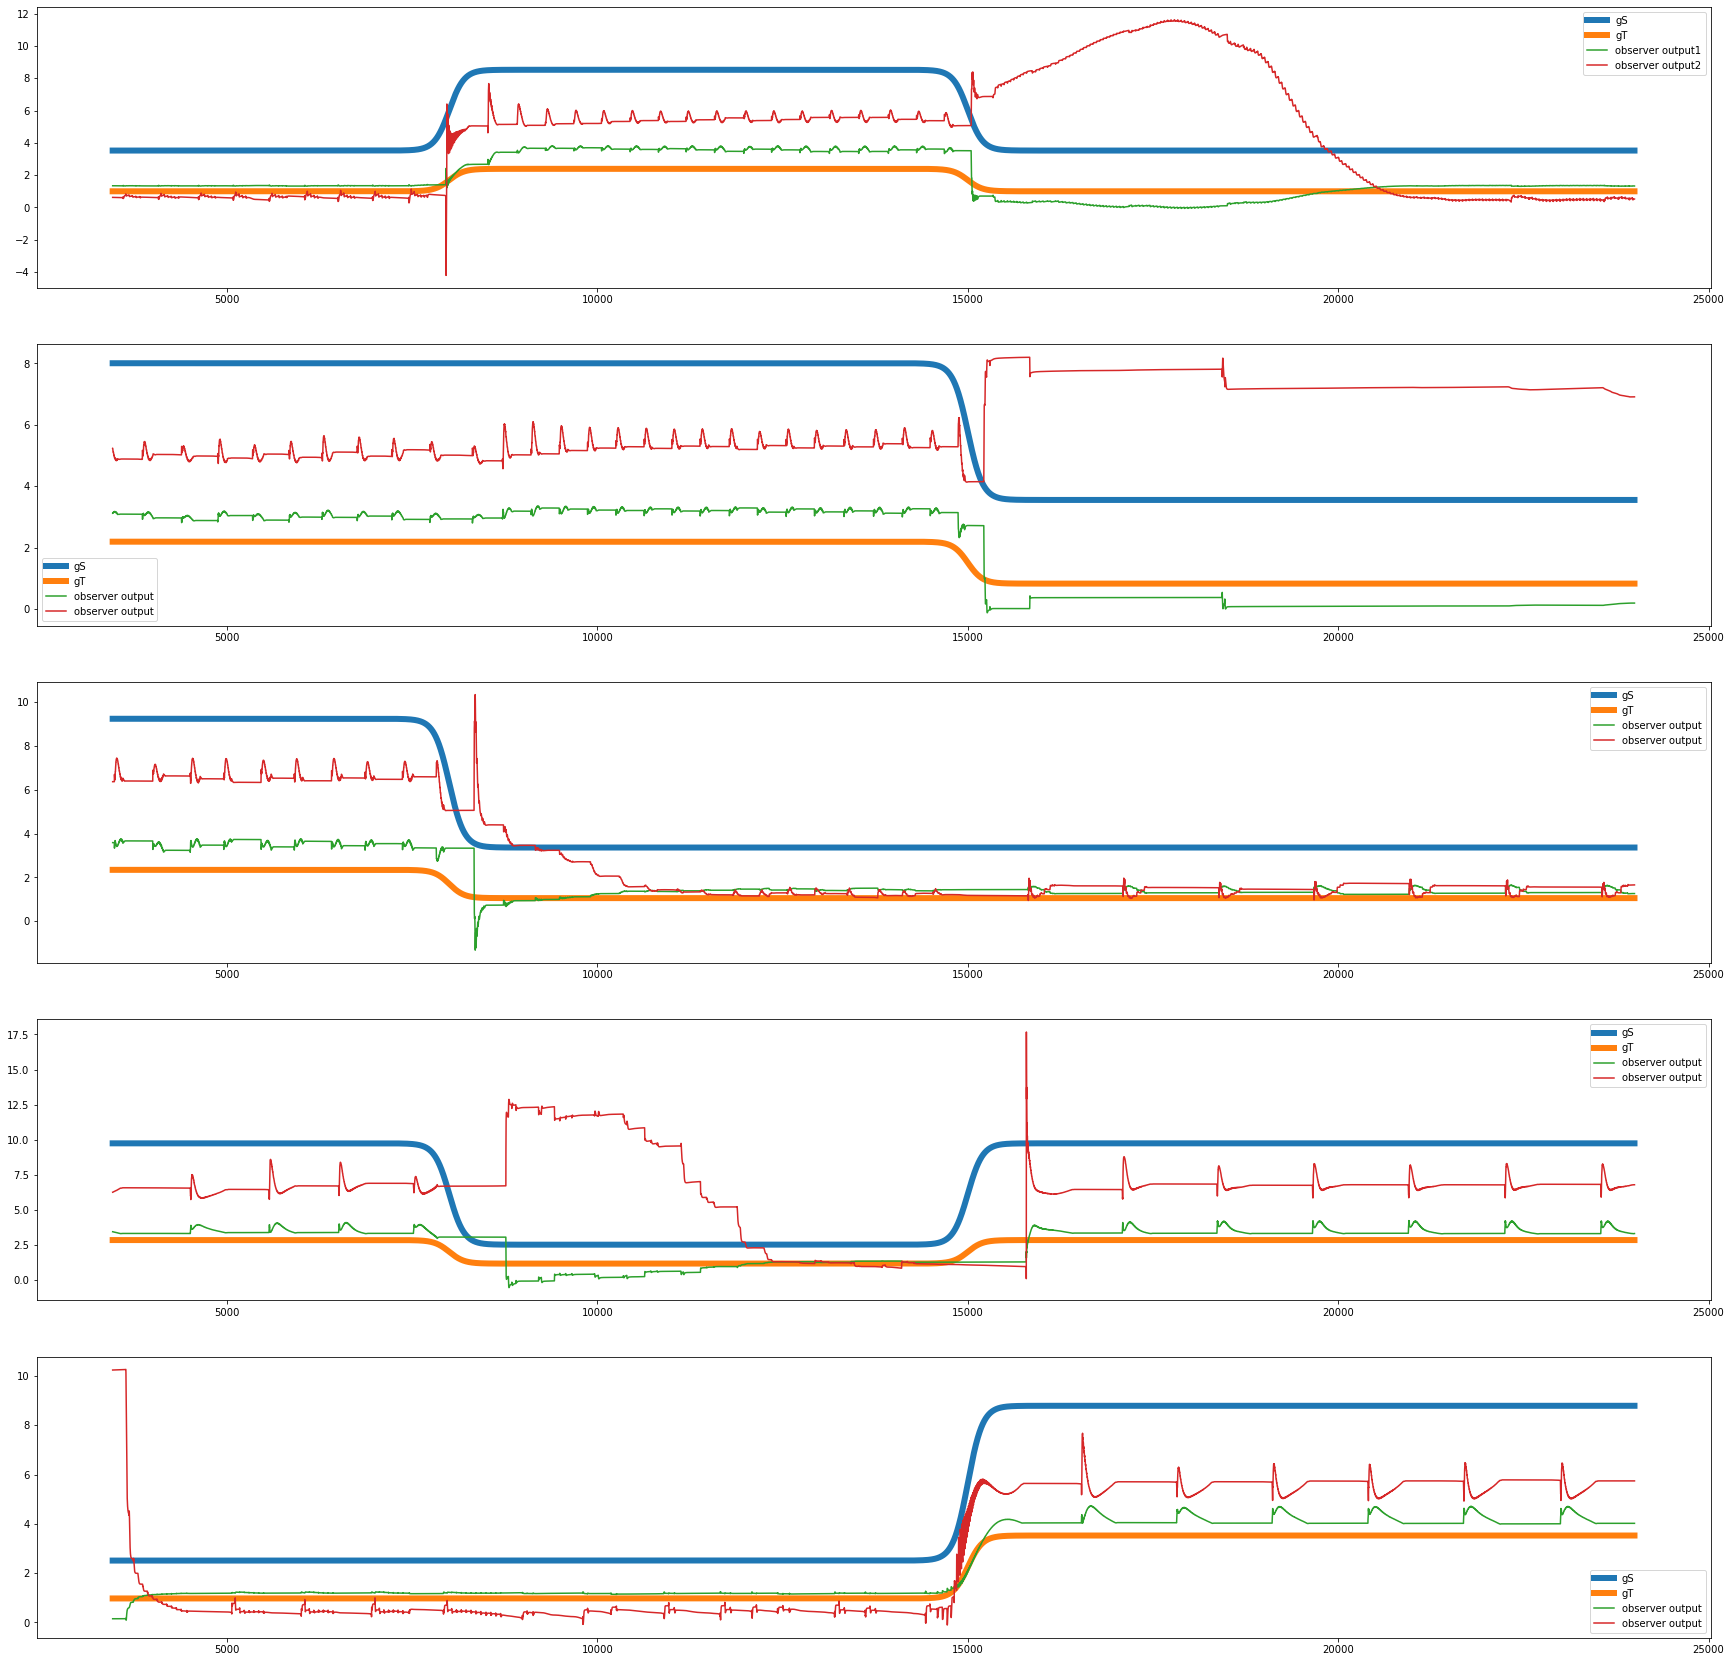

1.3216840898444213
0.1903914249260106
1.2577655362667244
3.2948377599751346
4.0205774276643025


In [78]:
plot_fun2(net6,sol8)

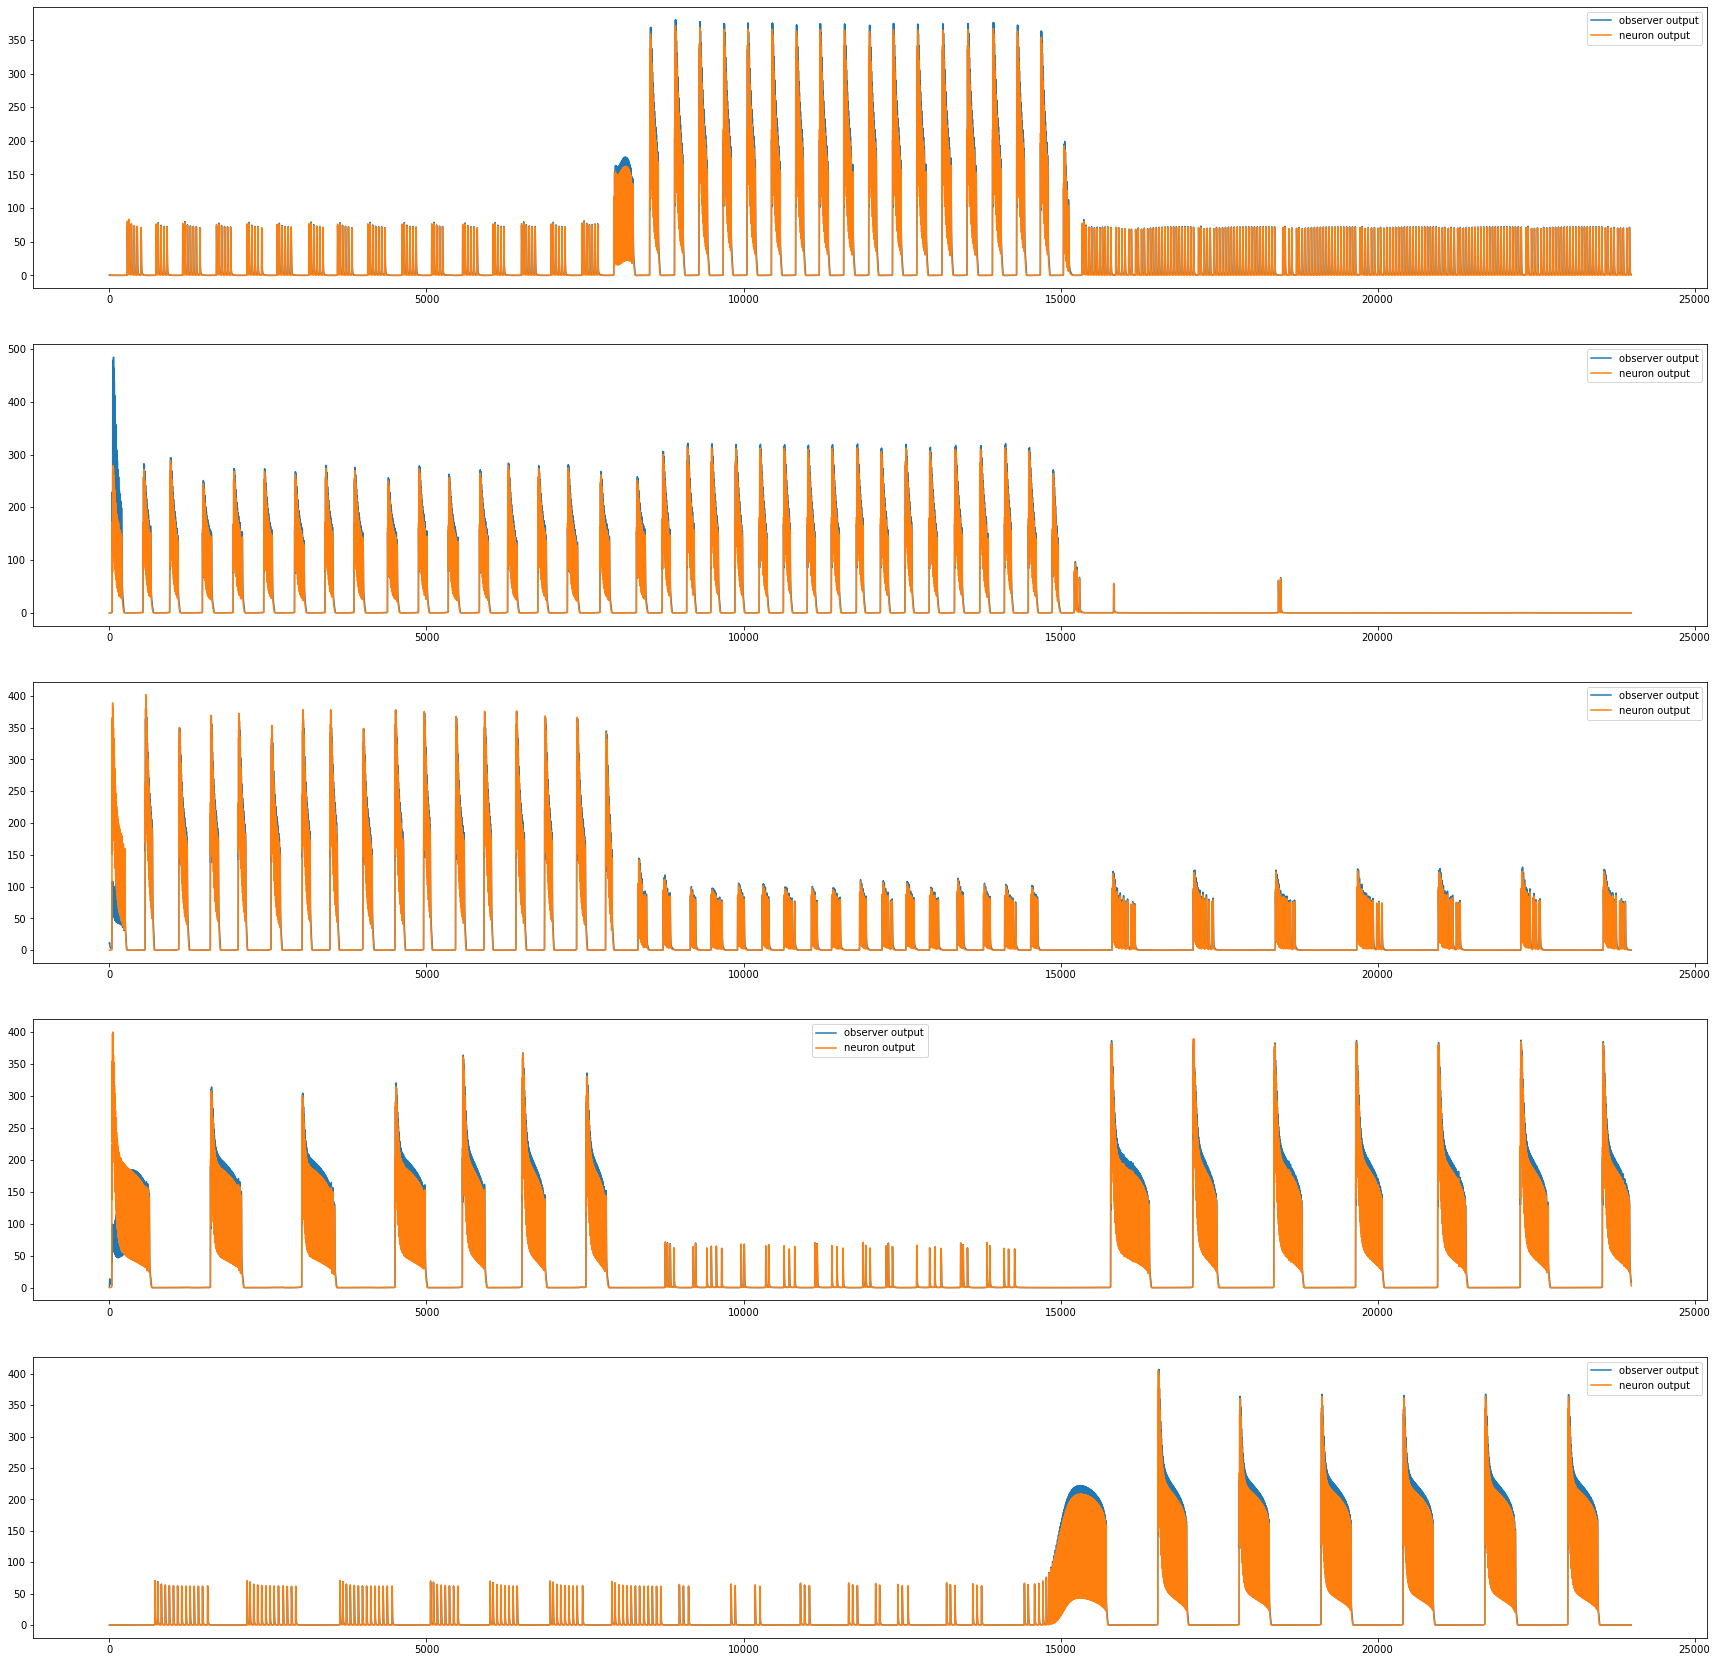

In [79]:
plot_fun1(net6,sol8)

In [64]:
net62=random_MOD_mis4([0.,1.,1.,1.,0.])
#Hyperparameters
net62.set_mod(fgS,fgT)
gamma=10
alpha=0.001
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net62.cells[0].set_hyp(gamma,alpha,variable_mask1)
net62.cells[1].set_hyp(gamma,alpha,variable_mask2)
net62.cells[2].set_hyp(gamma,alpha,variable_mask3)
net62.cells[3].set_hyp(gamma,alpha,variable_mask2)
net62.cells[4].set_hyp(gamma,alpha,variable_mask1)

[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [65]:
X0=[*net62.cells[0].init_cond_OB(-60+5),*net62.cells[1].init_cond_OB(-60+2),*net62.cells[2].init_cond_OB(-61),*net62.cells[3].init_cond_OB(-60-2),*net62.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol82=solve_ivp(net62.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 4.99600593e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 9.89348455e+00
 7.71695119e-02]
[-14.62787739]
[5.03580000e+02 9.29811000e-02 6.87631604e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 3.24137851e+01
 7.63508367e-02 2.10839169e-02]
[-71.02728711]
[6.34723000e+02 7.81820000e-02 8.14976643e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 8.92371124e+00
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-62.99251239]
[4.59807000e+02 8.34140000e-02 3.10184091e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 2.62162616e+01
 1.17123333e-01 2.28748603e-02]
[-95.26601304]
[6.16433000e+02 8.87343000e-02 7.06151082e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 2.34971823e+01
 7.76215841e-02]
[-3.99731459]
Elapsed (with compilation) = 440.7991626262665


In [66]:
file_sol82= open('sol82.data','wb') 
pickle.dump(sol82, file_sol82)
file_sol82.close()

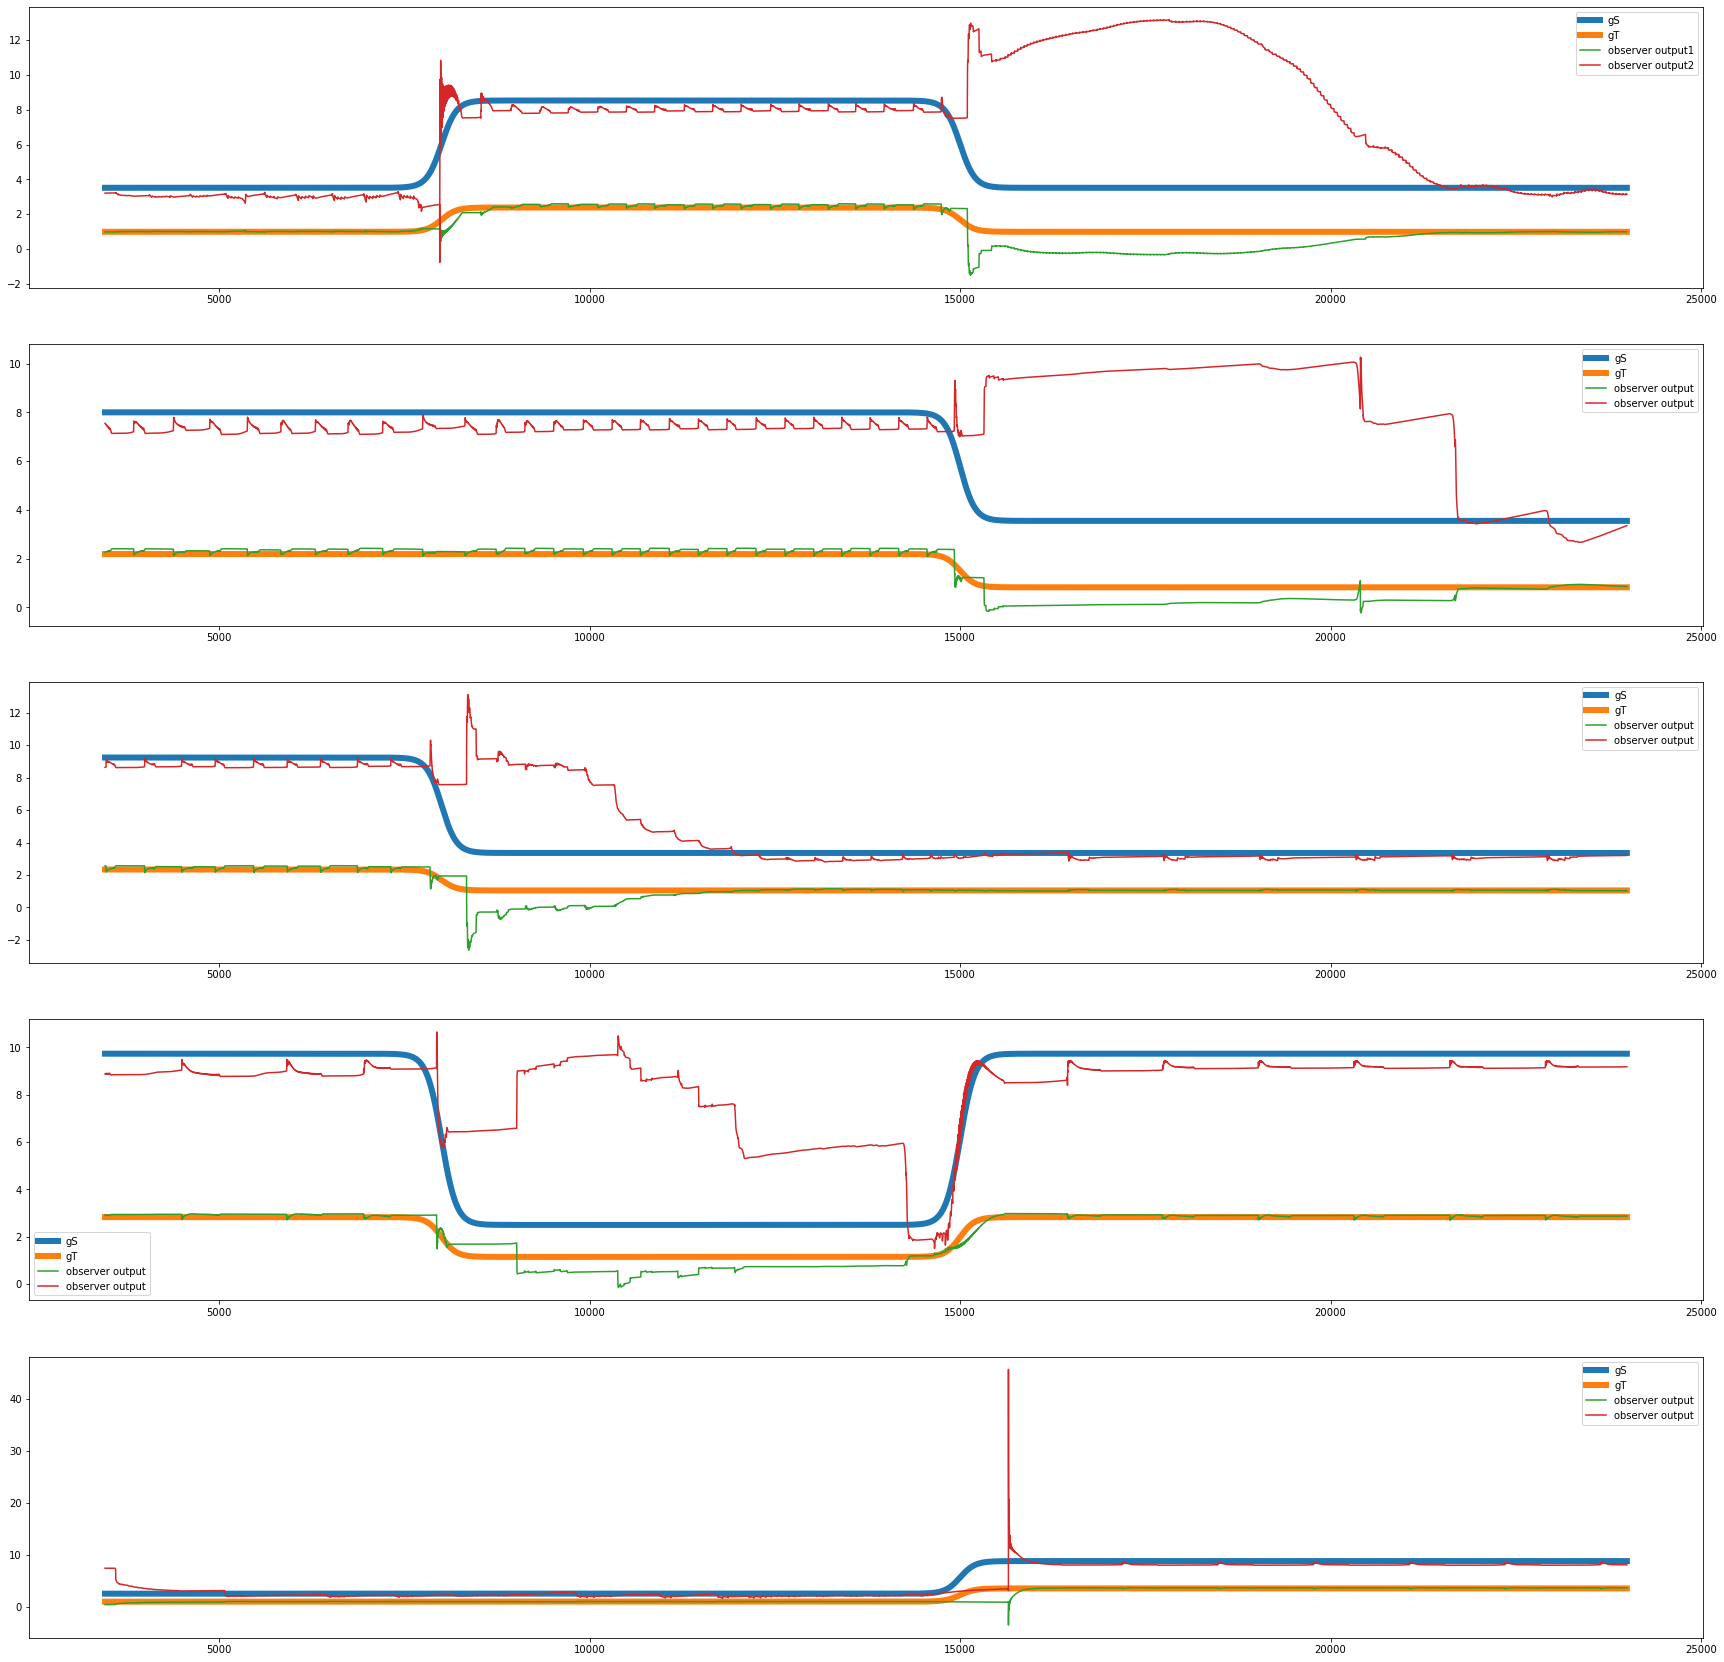

0.996842557638323
0.8576850223792446
1.0316637977318004
2.871746013105853
3.6237308685847593


In [67]:
plot_fun2(net62,sol82)

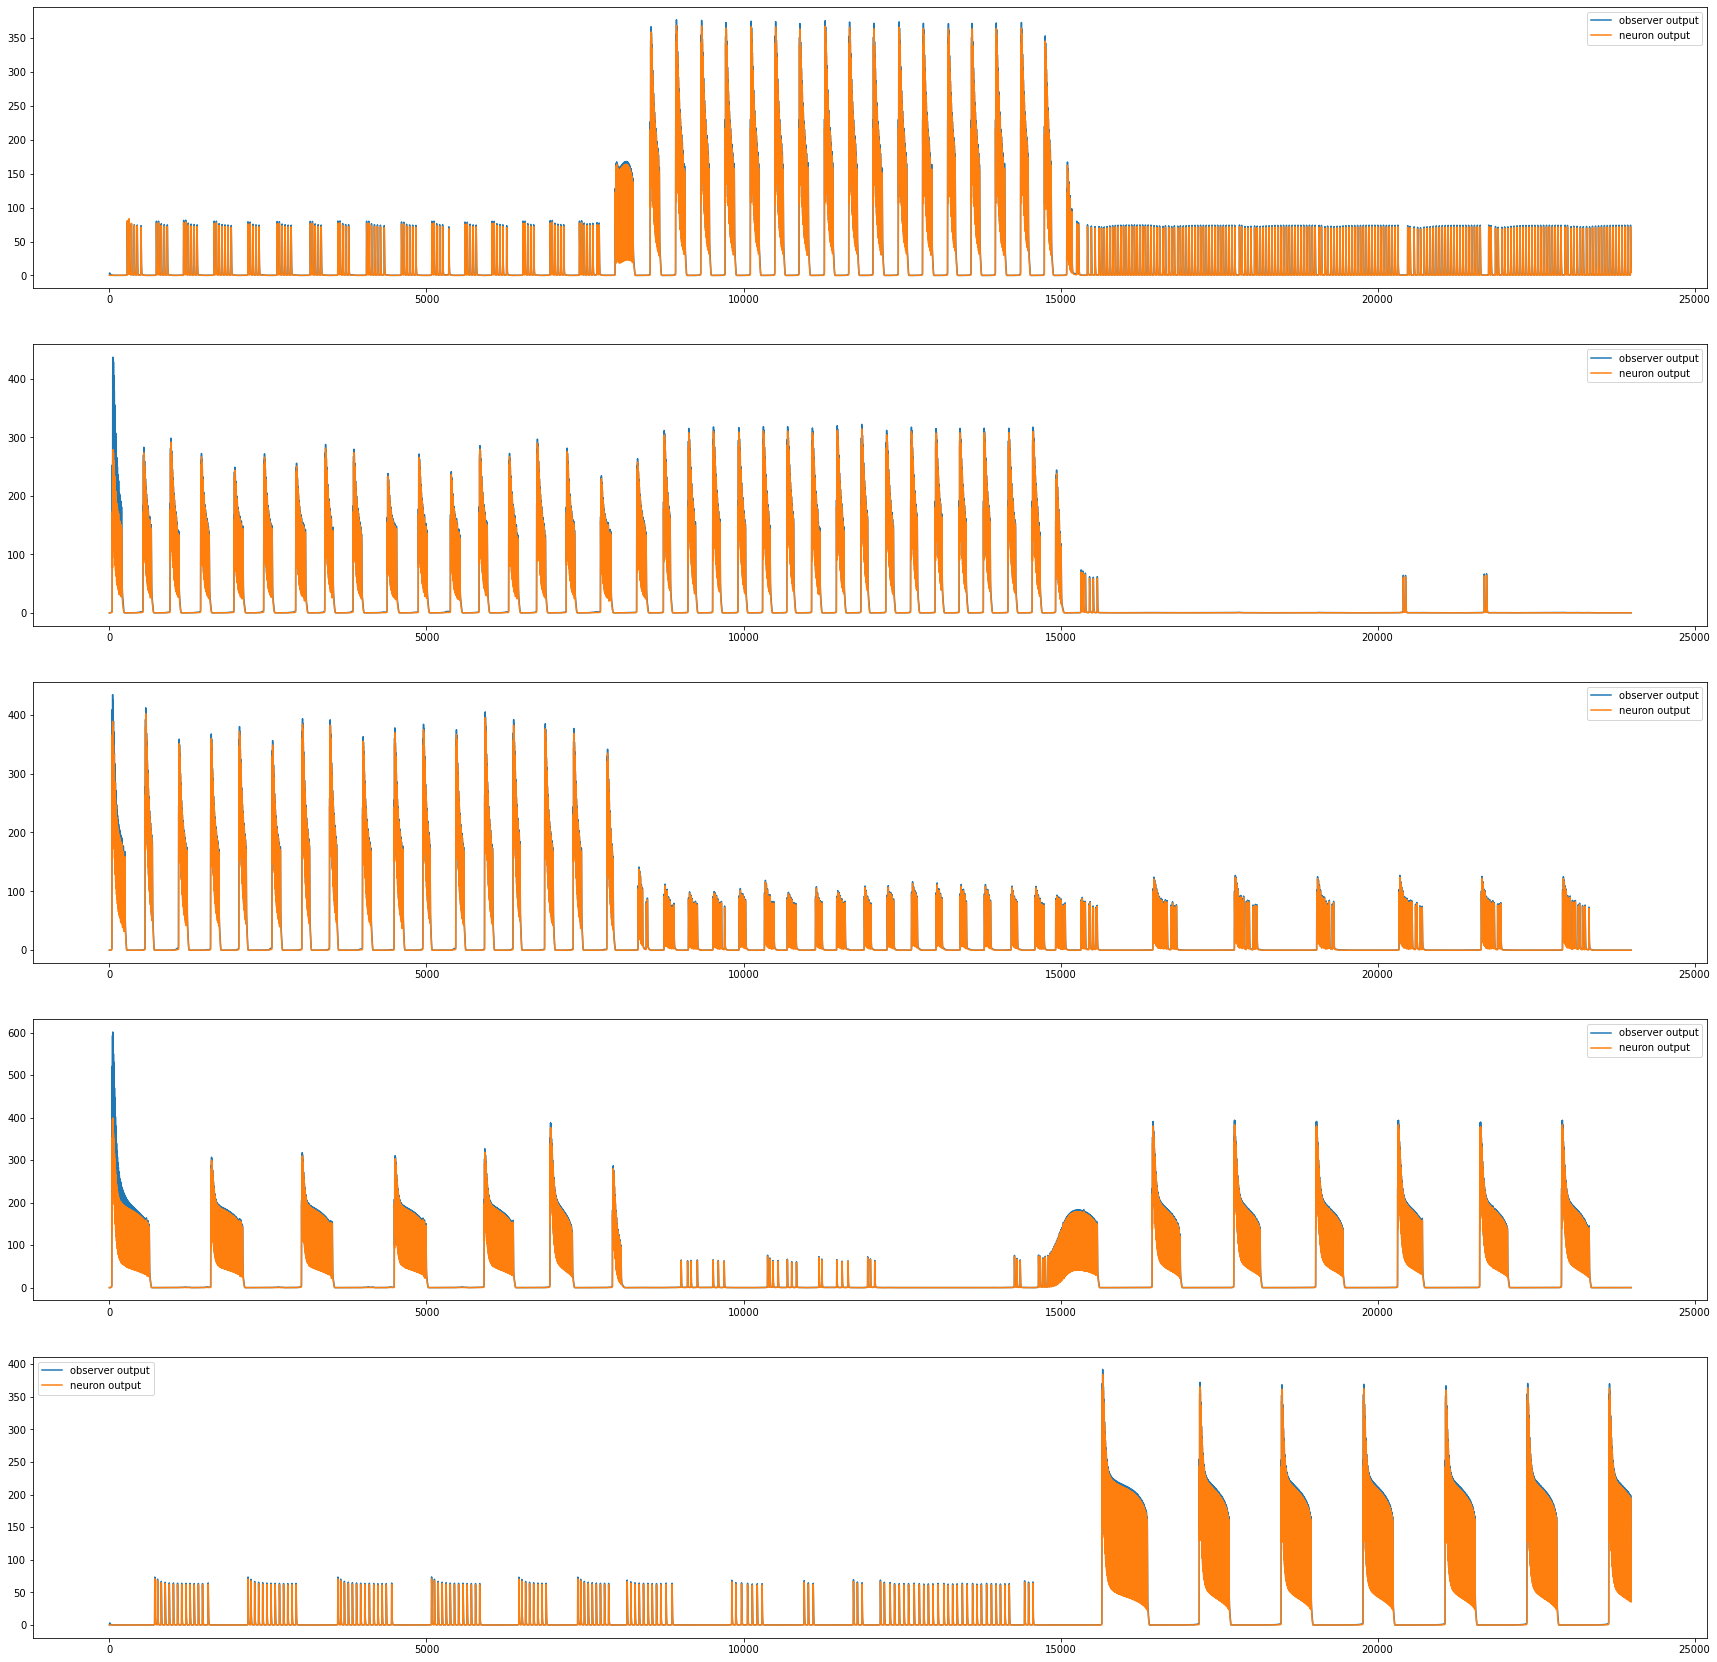

In [68]:
plot_fun1(net62,sol82)